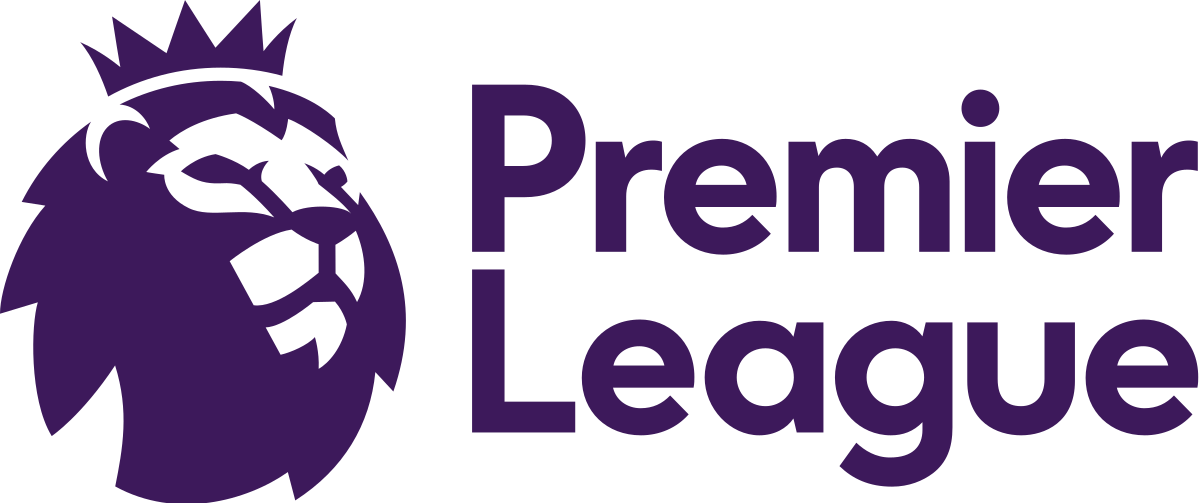

# In this notebook, We will have analysis and visualizations for the last 3 completed seasons in PL

##### Importing libraries that is needed for this project

In [1]:
import os 
import pandas as pd
from IPython.display import display
import numpy as np
import unidecode
import copy
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

## Scraping Team Links and Names for Each Season

##### In the next cell we will get link for each team in every season listed in "seasons" list to have detailed stats for each team later and result will be stored in "teams_link" list 

In [2]:
#Intiate Chrome Driver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

#Seasons to scrape
seasons=["2021-2022","2020-2021","2019-2020"]
#Intiate empty list of lists to store the resultant links in it
teams_link=[[] for i in range(len(seasons))]
teams_name=[[] for i in range(len(seasons))]
teams_pts =[]

# Main page of Premier League Stats
driver.get("https://fbref.com/en/comps/9/Premier-League-Stats")

#Scrape for each season
for season in range(len(seasons)):
    
    # We hit previous button to reach previous season
    previous=driver.find_element(By.XPATH,"/html/body/div[2]/div[4]/div[1]/div[2]/div/a")
    previous.click()
    
    #Find the table of standings by table then choosing cells on the left to obtain links
    standings=driver.find_element(By.ID,"results"+seasons[season]+"91_overall")\
                   .find_elements(By.CLASS_NAME,"left")
    
    #Obtain a tags for each row including teams and last matches
    a_tags=[]
    for i in range(len(standings)):
        a_tag=standings[i].find_elements(By.TAG_NAME,"a")
        a_tags.append(a_tag)
        
    # Obtain the links('href') for each team and exclude the last matches link
    for i in range(len(a_tags)):
        for j in range(len(a_tags[i])):
            team_link=a_tags[i][j].get_attribute("href")            
            team_name=a_tags[i][j].text
            # Obtain team links only not last matches links
            if (team_link.find("https://fbref.com/en/squads") != -1):
                teams_link[season].append(team_link)
                teams_name[season].append(team_name)  
    
    pts=driver.find_element(By.ID,"results"+seasons[season]+"91_overall")
    teams_pts.append(pd.read_html(pts.get_attribute("outerHTML")))


#Quit session
driver.quit()

[WDM] - Downloading: 100%|██████████| 6.46M/6.46M [00:08<00:00, 810kB/s] 


## Importing Scraped Data

In [3]:
PL={}

teams_stats=["stats","shooting","keepers","passing","passing_types","gca","defense","possession","misc"]
players_stats=["stats","keepers","keepersadv","passing","passing_types","gca","defense","possession","playingtime","misc"]


for season in range(len(seasons)):
    for team in range(20):
        
        for stat in teams_stats:
            #Create Structre for every team where each team has dataframe for every type of stats for the matches
            #The stats df doesn't have multiindexed columns
            if stat=="stats":
                PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat]=\
                pd.read_csv("PL"+"/"+seasons[season][:4]+"/"+teams_name[season][team]+"/stats.csv")
                
            #The rest of stats df have multiindexed columns
            else: 
                PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat]=\
                pd.read_csv("PL"+"/"+seasons[season][:4]+"/"+teams_name[season][team]+"/"+stat+".csv",header=[0,1])
        
    for stat in players_stats:
        #Create Structre for all players where each season has dataframe for every type of stats for all players
        PL['s' + seasons[season][:4]+"_"+stat]=pd.read_csv("PL"+"/"+seasons[season][:4]+"/"+stat+".csv",header=[0,1])   
    

## Discovering Data 

### Player Stats:

We will display data for the players stats in all seasons and discovering its columns and null values and types of data

##### From the head displayed:
- _Columns are really messy and multiindexed._ 

- _The first two columns and last column are useless._

- _Players column names have accent like "â" not "a" that makes hard to select player name._

- _Nation is not well structed._

In [4]:
#Display head of all players stats
for season in range(len(seasons)):
    for stat in players_stats:
        print("\n"+seasons[season]+" "+stat+"\n")
        display(PL["s"+seasons[season][:4]+"_"+stat].head())


2021-2022 stats



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1         Max Aarons            eng ENG   
1                  1  2          Che Adams            sct SCO   
2                  2  3    Rayan Aït Nouri             fr FRA   
3                  3  4    Kristoffer Ajer             no NOR   
4                  4  5         Nathan Aké             nl NED   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF       Norwich City                 21               2000   
1                 FW        Southampton                 25               1996   
2              DF,MF             Wolves                 20               2001   
3                 DF          Brentford                 23               1998   
4                 DF    Manchester City                 26               1995   

  Playing Time         ... Expected                    Per 90 Minutes        \
            MP Starts  ...       xG npxG  xAG npxG+xAG             xG   xAG   
0           34     32  ...      0.9  0.9  1.6      2.5           0.03  0.05   
1           30     23  ...      7.7  7.7  3.2     10.9           0.34  0.14   
2           23     20  ...      0.8  0.8  1.4      2.2           0.04  0.07   
3           24     23  ...      0.8  0.8  2.2      3.1           0.04  0.10   
4           14     10  ...      0.7  0.7  0.5      1.3           0.07  0.05   

                        Unnamed: 32_level_0  
  xG+xAG  npxG npxG+xAG             Matches  
0   0.08  0.03     0.08             Matches  
1   0.48  0.34     0.48             Matches  
2   0.11  0.04     0.11             Matches  
3   0.14  0.04     0.14             Matches  
4   0.12  0.07     0.12             Matches  

[5 rows x 34 columns]


2021-2022 keepers



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1            Alisson             br BRA   
1                  1  2    Alphonse Areola             fr FRA   
2                  2  3  Kepa Arrizabalaga             es ESP   
3                  3  4    Daniel Bachmann             at AUT   
4                  4  5      Asmir Begović             ba BIH   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 GK          Liverpool                 28               1992   
1                 GK           West Ham                 28               1993   
2                 GK            Chelsea                 26               1994   
3                 GK            Watford                 27               1994   
4                 GK            Everton                 34               1987   

  Playing Time         ... Unnamed: 17_level_0 Unnamed: 18_level_0  \
            MP Starts  ...                   D                   L   
0           36     36  ...                   7                   2   
1            1      1  ...                   0                   1   
2            4      4  ...                   1                   1   
3           12     12  ...                   0                  11   
4            3      3  ...                   0                   2   

  Performance             Penalty Kicks                Unnamed: 26_level_0  
           CS   CS% PKatt           PKA PKsv PKm Save%             Matches  
0          20  55.6     0             0    0   0   NaN             Matches  
1           0   0.0     0             0    0   0   NaN             Matches  
2           2  50.0     0             0    0   0   NaN             Matches  
3           0   0.0     3             3    0   0   0.0             Matches  
4           1  33.3     1             1    0   0   0.0             Matches  

[5 rows x 28 columns]


2021-2022 keepersadv



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1            Alisson             br BRA   
1                  1  2    Alphonse Areola             fr FRA   
2                  2  3  Kepa Arrizabalaga             es ESP   
3                  3  4    Daniel Bachmann             at AUT   
4                  4  5      Asmir Begović             ba BIH   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 GK          Liverpool                 28               1992   
1                 GK           West Ham                 28               1993   
2                 GK            Chelsea                 26               1994   
3                 GK            Watford                 27               1994   
4                 GK            Everton                 34               1987   

  Unnamed: 7_level_0 Unnamed: 8_level_0  ... Goal Kicks                 \
                 90s                 GA  ...        Att Launch% AvgLen   
0               36.0                 24  ...        172    33.1   33.4   
1                1.0                  1  ...         14    71.4   48.5   
2                4.0                  2  ...         21    28.6   27.6   
3               12.0                 28  ...         87    67.8   47.8   
4                3.0                  8  ...         31    71.0   51.3   

  Crosses          Sweeper                 Unnamed: 33_level_0  
      Opp Stp Stp%    #OPA #OPA/90 AvgDist             Matches  
0     340  22  6.5      89    2.47    18.7             Matches  
1      15   1  6.7       0    0.00     5.5             Matches  
2      44   2  4.5       8    2.00    18.8             Matches  
3     187   7  3.7      12    1.00    16.1             Matches  
4      50   3  6.0       2    0.67    10.7             Matches  

[5 rows x 35 columns]


2021-2022 passing



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1         Max Aarons            eng ENG   
1                  1  2          Che Adams            sct SCO   
2                  2  3    Rayan Aït Nouri             fr FRA   
3                  3  4    Kristoffer Ajer             no NOR   
4                  4  5         Nathan Aké             nl NED   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF       Norwich City                 21               2000   
1                 FW        Southampton                 25               1996   
2              DF,MF             Wolves                 20               2001   
3                 DF          Brentford                 23               1998   
4                 DF    Manchester City                 26               1995   

  Unnamed: 7_level_0 Total  ... Unnamed: 22_level_0 Unnamed: 23_level_0  \
                 90s   Cmp  ...                 Ast                 xAG   
0               32.0  1107  ...                   2                 1.6   
1               22.7   304  ...                   3                 3.2   
2               20.3   763  ...                   2                 1.4   
3               22.2   627  ...                   3                 2.2   
4               10.3   796  ...                   0                 0.5   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                   xA               A-xAG                  KP   
0                 1.7                +0.4                  20   
1                 1.7                -0.2                  26   
2                 1.1                +0.6                  17   
3                 1.8                +0.8                   8   
4                 0.5                -0.5                   2   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  50                  37                   9   
1                  24                  10                   0   
2                  28                  14                  10   
3                  41                  13                   2   
4                  63                   3                   0   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog             Matches  
0                  86             Matches  
1                  29             Matches  
2                  37             Matches  
3                  66             Matches  
4                  33             Matches  

[5 rows x 33 columns]


2021-2022 passing_types



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1         Max Aarons            eng ENG   
1                  1  2          Che Adams            sct SCO   
2                  2  3    Rayan Aït Nouri             fr FRA   
3                  3  4    Kristoffer Ajer             no NOR   
4                  4  5         Nathan Aké             nl NED   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF       Norwich City                 21               2000   
1                 FW        Southampton                 25               1996   
2              DF,MF             Wolves                 20               2001   
3                 DF          Brentford                 23               1998   
4                 DF    Manchester City                 26               1995   

  Unnamed: 7_level_0 Unnamed: 8_level_0  ... Pass Types          Corner Kicks  \
                 90s                Att  ...        Crs   TI  CK           In   
0               32.0               1469  ...         50  315   0            0   
1               22.7                472  ...          8    1   0            0   
2               20.3               1025  ...         96  172  29           11   
3               22.2                892  ...         17  148   0            0   
4               10.3                878  ...          1   26   0            0   

          Outcomes            Unnamed: 23_level_0  
  Out Str      Cmp Off Blocks             Matches  
0   0   0     1107   7     40             Matches  
1   0   0      304   2     22             Matches  
2  16   0      763   3     19             Matches  
3   0   0      627   4     28             Matches  
4   0   0      796   1      5             Matches  

[5 rows x 25 columns]


2021-2022 gca



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1         Max Aarons            eng ENG   
1                  1  2          Che Adams            sct SCO   
2                  2  3    Rayan Aït Nouri             fr FRA   
3                  3  4    Kristoffer Ajer             no NOR   
4                  4  5         Nathan Aké             nl NED   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF       Norwich City                 21               2000   
1                 FW        Southampton                 25               1996   
2              DF,MF             Wolves                 20               2001   
3                 DF          Brentford                 23               1998   
4                 DF    Manchester City                 26               1995   

  Unnamed: 7_level_0 SCA  ... SCA Types GCA       GCA Types                   \
                 90s SCA  ...       Def GCA GCA90  PassLive PassDead Drib Sh   
0               32.0  47  ...         2   3  0.09         3        0    0  0   
1               22.7  51  ...         3   5  0.22         3        0    1  0   
2               20.3  47  ...         3   6  0.30         4        1    0  0   
3               22.2  33  ...         2   6  0.27         2        1    2  0   
4               10.3   5  ...         0   0  0.00         0        0    0  0   

          Unnamed: 24_level_0  
  Fld Def             Matches  
0   0   0             Matches  
1   0   1             Matches  
2   1   0             Matches  
3   1   0             Matches  
4   0   0             Matches  

[5 rows x 26 columns]


2021-2022 defense



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1         Max Aarons            eng ENG   
1                  1  2          Che Adams            sct SCO   
2                  2  3    Rayan Aït Nouri             fr FRA   
3                  3  4    Kristoffer Ajer             no NOR   
4                  4  5         Nathan Aké             nl NED   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF       Norwich City                 21               2000   
1                 FW        Southampton                 25               1996   
2              DF,MF             Wolves                 20               2001   
3                 DF          Brentford                 23               1998   
4                 DF    Manchester City                 26               1995   

  Unnamed: 7_level_0 Tackles  ... Vs Dribbles      Blocks           \
                 90s     Tkl  ...        Tkl% Past Blocks  Sh Pass   
0               32.0      64  ...        67.3   18     39  19   20   
1               22.7      13  ...        12.5   14     18   2   16   
2               20.3      64  ...        50.0   22     24   2   22   
3               22.2      29  ...        61.9    8     19  11    8   
4               10.3      16  ...        75.0    2      7   5    2   

  Unnamed: 20_level_0 Unnamed: 21_level_0 Unnamed: 22_level_0  \
                  Int             Tkl+Int                 Clr   
0                  28                  92                  96   
1                   8                  21                  18   
2                  22                  86                  39   
3                  26                  55                  74   
4                   8                  24                  23   

  Unnamed: 23_level_0 Unnamed: 24_level_0  
                  Err             Matches  
0                   1             Matches  
1                   0             Matches  
2                   1             Matches  
3                   0             Matches  
4                   0             Matches  

[5 rows x 26 columns]


2021-2022 possession



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1         Max Aarons            eng ENG   
1                  1  2          Che Adams            sct SCO   
2                  2  3    Rayan Aït Nouri             fr FRA   
3                  3  4    Kristoffer Ajer             no NOR   
4                  4  5         Nathan Aké             nl NED   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF       Norwich City                 21               2000   
1                 FW        Southampton                 25               1996   
2              DF,MF             Wolves                 20               2001   
3                 DF          Brentford                 23               1998   
4                 DF    Manchester City                 26               1995   

  Unnamed: 7_level_0 Touches  ...               Dribbles                    \
                 90s Touches  ... Att Pen  Live     Succ Att Succ% Mis Dis   
0               32.0    1817  ...      23  1817       34  68  50.0  38  23   
1               22.7     713  ...      93   713       20  35  57.1  59  34   
2               20.3    1277  ...      40  1277       42  81  51.9  44  27   
3               22.2    1089  ...      31  1089       13  18  72.2  25   7   
4               10.3     953  ...      10   953        0   2   0.0   4   3   

  Receiving      Unnamed: 22_level_0  
        Rec Prog             Matches  
0      1018   40             Matches  
1       536  143             Matches  
2       729   60             Matches  
3       526   16             Matches  
4       741    4             Matches  

[5 rows x 24 columns]


2021-2022 playingtime



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1         Max Aarons            eng ENG   
1                  1  2      Tammy Abraham            eng ENG   
2                  2  3          Che Adams            sct SCO   
3                  3  4  Omotayo Adaramola             ie IRL   
4                  4  5             Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF       Norwich City                 21               2000   
1                 FW            Chelsea                 23               1997   
2                 FW        Southampton                 25               1996   
3                 DF     Crystal Palace                 17               2003   
4                 GK          Liverpool                 34               1987   

  Playing Time        ... Team Success                    Team Success (xG)  \
            MP   Min  ...         onGA  +/-  +/-90 On-Off              onxG   
0           34  2881  ...           69  -51  -1.59  +0.08              27.9   
1            0   NaN  ...          NaN  NaN    NaN    NaN               NaN   
2           30  2039  ...           40  -15  -0.66  -0.08              31.6   
3            0   NaN  ...          NaN  NaN    NaN    NaN               NaN   
4            0   NaN  ...          NaN  NaN    NaN    NaN               NaN   

                              Unnamed: 29_level_0  
  onxGA  xG+/- xG+/-90 On-Off             Matches  
0  66.2  -38.3   -1.20  +0.20             Matches  
1   NaN    NaN     NaN    NaN             Matches  
2  37.8   -6.2   -0.27  +0.20             Matches  
3   NaN    NaN     NaN    NaN             Matches  
4   NaN    NaN     NaN    NaN             Matches  

[5 rows x 31 columns]


2021-2022 misc



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1         Max Aarons            eng ENG   
1                  1  2          Che Adams            sct SCO   
2                  2  3    Rayan Aït Nouri             fr FRA   
3                  3  4    Kristoffer Ajer             no NOR   
4                  4  5         Nathan Aké             nl NED   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF       Norwich City                 21               2000   
1                 FW        Southampton                 25               1996   
2              DF,MF             Wolves                 20               2001   
3                 DF          Brentford                 23               1998   
4                 DF    Manchester City                 26               1995   

  Unnamed: 7_level_0 Performance  ... Unnamed: 15_level_0 Unnamed: 16_level_0  \
                 90s        CrdY  ...                 Int                TklW   
0               32.0           8  ...                  28                  44   
1               22.7           0  ...                   8                   6   
2               20.3           4  ...                  22                  36   
3               22.2           5  ...                  26                  18   
4               10.3           0  ...                   8                   9   

  Performance                Aerial Duels            Unnamed: 24_level_0  
        PKwon PKcon OG Recov          Won Lost  Won%             Matches  
0           0     2  1   154           13   50  20.6             Matches  
1           0     0  0    70           62   91  40.5             Matches  
2           1     0  0   128           17   13  56.7             Matches  
3           0     0  0   109           49   31  61.3             Matches  
4           0     0  0    43           37   12  75.5             Matches  

[5 rows x 26 columns]


2020-2021 stats



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2        Tammy Abraham            eng ENG   
2                  2  3            Che Adams            sct SCO   
3                  3  4     Tosin Adarabioyo            eng ENG   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 29               1990   
1                 FW            Chelsea                 22               1997   
2                 FW        Southampton                 24               1996   
3                 DF             Fulham                 22               1997   
4                 GK          Liverpool                 33               1987   

  Playing Time         ... Expected                    Per 90 Minutes        \
            MP Starts  ...       xG npxG  xAG npxG+xAG             xG   xAG   
0           22     20  ...      1.4  1.4  0.7      2.1           0.07  0.04   
1           22     12  ...      5.9  5.9  0.7      6.6           0.51  0.06   
2           36     30  ...      9.8  9.8  5.0     14.8           0.33  0.17   
3           33     33  ...      1.1  1.1  0.3      1.4           0.03  0.01   
4            3      3  ...      0.0  0.0  0.0      0.0           0.00  0.00   

                        Unnamed: 32_level_0  
  xG+xAG  npxG npxG+xAG             Matches  
0   0.11  0.07     0.11             Matches  
1   0.57  0.51     0.57             Matches  
2   0.50  0.33     0.50             Matches  
3   0.04  0.03     0.04             Matches  
4   0.00  0.00     0.00             Matches  

[5 rows x 34 columns]


2020-2021 keepers



Unnamed: 0_level_0       Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk                Player             Nation   
0                  0  1                Adrián             es ESP   
1                  1  2  Rúnar Alex Rúnarsson             is ISL   
2                  2  3               Alisson             br BRA   
3                  3  4       Alphonse Areola             fr FRA   
4                  4  5     Kepa Arrizabalaga             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 GK          Liverpool                 33               1987   
1                 GK            Arsenal                 25               1995   
2                 GK          Liverpool                 27               1992   
3                 GK             Fulham                 27               1993   
4                 GK            Chelsea                 25               1994   

  Playing Time         ... Unnamed: 17_level_0 Unnamed: 18_level_0  \
            MP Starts  ...                   D                   L   
0            3      3  ...                   1                   1   
1            1      0  ...                   0                   0   
2           33     33  ...                   8                   7   
3           36     36  ...                  13                  18   
4            7      6  ...                   2                   2   

  Performance             Penalty Kicks                Unnamed: 26_level_0  
           CS   CS% PKatt           PKA PKsv PKm Save%             Matches  
0           1  33.3     0             0    0   0   NaN             Matches  
1           0   NaN     0             0    0   0   NaN             Matches  
2          10  30.3     8             4    1   3  20.0             Matches  
3           9  25.0     6             6    0   0   0.0             Matches  
4           2  33.3     1             1    0   0   0.0             Matches  

[5 rows x 28 columns]


2020-2021 keepersadv



Unnamed: 0_level_0       Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk                Player             Nation   
0                  0  1                Adrián             es ESP   
1                  1  2  Rúnar Alex Rúnarsson             is ISL   
2                  2  3               Alisson             br BRA   
3                  3  4       Alphonse Areola             fr FRA   
4                  4  5     Kepa Arrizabalaga             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 GK          Liverpool                 33               1987   
1                 GK            Arsenal                 25               1995   
2                 GK          Liverpool                 27               1992   
3                 GK             Fulham                 27               1993   
4                 GK            Chelsea                 25               1994   

  Unnamed: 7_level_0 Unnamed: 8_level_0  ... Goal Kicks                 \
                 90s                 GA  ...        Att Launch% AvgLen   
0                3.0                  9  ...         22    18.2   21.1   
1                0.2                  0  ...          1     0.0   15.0   
2               33.0                 32  ...        173    27.7   30.4   
3               36.0                 48  ...        251    55.8   39.8   
4                6.5                  8  ...         46    34.8   31.1   

  Crosses          Sweeper                 Unnamed: 33_level_0  
      Opp Stp Stp%    #OPA #OPA/90 AvgDist             Matches  
0      35   0  0.0       6    2.00    17.0             Matches  
1       3   0  0.0       0    0.00     NaN             Matches  
2     341  20  5.9      87    2.64    18.6             Matches  
3     501  26  5.2      31    0.86    13.0             Matches  
4      68   3  4.4       1    0.15     9.6             Matches  

[5 rows x 35 columns]


2020-2021 passing



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2        Tammy Abraham            eng ENG   
2                  2  3            Che Adams            sct SCO   
3                  3  4     Tosin Adarabioyo            eng ENG   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 29               1990   
1                 FW            Chelsea                 22               1997   
2                 FW        Southampton                 24               1996   
3                 DF             Fulham                 22               1997   
4                 GK          Liverpool                 33               1987   

  Unnamed: 7_level_0 Total  ... Unnamed: 22_level_0 Unnamed: 23_level_0  \
                 90s   Cmp  ...                 Ast                 xAG   
0               19.7   906  ...                   1                 0.7   
1               11.6   149  ...                   1                 0.7   
2               29.6   431  ...                   5                 5.0   
3               32.8  1647  ...                   0                 0.3   
4                3.0    78  ...                   0                 0.0   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                   xA               A-xAG                  KP   
0                 1.7                +0.3                  11   
1                 0.2                +0.3                   9   
2                 3.0                 0.0                  37   
3                 0.4                -0.3                   5   
4                 0.0                 0.0                   0   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  71                  20                   4   
1                  14                   1                   0   
2                  35                  23                   1   
3                  71                   5                   0   
4                   0                   0                   0   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog             Matches  
0                  89             Matches  
1                   9             Matches  
2                  53             Matches  
3                  61             Matches  
4                   0             Matches  

[5 rows x 33 columns]


2020-2021 passing_types



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2        Tammy Abraham            eng ENG   
2                  2  3            Che Adams            sct SCO   
3                  3  4     Tosin Adarabioyo            eng ENG   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 29               1990   
1                 FW            Chelsea                 22               1997   
2                 FW        Southampton                 24               1996   
3                 DF             Fulham                 22               1997   
4                 GK          Liverpool                 33               1987   

  Unnamed: 7_level_0 Unnamed: 8_level_0  ... Pass Types         Corner Kicks  \
                 90s                Att  ...        Crs   TI CK           In   
0               19.7               1164  ...         40  159  2            0   
1               11.6                211  ...          6    0  0            0   
2               29.6                622  ...          6    1  0            0   
3               32.8               1918  ...          2    7  0            0   
4                3.0                100  ...          0    0  0            0   

          Outcomes            Unnamed: 23_level_0  
  Out Str      Cmp Off Blocks             Matches  
0   2   0      906  13     26             Matches  
1   0   0      149   0      9             Matches  
2   0   0      431   5     19             Matches  
3   0   0     1647   4     11             Matches  
4   0   0       78   1      0             Matches  

[5 rows x 25 columns]


2020-2021 gca



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2        Tammy Abraham            eng ENG   
2                  2  3            Che Adams            sct SCO   
3                  3  4     Tosin Adarabioyo            eng ENG   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 29               1990   
1                 FW            Chelsea                 22               1997   
2                 FW        Southampton                 24               1996   
3                 DF             Fulham                 22               1997   
4                 GK          Liverpool                 33               1987   

  Unnamed: 7_level_0 SCA  ... SCA Types GCA       GCA Types                   \
                 90s SCA  ...       Def GCA GCA90  PassLive PassDead Drib Sh   
0               19.7  31  ...         1   3  0.15         2        1    0  0   
1               11.6  17  ...         0   2  0.17         1        0    0  0   
2               29.6  67  ...         0   7  0.24         6        0    0  0   
3               32.8  19  ...         2   1  0.03         1        0    0  0   
4                3.0   0  ...         0   0  0.00         0        0    0  0   

          Unnamed: 24_level_0  
  Fld Def             Matches  
0   0   0             Matches  
1   1   0             Matches  
2   1   0             Matches  
3   0   0             Matches  
4   0   0             Matches  

[5 rows x 26 columns]


2020-2021 defense



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2        Tammy Abraham            eng ENG   
2                  2  3            Che Adams            sct SCO   
3                  3  4     Tosin Adarabioyo            eng ENG   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 29               1990   
1                 FW            Chelsea                 22               1997   
2                 FW        Southampton                 24               1996   
3                 DF             Fulham                 22               1997   
4                 GK          Liverpool                 33               1987   

  Unnamed: 7_level_0 Tackles  ... Vs Dribbles      Blocks           \
                 90s     Tkl  ...        Tkl% Past Blocks  Sh Pass   
0               19.7      35  ...        44.2   24     18   6   12   
1               11.6       7  ...        14.3    6      6   0    6   
2               29.6      25  ...        35.3   11     20   2   18   
3               32.8      37  ...        47.5   21     26  20    6   
4                3.0       0  ...         NaN    0      0   0    0   

  Unnamed: 20_level_0 Unnamed: 21_level_0 Unnamed: 22_level_0  \
                  Int             Tkl+Int                 Clr   
0                  30                  65                  40   
1                   5                  12                  17   
2                   4                  29                  19   
3                  42                  79                 197   
4                   0                   0                   3   

  Unnamed: 23_level_0 Unnamed: 24_level_0  
                  Err             Matches  
0                   2             Matches  
1                   0             Matches  
2                   1             Matches  
3                   2             Matches  
4                   1             Matches  

[5 rows x 26 columns]


2020-2021 possession



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2        Tammy Abraham            eng ENG   
2                  2  3            Che Adams            sct SCO   
3                  3  4     Tosin Adarabioyo            eng ENG   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 29               1990   
1                 FW            Chelsea                 22               1997   
2                 FW        Southampton                 24               1996   
3                 DF             Fulham                 22               1997   
4                 GK          Liverpool                 33               1987   

  Unnamed: 7_level_0 Touches  ...               Dribbles                    \
                 90s Touches  ... Att Pen  Live     Succ Att Succ% Mis Dis   
0               19.7    1334  ...      37  1334       10  22  45.5  24   6   
1               11.6     355  ...      60   355        6  18  33.3  33   7   
2               29.6     912  ...      94   912       28  50  56.0  88  44   
3               32.8    2271  ...      34  2271       11  14  78.6  12   5   
4                3.0     110  ...       0   110        0   0   NaN   0   0   

  Receiving      Unnamed: 22_level_0  
        Rec Prog             Matches  
0       795   56             Matches  
1       233   68             Matches  
2       704  139             Matches  
3      1516    2             Matches  
4        46    0             Matches  

[5 rows x 24 columns]


2020-2021 playingtime



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2        Tammy Abraham            eng ENG   
2                  2  3            Che Adams            sct SCO   
3                  3  4     Tosin Adarabioyo            eng ENG   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 29               1990   
1                 FW            Chelsea                 22               1997   
2                 FW        Southampton                 24               1996   
3                 DF             Fulham                 22               1997   
4                 GK          Liverpool                 33               1987   

  Playing Time        ... Team Success                    Team Success (xG)  \
            MP   Min  ...         onGA  +/-  +/-90 On-Off              onxG   
0           22  1777  ...           36  -17  -0.86  -0.42              17.1   
1           22  1040  ...           12  +11  +0.95  +0.54              20.0   
2           36  2667  ...           51  -12  -0.40  +0.67              32.1   
3           33  2953  ...           41  -17  -0.52  +1.22              35.8   
4            3   270  ...            9   -3  -1.00  -1.83               7.1   

                              Unnamed: 29_level_0  
  onxGA  xG+/- xG+/-90 On-Off             Matches  
0  30.9  -13.8   -0.70  -0.13             Matches  
1   8.2  +11.8   +1.02  +0.25             Matches  
2  37.4   -5.3   -0.18  +0.60             Matches  
3  46.2  -10.4   -0.32  +0.01             Matches  
4   4.6   +2.4   +0.81  +0.17             Matches  

[5 rows x 31 columns]


2020-2021 misc



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2        Tammy Abraham            eng ENG   
2                  2  3            Che Adams            sct SCO   
3                  3  4     Tosin Adarabioyo            eng ENG   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 29               1990   
1                 FW            Chelsea                 22               1997   
2                 FW        Southampton                 24               1996   
3                 DF             Fulham                 22               1997   
4                 GK          Liverpool                 33               1987   

  Unnamed: 7_level_0 Performance  ... Unnamed: 15_level_0 Unnamed: 16_level_0  \
                 90s        CrdY  ...                 Int                TklW   
0               19.7           2  ...                  30                  22   
1               11.6           0  ...                   5                   5   
2               29.6           1  ...                   4                  16   
3               32.8           1  ...                  42                  19   
4                3.0           0  ...                   0                   0   

  Performance                Aerial Duels             Unnamed: 24_level_0  
        PKwon PKcon OG Recov          Won Lost   Won%             Matches  
0           0     0  0   136           11   13   45.8             Matches  
1           1     0  0    28           38   28   57.6             Matches  
2           0     0  0    84           53  133   28.5             Matches  
3           0     1  1   143           82   38   68.3             Matches  
4           0     0  0     2            1    0  100.0             Matches  

[5 rows x 26 columns]


2019-2020 stats



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2           Max Aarons            eng ENG   
2                  2  3        Tammy Abraham            eng ENG   
3                  3  4            Che Adams            sct SCO   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 28               1990   
1                 DF       Norwich City                 19               2000   
2                 FW            Chelsea                 21               1997   
3                 FW        Southampton                 23               1996   
4                 GK          Liverpool                 32               1987   

  Playing Time         ... Expected                     Per 90 Minutes        \
            MP Starts  ...       xG  npxG  xAG npxG+xAG             xG   xAG   
0           29     29  ...      2.1   1.3  3.7      5.1           0.08  0.13   
1           36     36  ...      0.6   0.6  3.9      4.5           0.02  0.11   
2           34     25  ...     16.4  16.4  2.7     19.0           0.67  0.11   
3           30     12  ...      5.3   5.3  1.7      7.0           0.43  0.14   
4           11      9  ...      0.0   0.0  0.0      0.0           0.00  0.00   

                        Unnamed: 32_level_0  
  xG+xAG  npxG npxG+xAG             Matches  
0   0.21  0.05     0.18             Matches  
1   0.12  0.02     0.12             Matches  
2   0.77  0.67     0.77             Matches  
3   0.57  0.43     0.57             Matches  
4   0.00  0.00     0.00             Matches  

[5 rows x 34 columns]


2019-2020 keepers



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1             Adrián             es ESP   
1                  1  2            Alisson             br BRA   
2                  2  3  Kepa Arrizabalaga             es ESP   
3                  3  4      Claudio Bravo             cl CHI   
4                  4  5    Willy Caballero             ar ARG   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 GK          Liverpool                 32               1987   
1                 GK          Liverpool                 26               1992   
2                 GK            Chelsea                 24               1994   
3                 GK    Manchester City                 36               1983   
4                 GK            Chelsea                 37               1981   

  Playing Time         ... Unnamed: 17_level_0 Unnamed: 18_level_0  \
            MP Starts  ...                   D                   L   
0           11      9  ...                   0                   0   
1           29     29  ...                   3                   3   
2           33     33  ...                   4                  11   
3            4      3  ...                   0                   1   
4            5      5  ...                   2                   1   

  Performance             Penalty Kicks                Unnamed: 26_level_0  
           CS   CS% PKatt           PKA PKsv PKm Save%             Matches  
0           2  22.2     0             0    0   0   NaN             Matches  
1          13  44.8     1             1    0   0   0.0             Matches  
2           8  24.2     2             2    0   0   0.0             Matches  
3           1  33.3     0             0    0   0   NaN             Matches  
4           1  20.0     0             0    0   0   NaN             Matches  

[5 rows x 28 columns]


2019-2020 keepersadv



Unnamed: 0_level_0    Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk             Player             Nation   
0                  0  1             Adrián             es ESP   
1                  1  2            Alisson             br BRA   
2                  2  3  Kepa Arrizabalaga             es ESP   
3                  3  4      Claudio Bravo             cl CHI   
4                  4  5    Willy Caballero             ar ARG   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 GK          Liverpool                 32               1987   
1                 GK          Liverpool                 26               1992   
2                 GK            Chelsea                 24               1994   
3                 GK    Manchester City                 36               1983   
4                 GK            Chelsea                 37               1981   

  Unnamed: 7_level_0 Unnamed: 8_level_0  ... Goal Kicks                 \
                 90s                 GA  ...        Att Launch% AvgLen   
0                9.7                 10  ...         70    27.1   29.2   
1               28.3                 23  ...        167    27.5   30.9   
2               33.0                 47  ...        198    33.3   32.7   
3                3.9                  7  ...         28    53.6   39.7   
4                5.0                  7  ...         28    35.7   32.9   

  Crosses          Sweeper                 Unnamed: 33_level_0  
      Opp Stp Stp%    #OPA #OPA/90 AvgDist             Matches  
0     127   7  5.5      14    1.44    15.3             Matches  
1     299  10  3.3      63    2.23    19.2             Matches  
2     343  20  5.8      35    1.06    16.0             Matches  
3      63   1  1.6       1    0.26    11.0             Matches  
4      46   1  2.2       3    0.60    16.0             Matches  

[5 rows x 35 columns]


2019-2020 passing



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2           Max Aarons            eng ENG   
2                  2  3        Tammy Abraham            eng ENG   
3                  3  4            Che Adams            sct SCO   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 28               1990   
1                 DF       Norwich City                 19               2000   
2                 FW            Chelsea                 21               1997   
3                 FW        Southampton                 23               1996   
4                 GK          Liverpool                 32               1987   

  Unnamed: 7_level_0 Unnamed: 8_level_0  ... Unnamed: 22_level_0  \
                 90s                Cmp  ...                 Ast   
0               27.9               1241  ...                   2   
1               36.0               1332  ...                   1   
2               24.6                275  ...                   3   
3               12.3                162  ...                   2   
4                9.7                238  ...                   0   

  Unnamed: 23_level_0 Unnamed: 24_level_0 Unnamed: 25_level_0  \
                  xAG                  xA               A-xAG   
0                 3.7                 3.2                -1.7   
1                 3.9                 2.8                -2.9   
2                 2.7                 1.9                +0.3   
3                 1.7                 0.6                +0.3   
4                 0.0                 0.0                 0.0   

  Unnamed: 26_level_0 Unnamed: 27_level_0 Unnamed: 28_level_0  \
                   KP                 1/3                 PPA   
0                  32                  89                  23   
1                  23                  55                  28   
2                  21                  17                   7   
3                  13                   9                   3   
4                   0                   3                   0   

  Unnamed: 29_level_0 Unnamed: 30_level_0 Unnamed: 31_level_0  
                CrsPA                Prog             Matches  
0                   3                 112             Matches  
1                  12                  54             Matches  
2                   1                  22             Matches  
3                   0                  14             Matches  
4                   0                   0             Matches  

[5 rows x 33 columns]


2019-2020 passing_types



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2           Max Aarons            eng ENG   
2                  2  3        Tammy Abraham            eng ENG   
3                  3  4            Che Adams            sct SCO   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 28               1990   
1                 DF       Norwich City                 19               2000   
2                 FW            Chelsea                 21               1997   
3                 FW        Southampton                 23               1996   
4                 GK          Liverpool                 32               1987   

  Unnamed: 7_level_0 Unnamed: 8_level_0  ... Pass Types          Corner Kicks  \
                 90s                Att  ...        Crs   TI  CK           In   
0               27.9               1595  ...         92  280  45           30   
1               36.0               1711  ...         73  299   0            0   
2               24.6                418  ...         11    0   0            0   
3               12.3                263  ...         13    0   0            0   
4                9.7                311  ...          0    0   0            0   

          Outcomes            Unnamed: 23_level_0  
  Out Str      Cmp Off Blocks             Matches  
0   7   4     1241   7     20             Matches  
1   0   0     1332   0     65             Matches  
2   0   0      275   0     24             Matches  
3   0   0      162   2     10             Matches  
4   0   0      238   0      1             Matches  

[5 rows x 25 columns]


2019-2020 gca



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2           Max Aarons            eng ENG   
2                  2  3        Tammy Abraham            eng ENG   
3                  3  4            Che Adams            sct SCO   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 28               1990   
1                 DF       Norwich City                 19               2000   
2                 FW            Chelsea                 21               1997   
3                 FW        Southampton                 23               1996   
4                 GK          Liverpool                 32               1987   

  Unnamed: 7_level_0 SCA  ... SCA Types GCA       GCA Types                   \
                 90s SCA  ...       Def GCA GCA90  PassLive PassDead Drib Sh   
0               27.9  65  ...         1   5  0.18         3        1    1  0   
1               36.0  66  ...         4   3  0.08         2        0    0  0   
2               24.6  56  ...         3   9  0.37         4        0    2  2   
3               12.3  29  ...         1   6  0.49         3        0    1  0   
4                9.7   2  ...         0   0  0.00         0        0    0  0   

          Unnamed: 24_level_0  
  Fld Def             Matches  
0   0   0             Matches  
1   1   0             Matches  
2   1   0             Matches  
3   2   0             Matches  
4   0   0             Matches  

[5 rows x 26 columns]


2019-2020 defense



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2           Max Aarons            eng ENG   
2                  2  3        Tammy Abraham            eng ENG   
3                  3  4            Che Adams            sct SCO   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 28               1990   
1                 DF       Norwich City                 19               2000   
2                 FW            Chelsea                 21               1997   
3                 FW        Southampton                 23               1996   
4                 GK          Liverpool                 32               1987   

  Unnamed: 7_level_0 Tackles  ... Vs Dribbles      Blocks           \
                 90s     Tkl  ...        Tkl% Past Blocks  Sh Pass   
0               27.9      43  ...        46.0   27     31   9   22   
1               36.0      48  ...        50.0   18     46  29   17   
2               24.6       8  ...        21.4   11     20   2   18   
3               12.3       6  ...        25.0    3      9   1    8   
4                9.7       1  ...       100.0    0      0   0    0   

  Unnamed: 20_level_0 Unnamed: 21_level_0 Unnamed: 22_level_0  \
                  Int             Tkl+Int                 Clr   
0                  45                  88                  52   
1                  37                  85                  97   
2                   6                  14                  27   
3                   2                   8                  10   
4                   0                   1                   8   

  Unnamed: 23_level_0 Unnamed: 24_level_0  
                  Err             Matches  
0                   1             Matches  
1                   1             Matches  
2                   0             Matches  
3                   0             Matches  
4                   3             Matches  

[5 rows x 26 columns]


2019-2020 possession



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2           Max Aarons            eng ENG   
2                  2  3        Tammy Abraham            eng ENG   
3                  3  4            Che Adams            sct SCO   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 28               1990   
1                 DF       Norwich City                 19               2000   
2                 FW            Chelsea                 21               1997   
3                 FW        Southampton                 23               1996   
4                 GK          Liverpool                 32               1987   

  Unnamed: 7_level_0 Touches  ...               Dribbles                    \
                 90s Touches  ... Att Pen  Live     Succ Att Succ% Mis Dis   
0               27.9    1849  ...      40  1848       16  38  42.1  31  15   
1               36.0    2101  ...      43  2101       48  99  48.5  54  31   
2               24.6     718  ...     146   718       16  35  45.7  74  42   
3               12.3     417  ...      60   417       18  25  72.0  40  21   
4                9.7     332  ...       0   332        0   0   NaN   0   0   

  Receiving      Unnamed: 22_level_0  
        Rec Prog             Matches  
0       991   50             Matches  
1      1251   61             Matches  
2       478  134             Matches  
3       297   86             Matches  
4       152    0             Matches  

[5 rows x 24 columns]


2019-2020 playingtime



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2           Max Aarons            eng ENG   
2                  2  3        Tammy Abraham            eng ENG   
3                  3  4            Che Adams            sct SCO   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 28               1990   
1                 DF       Norwich City                 19               2000   
2                 FW            Chelsea                 21               1997   
3                 FW        Southampton                 23               1996   
4                 GK          Liverpool                 32               1987   

  Playing Time        ... Team Success                    Team Success (xG)  \
            MP   Min  ...         onGA  +/-  +/-90 On-Off              onxG   
0           29  2507  ...           38  -17  -0.61  -0.41              28.3   
1           36  3240  ...           71  -48  -1.33  -0.83              34.6   
2           34  2215  ...           34  +11  +0.45  +0.15              46.2   
3           30  1111  ...           17    0   0.00  +0.35              20.0   
4           11   875  ...           10  +14  +1.44  +0.10              18.9   

                              Unnamed: 29_level_0  
  onxGA  xG+/- xG+/-90 On-Off             Matches  
0  42.3  -14.0   -0.50  +0.21             Matches  
1  62.1  -27.5   -0.76  +0.23             Matches  
2  27.5  +18.8   +0.76  -0.12             Matches  
3  17.7   +2.3   +0.19  +0.15             Matches  
4  10.5   +8.4   +0.86  +0.06             Matches  

[5 rows x 31 columns]


2019-2020 misc



Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
  Unnamed: 0_level_1 Rk               Player             Nation   
0                  0  1  Patrick van Aanholt             nl NED   
1                  1  2           Max Aarons            eng ENG   
2                  2  3        Tammy Abraham            eng ENG   
3                  3  4            Che Adams            sct SCO   
4                  4  5               Adrián             es ESP   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                 Pos              Squad                Age               Born   
0                 DF     Crystal Palace                 28               1990   
1                 DF       Norwich City                 19               2000   
2                 FW            Chelsea                 21               1997   
3                 FW        Southampton                 23               1996   
4                 GK          Liverpool                 32               1987   

  Unnamed: 7_level_0 Performance  ... Unnamed: 15_level_0 Unnamed: 16_level_0  \
                 90s        CrdY  ...                 Int                TklW   
0               27.9           0  ...                  45                  23   
1               36.0           7  ...                  37                  30   
2               24.6           2  ...                   6                   4   
3               12.3           0  ...                   2                   4   
4                9.7           1  ...                   0                   1   

  Performance                Aerial Duels             Unnamed: 24_level_0  
        PKwon PKcon OG Recov          Won Lost   Won%             Matches  
0           0     0  1   176           16   16   50.0             Matches  
1           1     0  0   178           22   49   31.0             Matches  
2           1     0  1    49           89  113   44.1             Matches  
3           1     0  0    51           41   75   35.3             Matches  
4           0     0  0     5            4    0  100.0             Matches  

[5 rows x 26 columns]

##### From the info displayed:
- _It seems as the type of many columns are object although lot of them are numerical. So, that must be the table headers repeated as it was structed like that in the website "fbref"_
- _All the columns that have more than one null value are percentages it will helps so much so we can calculate them_
- _"playingtime" column has too many rows than usual_

In [5]:
#Display info of all players stats
for season in range(len(seasons)):
    for stat in players_stats:
        
        print("\n"+seasons[season]+" "+stat+"\n")
        display(PL["s"+seasons[season][:4]+"_"+stat].info())


2021-2022 stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  567 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  567 non-null    object
 2   (Unnamed: 1_level_0, Player)              567 non-null    object
 3   (Unnamed: 2_level_0, Nation)              567 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 567 non-null    object
 5   (Unnamed: 4_level_0, Squad)               567 non-null    object
 6   (Unnamed: 5_level_0, Age)                 567 non-null    object
 7   (Unnamed: 6_level_0, Born)                567 non-null    object
 8   (Playing Time, MP)                        567 non-null    object
 9   (Playing Time, Starts)                    567 non-null    object
 10  (Playing Time, Min)             

None


2021-2022 keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  43 non-null     int64 
 1   (Unnamed: 0_level_0, Rk)                  43 non-null     object
 2   (Unnamed: 1_level_0, Player)              43 non-null     object
 3   (Unnamed: 2_level_0, Nation)              43 non-null     object
 4   (Unnamed: 3_level_0, Pos)                 43 non-null     object
 5   (Unnamed: 4_level_0, Squad)               43 non-null     object
 6   (Unnamed: 5_level_0, Age)                 43 non-null     object
 7   (Unnamed: 6_level_0, Born)                43 non-null     object
 8   (Playing Time, MP)                        43 non-null     object
 9   (Playing Time, Starts)                    43 non-null     object
 10  (Playing Time, Min)             

None


2021-2022 keepersadv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  43 non-null     int64 
 1   (Unnamed: 0_level_0, Rk)                  43 non-null     object
 2   (Unnamed: 1_level_0, Player)              43 non-null     object
 3   (Unnamed: 2_level_0, Nation)              43 non-null     object
 4   (Unnamed: 3_level_0, Pos)                 43 non-null     object
 5   (Unnamed: 4_level_0, Squad)               43 non-null     object
 6   (Unnamed: 5_level_0, Age)                 43 non-null     object
 7   (Unnamed: 6_level_0, Born)                43 non-null     object
 8   (Unnamed: 7_level_0, 90s)                 43 non-null     object
 9   (Unnamed: 8_level_0, GA)                  43 non-null     object
 10  (Unnamed: 9_level_0, PKA)    

None


2021-2022 passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  567 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  567 non-null    object
 2   (Unnamed: 1_level_0, Player)              567 non-null    object
 3   (Unnamed: 2_level_0, Nation)              567 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 567 non-null    object
 5   (Unnamed: 4_level_0, Squad)               567 non-null    object
 6   (Unnamed: 5_level_0, Age)                 567 non-null    object
 7   (Unnamed: 6_level_0, Born)                567 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 567 non-null    object
 9   (Total, Cmp)                              566 non-null    object
 10  (Total, Att)                  

None


2021-2022 passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  567 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  567 non-null    object
 2   (Unnamed: 1_level_0, Player)              567 non-null    object
 3   (Unnamed: 2_level_0, Nation)              567 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 567 non-null    object
 5   (Unnamed: 4_level_0, Squad)               567 non-null    object
 6   (Unnamed: 5_level_0, Age)                 567 non-null    object
 7   (Unnamed: 6_level_0, Born)                567 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 567 non-null    object
 9   (Unnamed: 8_level_0, Att)                 566 non-null    object
 10  (Pass Types, Live)      

None


2021-2022 gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  567 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  567 non-null    object
 2   (Unnamed: 1_level_0, Player)              567 non-null    object
 3   (Unnamed: 2_level_0, Nation)              567 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 567 non-null    object
 5   (Unnamed: 4_level_0, Squad)               567 non-null    object
 6   (Unnamed: 5_level_0, Age)                 567 non-null    object
 7   (Unnamed: 6_level_0, Born)                567 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 567 non-null    object
 9   (SCA, SCA)                                566 non-null    object
 10  (SCA, SCA90)                      

None


2021-2022 defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  567 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  567 non-null    object
 2   (Unnamed: 1_level_0, Player)              567 non-null    object
 3   (Unnamed: 2_level_0, Nation)              567 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 567 non-null    object
 5   (Unnamed: 4_level_0, Squad)               567 non-null    object
 6   (Unnamed: 5_level_0, Age)                 567 non-null    object
 7   (Unnamed: 6_level_0, Born)                567 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 567 non-null    object
 9   (Tackles, Tkl)                            566 non-null    object
 10  (Tackles, TklW)               

None


2021-2022 possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  567 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  567 non-null    object
 2   (Unnamed: 1_level_0, Player)              567 non-null    object
 3   (Unnamed: 2_level_0, Nation)              567 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 567 non-null    object
 5   (Unnamed: 4_level_0, Squad)               567 non-null    object
 6   (Unnamed: 5_level_0, Age)                 567 non-null    object
 7   (Unnamed: 6_level_0, Born)                567 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 567 non-null    object
 9   (Touches, Touches)                        566 non-null    object
 10  (Touches, Def Pen)         

None


2021-2022 playingtime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  718 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  718 non-null    object
 2   (Unnamed: 1_level_0, Player)              718 non-null    object
 3   (Unnamed: 2_level_0, Nation)              717 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 718 non-null    object
 5   (Unnamed: 4_level_0, Squad)               718 non-null    object
 6   (Unnamed: 5_level_0, Age)                 716 non-null    object
 7   (Unnamed: 6_level_0, Born)                716 non-null    object
 8   (Playing Time, MP)                        718 non-null    object
 9   (Playing Time, Min)                       573 non-null    object
 10  (Playing Time, Mn/MP)     

None


2021-2022 misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  567 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  567 non-null    object
 2   (Unnamed: 1_level_0, Player)              567 non-null    object
 3   (Unnamed: 2_level_0, Nation)              567 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 567 non-null    object
 5   (Unnamed: 4_level_0, Squad)               567 non-null    object
 6   (Unnamed: 5_level_0, Age)                 567 non-null    object
 7   (Unnamed: 6_level_0, Born)                567 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 567 non-null    object
 9   (Performance, CrdY)                       567 non-null    object
 10  (Performance, CrdR)              

None


2020-2021 stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  553 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  553 non-null    object
 2   (Unnamed: 1_level_0, Player)              553 non-null    object
 3   (Unnamed: 2_level_0, Nation)              553 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 553 non-null    object
 5   (Unnamed: 4_level_0, Squad)               553 non-null    object
 6   (Unnamed: 5_level_0, Age)                 553 non-null    object
 7   (Unnamed: 6_level_0, Born)                553 non-null    object
 8   (Playing Time, MP)                        553 non-null    object
 9   (Playing Time, Starts)                    553 non-null    object
 10  (Playing Time, Min)             

None


2020-2021 keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  43 non-null     int64 
 1   (Unnamed: 0_level_0, Rk)                  43 non-null     object
 2   (Unnamed: 1_level_0, Player)              43 non-null     object
 3   (Unnamed: 2_level_0, Nation)              43 non-null     object
 4   (Unnamed: 3_level_0, Pos)                 43 non-null     object
 5   (Unnamed: 4_level_0, Squad)               43 non-null     object
 6   (Unnamed: 5_level_0, Age)                 43 non-null     object
 7   (Unnamed: 6_level_0, Born)                43 non-null     object
 8   (Playing Time, MP)                        43 non-null     object
 9   (Playing Time, Starts)                    43 non-null     object
 10  (Playing Time, Min)             

None


2020-2021 keepersadv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  43 non-null     int64 
 1   (Unnamed: 0_level_0, Rk)                  43 non-null     object
 2   (Unnamed: 1_level_0, Player)              43 non-null     object
 3   (Unnamed: 2_level_0, Nation)              43 non-null     object
 4   (Unnamed: 3_level_0, Pos)                 43 non-null     object
 5   (Unnamed: 4_level_0, Squad)               43 non-null     object
 6   (Unnamed: 5_level_0, Age)                 43 non-null     object
 7   (Unnamed: 6_level_0, Born)                43 non-null     object
 8   (Unnamed: 7_level_0, 90s)                 43 non-null     object
 9   (Unnamed: 8_level_0, GA)                  43 non-null     object
 10  (Unnamed: 9_level_0, PKA)    

None


2020-2021 passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  553 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  553 non-null    object
 2   (Unnamed: 1_level_0, Player)              553 non-null    object
 3   (Unnamed: 2_level_0, Nation)              553 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 553 non-null    object
 5   (Unnamed: 4_level_0, Squad)               553 non-null    object
 6   (Unnamed: 5_level_0, Age)                 553 non-null    object
 7   (Unnamed: 6_level_0, Born)                553 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 553 non-null    object
 9   (Total, Cmp)                              553 non-null    object
 10  (Total, Att)                  

None


2020-2021 passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  553 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  553 non-null    object
 2   (Unnamed: 1_level_0, Player)              553 non-null    object
 3   (Unnamed: 2_level_0, Nation)              553 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 553 non-null    object
 5   (Unnamed: 4_level_0, Squad)               553 non-null    object
 6   (Unnamed: 5_level_0, Age)                 553 non-null    object
 7   (Unnamed: 6_level_0, Born)                553 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 553 non-null    object
 9   (Unnamed: 8_level_0, Att)                 553 non-null    object
 10  (Pass Types, Live)      

None


2020-2021 gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  553 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  553 non-null    object
 2   (Unnamed: 1_level_0, Player)              553 non-null    object
 3   (Unnamed: 2_level_0, Nation)              553 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 553 non-null    object
 5   (Unnamed: 4_level_0, Squad)               553 non-null    object
 6   (Unnamed: 5_level_0, Age)                 553 non-null    object
 7   (Unnamed: 6_level_0, Born)                553 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 553 non-null    object
 9   (SCA, SCA)                                553 non-null    object
 10  (SCA, SCA90)                      

None


2020-2021 defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  553 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  553 non-null    object
 2   (Unnamed: 1_level_0, Player)              553 non-null    object
 3   (Unnamed: 2_level_0, Nation)              553 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 553 non-null    object
 5   (Unnamed: 4_level_0, Squad)               553 non-null    object
 6   (Unnamed: 5_level_0, Age)                 553 non-null    object
 7   (Unnamed: 6_level_0, Born)                553 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 553 non-null    object
 9   (Tackles, Tkl)                            553 non-null    object
 10  (Tackles, TklW)               

None


2020-2021 possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  553 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  553 non-null    object
 2   (Unnamed: 1_level_0, Player)              553 non-null    object
 3   (Unnamed: 2_level_0, Nation)              553 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 553 non-null    object
 5   (Unnamed: 4_level_0, Squad)               553 non-null    object
 6   (Unnamed: 5_level_0, Age)                 553 non-null    object
 7   (Unnamed: 6_level_0, Born)                553 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 553 non-null    object
 9   (Touches, Touches)                        553 non-null    object
 10  (Touches, Def Pen)         

None


2020-2021 playingtime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  679 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  679 non-null    object
 2   (Unnamed: 1_level_0, Player)              679 non-null    object
 3   (Unnamed: 2_level_0, Nation)              679 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 679 non-null    object
 5   (Unnamed: 4_level_0, Squad)               679 non-null    object
 6   (Unnamed: 5_level_0, Age)                 678 non-null    object
 7   (Unnamed: 6_level_0, Born)                678 non-null    object
 8   (Playing Time, MP)                        679 non-null    object
 9   (Playing Time, Min)                       558 non-null    object
 10  (Playing Time, Mn/MP)     

None


2020-2021 misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  553 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  553 non-null    object
 2   (Unnamed: 1_level_0, Player)              553 non-null    object
 3   (Unnamed: 2_level_0, Nation)              553 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 553 non-null    object
 5   (Unnamed: 4_level_0, Squad)               553 non-null    object
 6   (Unnamed: 5_level_0, Age)                 553 non-null    object
 7   (Unnamed: 6_level_0, Born)                553 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 553 non-null    object
 9   (Performance, CrdY)                       553 non-null    object
 10  (Performance, CrdR)              

None


2019-2020 stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  542 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  542 non-null    object
 2   (Unnamed: 1_level_0, Player)              542 non-null    object
 3   (Unnamed: 2_level_0, Nation)              542 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 542 non-null    object
 5   (Unnamed: 4_level_0, Squad)               542 non-null    object
 6   (Unnamed: 5_level_0, Age)                 542 non-null    object
 7   (Unnamed: 6_level_0, Born)                542 non-null    object
 8   (Playing Time, MP)                        542 non-null    object
 9   (Playing Time, Starts)                    542 non-null    object
 10  (Playing Time, Min)             

None


2019-2020 keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  38 non-null     int64 
 1   (Unnamed: 0_level_0, Rk)                  38 non-null     object
 2   (Unnamed: 1_level_0, Player)              38 non-null     object
 3   (Unnamed: 2_level_0, Nation)              38 non-null     object
 4   (Unnamed: 3_level_0, Pos)                 38 non-null     object
 5   (Unnamed: 4_level_0, Squad)               38 non-null     object
 6   (Unnamed: 5_level_0, Age)                 38 non-null     object
 7   (Unnamed: 6_level_0, Born)                38 non-null     object
 8   (Playing Time, MP)                        38 non-null     object
 9   (Playing Time, Starts)                    38 non-null     object
 10  (Playing Time, Min)             

None


2019-2020 keepersadv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  38 non-null     int64 
 1   (Unnamed: 0_level_0, Rk)                  38 non-null     object
 2   (Unnamed: 1_level_0, Player)              38 non-null     object
 3   (Unnamed: 2_level_0, Nation)              38 non-null     object
 4   (Unnamed: 3_level_0, Pos)                 38 non-null     object
 5   (Unnamed: 4_level_0, Squad)               38 non-null     object
 6   (Unnamed: 5_level_0, Age)                 38 non-null     object
 7   (Unnamed: 6_level_0, Born)                38 non-null     object
 8   (Unnamed: 7_level_0, 90s)                 38 non-null     object
 9   (Unnamed: 8_level_0, GA)                  37 non-null     object
 10  (Unnamed: 9_level_0, PKA)    

None


2019-2020 passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  542 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  542 non-null    object
 2   (Unnamed: 1_level_0, Player)              542 non-null    object
 3   (Unnamed: 2_level_0, Nation)              542 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 542 non-null    object
 5   (Unnamed: 4_level_0, Squad)               542 non-null    object
 6   (Unnamed: 5_level_0, Age)                 542 non-null    object
 7   (Unnamed: 6_level_0, Born)                542 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 542 non-null    object
 9   (Unnamed: 8_level_0, Cmp)                 542 non-null    object
 10  (Total, Att)                  

None


2019-2020 passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  542 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  542 non-null    object
 2   (Unnamed: 1_level_0, Player)              542 non-null    object
 3   (Unnamed: 2_level_0, Nation)              542 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 542 non-null    object
 5   (Unnamed: 4_level_0, Squad)               542 non-null    object
 6   (Unnamed: 5_level_0, Age)                 542 non-null    object
 7   (Unnamed: 6_level_0, Born)                542 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 542 non-null    object
 9   (Unnamed: 8_level_0, Att)                 542 non-null    object
 10  (Pass Types, Live)      

None


2019-2020 gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  542 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  542 non-null    object
 2   (Unnamed: 1_level_0, Player)              542 non-null    object
 3   (Unnamed: 2_level_0, Nation)              542 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 542 non-null    object
 5   (Unnamed: 4_level_0, Squad)               542 non-null    object
 6   (Unnamed: 5_level_0, Age)                 542 non-null    object
 7   (Unnamed: 6_level_0, Born)                542 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 542 non-null    object
 9   (SCA, SCA)                                542 non-null    object
 10  (SCA, SCA90)                      

None


2019-2020 defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  542 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  542 non-null    object
 2   (Unnamed: 1_level_0, Player)              542 non-null    object
 3   (Unnamed: 2_level_0, Nation)              542 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 542 non-null    object
 5   (Unnamed: 4_level_0, Squad)               542 non-null    object
 6   (Unnamed: 5_level_0, Age)                 542 non-null    object
 7   (Unnamed: 6_level_0, Born)                542 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 542 non-null    object
 9   (Tackles, Tkl)                            542 non-null    object
 10  (Tackles, TklW)               

None


2019-2020 possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  542 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  542 non-null    object
 2   (Unnamed: 1_level_0, Player)              542 non-null    object
 3   (Unnamed: 2_level_0, Nation)              542 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 542 non-null    object
 5   (Unnamed: 4_level_0, Squad)               542 non-null    object
 6   (Unnamed: 5_level_0, Age)                 542 non-null    object
 7   (Unnamed: 6_level_0, Born)                542 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 542 non-null    object
 9   (Touches, Touches)                        542 non-null    object
 10  (Touches, Def Pen)         

None


2019-2020 playingtime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  645 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  645 non-null    object
 2   (Unnamed: 1_level_0, Player)              645 non-null    object
 3   (Unnamed: 2_level_0, Nation)              645 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 645 non-null    object
 5   (Unnamed: 4_level_0, Squad)               645 non-null    object
 6   (Unnamed: 5_level_0, Age)                 644 non-null    object
 7   (Unnamed: 6_level_0, Born)                644 non-null    object
 8   (Playing Time, MP)                        645 non-null    object
 9   (Playing Time, Min)                       546 non-null    object
 10  (Playing Time, Mn/MP)     

None


2019-2020 misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  542 non-null    int64 
 1   (Unnamed: 0_level_0, Rk)                  542 non-null    object
 2   (Unnamed: 1_level_0, Player)              542 non-null    object
 3   (Unnamed: 2_level_0, Nation)              542 non-null    object
 4   (Unnamed: 3_level_0, Pos)                 542 non-null    object
 5   (Unnamed: 4_level_0, Squad)               542 non-null    object
 6   (Unnamed: 5_level_0, Age)                 542 non-null    object
 7   (Unnamed: 6_level_0, Born)                542 non-null    object
 8   (Unnamed: 7_level_0, 90s)                 542 non-null    object
 9   (Performance, CrdY)                       542 non-null    object
 10  (Performance, CrdR)              

None

##### From the null values displayed:
It doesn't have null values in systematic way in each season so it will be merge first all type of stats first


In [6]:
#Display null values in rows of all players stats
for season in range(len(seasons)):
    for stat in players_stats:
        print(seasons[season]+" "+stat+(15-len(stat))*" "+str(PL["s"+seasons[season][:4]+"_"+stat].isnull().any(axis=1).sum()))
    print("\n")

2021-2022 stats          1
2021-2022 keepers        16
2021-2022 keepersadv     0
2021-2022 passing        39
2021-2022 passing_types  1
2021-2022 gca            1
2021-2022 defense        62
2021-2022 possession     88
2021-2022 playingtime    310
2021-2022 misc           31


2020-2021 stats          0
2020-2021 keepers        14
2020-2021 keepersadv     2
2020-2021 passing        40
2020-2021 passing_types  0
2020-2021 gca            0
2020-2021 defense        66
2020-2021 possession     95
2020-2021 playingtime    295
2020-2021 misc           40


2019-2020 stats          0
2019-2020 keepers        11
2019-2020 keepersadv     2
2019-2020 passing        37
2019-2020 passing_types  0
2019-2020 gca            0
2019-2020 defense        54
2019-2020 possession     64
2019-2020 playingtime    245
2019-2020 misc           30




### Teams Stats:

We will display data for the last season and discovering its columns and null values and types of data

##### From the head displayed:
- _Columns are multiindexed._ 

- _The first column and last two columns are useless._

- _Time column is not well structed._

- _No column for the team._

In [7]:
#Display head of all teams stats
for season in range(len(seasons)):
    for team in range(len(teams_name)):
        for stat in teams_stats:
            print("\n"+seasons[season]+" "+teams_name[season][team]+" "+stat+"\n")
            display(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat].head())


2021-2022 Manchester City stats



,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,0,2021-08-15,16:30 (17:30),Matchweek 1,Sun,Away,L,0,1,Tottenham,2.0,1.0,65,58262,Fernandinho,4-3-3,Anthony Taylor,Match Report,NaN
1,1,2021-08-21,15:00 (16:00),Matchweek 2,Sat,Home,W,5,0,Norwich City,2.7,0.1,67,51437,İlkay Gündoğan,4-3-3,Graham Scott,Match Report,NaN
2,2,2021-08-28,12:30 (13:30),Matchweek 3,Sat,Home,W,5,0,Arsenal,4.0,0.2,80,52276,İlkay Gündoğan,4-3-3,Martin Atkinson,Match Report,NaN
3,3,2021-09-11,15:00 (16:00),Matchweek 4,Sat,Away,W,1,0,Leicester City,3.3,0.6,61,32087,İlkay Gündoğan,4-3-3,Paul Tierney,Match Report,NaN
4,4,2021-09-18,15:00 (16:00),Matchweek 5,Sat,Home,D,0,0,Southampton,1.2,0.5,64,52698,Fernandinho,4-3-3,Jonathan Moss,Match Report,NaN



2021-2022 Manchester City shooting



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2021-08-15  16:30 (17:30)  Matchweek 1  Sun   
1                  1          2021-08-21  15:00 (16:00)  Matchweek 2  Sat   
2                  2          2021-08-28  12:30 (13:30)  Matchweek 3  Sat   
3                  3          2021-09-11  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2021-09-18  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Standard             Expected       \
  Venue Result GF GA        Opponent  ...     Dist FK PK PKatt       xG npxG   
0  Away      L  0  1       Tottenham  ...     17.3  1  0     0      2.0  2.0   
1  Home      W  5  0    Norwich City  ...     18.5  1  0     0      2.7  2.7   
2  Home      W  5  0         Arsenal  ...     14.8  0  0     0      4.0  4.0   
3  Away      W  1  0  Leicester City  ...     14.3  0  0     0      3.3  3.3   
4  Home      D  0  0     Southampton  ...     16.4  1  0     0      1.2  1.2   

                        Unnamed: 24_level_0  
  npxG/Sh  G-xG np:G-xG        Match Report  
0    0.11  -2.0    -2.0        Match Report  
1    0.17  +1.3    +1.3        Match Report  
2    0.16  +1.0    +1.0        Match Report  
3    0.14  -2.3    -2.3        Match Report  
4    0.07  -1.2    -1.2        Match Report  

[5 rows x 26 columns]


2021-2022 Manchester City keepers



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2021-08-15  16:30 (17:30)  Matchweek 1  Sun   
1                  1          2021-08-21  15:00 (16:00)  Matchweek 2  Sat   
2                  2          2021-08-28  12:30 (13:30)  Matchweek 3  Sat   
3                  3          2021-09-11  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2021-09-18  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Passes Goal Kicks                 \
  Venue Result GF GA        Opponent  ... AvgLen        Att Launch% AvgLen   
0  Away      L  0  1       Tottenham  ...   25.9          5     0.0   22.2   
1  Home      W  5  0    Norwich City  ...   22.2          2     0.0   23.5   
2  Home      W  5  0         Arsenal  ...   23.9          4    25.0   36.8   
3  Away      W  1  0  Leicester City  ...   26.1          6    16.7   19.7   
4  Home      D  0  0     Southampton  ...   17.8          5     0.0   20.6   

  Crosses           Sweeper         Unnamed: 35_level_0  
      Opp Stp  Stp%    #OPA AvgDist        Match Report  
0       9   1  11.1       0    12.5        Match Report  
1       6   0   0.0       3    23.5        Match Report  
2       3   0   0.0       4    36.0        Match Report  
3       9   1  11.1       2    15.8        Match Report  
4      11   1   9.1       1    14.8        Match Report  

[5 rows x 37 columns]


2021-2022 Manchester City passing



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2021-08-15  16:30 (17:30)  Matchweek 1  Sun   
1                  1          2021-08-21  15:00 (16:00)  Matchweek 2  Sat   
2                  2          2021-08-28  12:30 (13:30)  Matchweek 3  Sat   
3                  3          2021-09-11  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2021-09-18  15:00 (16:00)  Matchweek 5  Sat   

                                      ...  Long Unnamed: 23_level_0  \
  Venue Result GF GA        Opponent  ...  Cmp%                 Ast   
0  Away      L  0  1       Tottenham  ...  54.5                   0   
1  Home      W  5  0    Norwich City  ...  79.5                   3   
2  Home      W  5  0         Arsenal  ...  50.0                   4   
3  Away      W  1  0  Leicester City  ...  66.7                   0   
4  Home      D  0  0     Southampton  ...  71.2                   0   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                  xAG                  xA                  KP   
0                 1.3                 1.2                  13   
1                 2.4                 1.9                  11   
2                 3.4                 3.6                  21   
3                 2.3                 1.9                  17   
4                 1.0                 0.8                  12   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  40                   9                   2   
1                  77                  17                   0   
2                  52                  21                   6   
3                  55                  18                   4   
4                  32                  11                   3   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog        Match Report  
0                  44        Match Report  
1                  49        Match Report  
2                  44        Match Report  
3                  47        Match Report  
4                  27        Match Report  

[5 rows x 33 columns]


2021-2022 Manchester City passing_types



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2021-08-15  16:30 (17:30)  Matchweek 1  Sun   
1                  1          2021-08-21  15:00 (16:00)  Matchweek 2  Sat   
2                  2          2021-08-28  12:30 (13:30)  Matchweek 3  Sat   
3                  3          2021-09-11  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2021-09-18  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Pass Types         Corner Kicks      \
  Venue Result GF GA        Opponent  ...        Crs  TI  CK           In Out   
0  Away      L  0  1       Tottenham  ...         30  17  11            2   3   
1  Home      W  5  0    Norwich City  ...         26  20   6            4   0   
2  Home      W  5  0         Arsenal  ...         30  23  14            4   2   
3  Away      W  1  0  Leicester City  ...         31  20   8            5   2   
4  Home      D  0  0     Southampton  ...         23  21   8            3   3   

      Outcomes            Unnamed: 24_level_0  
  Str      Cmp Off Blocks        Match Report  
0   1      493   1     18        Match Report  
1   0      709   2      7        Match Report  
2   0      721   1      5        Match Report  
3   0      535   4     13        Match Report  
4   0      521   4      7        Match Report  

[5 rows x 26 columns]


2021-2022 Manchester City gca



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2021-08-15  16:30 (17:30)  Matchweek 1  Sun   
1                  1          2021-08-21  15:00 (16:00)  Matchweek 2  Sat   
2                  2          2021-08-28  12:30 (13:30)  Matchweek 3  Sat   
3                  3          2021-09-11  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2021-09-18  15:00 (16:00)  Matchweek 5  Sat   

                                      ... SCA Types     GCA Types           \
  Venue Result GF GA        Opponent  ...       Fld Def       GCA PassLive   
0  Away      L  0  1       Tottenham  ...         1   0         0        0   
1  Home      W  5  0    Norwich City  ...         1   2         7        6   
2  Home      W  5  0         Arsenal  ...         1   0        10       10   
3  Away      W  1  0  Leicester City  ...         1   1         1        0   
4  Home      D  0  0     Southampton  ...         1   0         0        0   

                           Unnamed: 23_level_0  
  PassDead Drib Sh Fld Def        Match Report  
0        0    0  0   0   0        Match Report  
1        0    0  1   0   0        Match Report  
2        0    0  0   0   0        Match Report  
3        0    0  1   0   0        Match Report  
4        0    0  0   0   0        Match Report  

[5 rows x 25 columns]


2021-2022 Manchester City defense



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2021-08-15  16:30 (17:30)  Matchweek 1  Sun   
1                  1          2021-08-21  15:00 (16:00)  Matchweek 2  Sat   
2                  2          2021-08-28  12:30 (13:30)  Matchweek 3  Sat   
3                  3          2021-09-11  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2021-09-18  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Vs Dribbles      Blocks          \
  Venue Result GF GA        Opponent  ...        Tkl% Past Blocks Sh Pass   
0  Away      L  0  1       Tottenham  ...        26.3   14      7  5    2   
1  Home      W  5  0    Norwich City  ...        53.8    6      3  0    3   
2  Home      W  5  0         Arsenal  ...        75.0    2      3  0    3   
3  Away      W  1  0  Leicester City  ...        50.0    6      7  2    5   
4  Home      D  0  0     Southampton  ...        27.8   13     13  6    7   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                  Int             Tkl+Int                 Clr   
0                   3                  19                  11   
1                   6                  20                   3   
2                   4                  18                   3   
3                   5                  19                   9   
4                   8                  21                  13   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                  Err        Match Report  
0                   0        Match Report  
1                   0        Match Report  
2                   0        Match Report  
3                   0        Match Report  
4                   0        Match Report  

[5 rows x 27 columns]


2021-2022 Manchester City possession



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2021-08-15  16:30 (17:30)  Matchweek 1  Sun   
1                  1          2021-08-21  15:00 (16:00)  Matchweek 2  Sat   
2                  2          2021-08-28  12:30 (13:30)  Matchweek 3  Sat   
3                  3          2021-09-11  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2021-09-18  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Touches      Dribbles                \
  Venue Result GF GA        Opponent  ... Att Pen Live     Succ Att Succ% Mis   
0  Away      L  0  1       Tottenham  ...      35  684       20  27  74.1  13   
1  Home      W  5  0    Norwich City  ...      44  848        9  15  60.0  13   
2  Home      W  5  0         Arsenal  ...      45  878        7  14  50.0   8   
3  Away      W  1  0  Leicester City  ...      44  706        5  14  35.7  16   
4  Home      D  0  0     Southampton  ...      26  724       13  25  52.0  18   

      Receiving      Unnamed: 24_level_0  
  Dis       Rec Prog        Match Report  
0   8       488   44        Match Report  
1  12       703   47        Match Report  
2   2       706   43        Match Report  
3   9       527   45        Match Report  
4   9       509   27        Match Report  

[5 rows x 26 columns]


2021-2022 Manchester City misc



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2021-08-15  16:30 (17:30)  Matchweek 1  Sun   
1                  1          2021-08-21  15:00 (16:00)  Matchweek 2  Sat   
2                  2          2021-08-28  12:30 (13:30)  Matchweek 3  Sat   
3                  3          2021-09-11  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2021-09-18  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Performance                      \
  Venue Result GF GA        Opponent  ...         Int TklW PKwon PKcon OG   
0  Away      L  0  1       Tottenham  ...           3   11     0     0  0   
1  Home      W  5  0    Norwich City  ...           6    8     0     0  0   
2  Home      W  5  0         Arsenal  ...           4   10     0     0  0   
3  Away      W  1  0  Leicester City  ...           5    7     0     0  0   
4  Home      D  0  0     Southampton  ...           8   10     0     0  0   

        Aerial Duels            Unnamed: 25_level_0  
  Recov          Won Lost  Won%        Match Report  
0    53           19   14  57.6        Match Report  
1    38            9    3  75.0        Match Report  
2    45           13    9  59.1        Match Report  
3    53            8   12  40.0        Match Report  
4    51           22   15  59.5        Match Report  

[5 rows x 27 columns]


2021-2022 Liverpool stats



,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,0,2021-08-14,17:30 (18:30),Matchweek 1,Sat,Away,W,3,0,Norwich City,1.7,1.4,50,27023,James Milner,4-3-3,Andre Marriner,Match Report,NaN
1,1,2021-08-21,12:30 (13:30),Matchweek 2,Sat,Home,W,2,0,Burnley,2.8,1.0,65,52591,Jordan Henderson,4-3-3,Mike Dean,Match Report,NaN
2,2,2021-08-28,17:30 (18:30),Matchweek 3,Sat,Home,D,1,1,Chelsea,2.4,0.7,65,54000,Jordan Henderson,4-3-3,Anthony Taylor,Match Report,NaN
3,3,2021-09-12,16:30 (17:30),Matchweek 4,Sun,Away,W,3,0,Leeds United,4.4,1.1,56,36507,Virgil van Dijk,4-3-3,Craig Pawson,Match Report,NaN
4,4,2021-09-18,15:00 (16:00),Matchweek 5,Sat,Home,W,3,0,Crystal Palace,3.3,1.0,59,52000,Jordan Henderson,4-3-3,Andy Madley,Match Report,NaN



2021-2022 Liverpool shooting



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2021-08-14  17:30 (18:30)  Matchweek 1  Sat  Away   
1                  1    2021-08-21  12:30 (13:30)  Matchweek 2  Sat  Home   
2                  2    2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2021-09-12  16:30 (17:30)  Matchweek 4  Sun  Away   
4                  4    2021-09-18  15:00 (16:00)  Matchweek 5  Sat  Home   

                                ... Standard             Expected       \
  Result GF GA        Opponent  ...     Dist FK PK PKatt       xG npxG   
0      W  3  0    Norwich City  ...     17.3  1  0     0      1.7  1.7   
1      W  2  0         Burnley  ...     16.1  0  0     0      2.8  2.8   
2      D  1  1         Chelsea  ...     16.2  0  1     1      2.4  2.1   
3      W  3  0    Leeds United  ...     16.1  1  0     0      4.4  4.4   
4      W  3  0  Crystal Palace  ...     16.4  1  0     0      3.3  3.3   

                        Unnamed: 24_level_0  
  npxG/Sh  G-xG np:G-xG        Match Report  
0    0.09  +1.3    +1.3        Match Report  
1    0.11  -0.8    -0.8        Match Report  
2    0.10  -1.4    -2.1        Match Report  
3    0.16  -1.4    -1.4        Match Report  
4    0.14  -0.3    -0.3        Match Report  

[5 rows x 26 columns]


2021-2022 Liverpool keepers



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2021-08-14  17:30 (18:30)  Matchweek 1  Sat  Away   
1                  1    2021-08-21  12:30 (13:30)  Matchweek 2  Sat  Home   
2                  2    2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2021-09-12  16:30 (17:30)  Matchweek 4  Sun  Away   
4                  4    2021-09-18  15:00 (16:00)  Matchweek 5  Sat  Home   

                                ... Passes Goal Kicks                Crosses  \
  Result GF GA        Opponent  ... AvgLen        Att Launch% AvgLen     Opp   
0      W  3  0    Norwich City  ...   27.5          8    50.0   40.9      16   
1      W  2  0         Burnley  ...   25.4          6    33.3   35.2      15   
2      D  1  1         Chelsea  ...   22.7          1     0.0    8.0       8   
3      W  3  0    Leeds United  ...   24.5          5    20.0   23.0      17   
4      W  3  0  Crystal Palace  ...   31.0          7    28.6   28.6      14   

            Sweeper         Unnamed: 35_level_0  
  Stp  Stp%    #OPA AvgDist        Match Report  
0   1   6.3       1    13.2        Match Report  
1   1   6.7       7    20.8        Match Report  
2   0   0.0       3    20.5        Match Report  
3   1   5.9       0    11.8        Match Report  
4   2  14.3       4    12.5        Match Report  

[5 rows x 37 columns]


2021-2022 Liverpool passing



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2021-08-14  17:30 (18:30)  Matchweek 1  Sat  Away   
1                  1    2021-08-21  12:30 (13:30)  Matchweek 2  Sat  Home   
2                  2    2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2021-09-12  16:30 (17:30)  Matchweek 4  Sun  Away   
4                  4    2021-09-18  15:00 (16:00)  Matchweek 5  Sat  Home   

                                ...  Long Unnamed: 23_level_0  \
  Result GF GA        Opponent  ...  Cmp%                 Ast   
0      W  3  0    Norwich City  ...  59.2                   2   
1      W  2  0         Burnley  ...  45.3                   2   
2      D  1  1         Chelsea  ...  53.7                   0   
3      W  3  0    Leeds United  ...  63.4                   2   
4      W  3  0  Crystal Palace  ...  61.4                   1   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                  xAG                  xA                  KP   
0                 1.4                 1.7                  13   
1                 2.7                 1.9                  23   
2                 1.3                 1.3                  16   
3                 4.0                 2.3                  26   
4                 1.6                 0.9                  14   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  29                  12                   4   
1                  32                  12                   4   
2                  58                  16                   5   
3                  43                   9                   1   
4                  39                  17                   5   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog        Match Report  
0                  37        Match Report  
1                  41        Match Report  
2                  50        Match Report  
3                  39        Match Report  
4                  38        Match Report  

[5 rows x 33 columns]


2021-2022 Liverpool passing_types



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2021-08-14  17:30 (18:30)  Matchweek 1  Sat  Away   
1                  1    2021-08-21  12:30 (13:30)  Matchweek 2  Sat  Home   
2                  2    2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2021-09-12  16:30 (17:30)  Matchweek 4  Sun  Away   
4                  4    2021-09-18  15:00 (16:00)  Matchweek 5  Sat  Home   

                                ... Pass Types         Corner Kicks          \
  Result GF GA        Opponent  ...        Crs  TI  CK           In Out Str   
0      W  3  0    Norwich City  ...         25  19  11            1   8   0   
1      W  2  0         Burnley  ...         28  21   8            0   8   0   
2      D  1  1         Chelsea  ...         40  16  12            1   9   0   
3      W  3  0    Leeds United  ...         21  21  11            0  11   0   
4      W  3  0  Crystal Palace  ...         36  18  10            1   7   0   

  Outcomes            Unnamed: 24_level_0  
       Cmp Off Blocks        Match Report  
0      459   0      8        Match Report  
1      471   3      9        Match Report  
2      631   0     10        Match Report  
3      478   4     12        Match Report  
4      443   1     14        Match Report  

[5 rows x 26 columns]


2021-2022 Liverpool gca



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2021-08-14  17:30 (18:30)  Matchweek 1  Sat  Away   
1                  1    2021-08-21  12:30 (13:30)  Matchweek 2  Sat  Home   
2                  2    2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2021-09-12  16:30 (17:30)  Matchweek 4  Sun  Away   
4                  4    2021-09-18  15:00 (16:00)  Matchweek 5  Sat  Home   

                                ... SCA Types     GCA Types                    \
  Result GF GA        Opponent  ...       Fld Def       GCA PassLive PassDead   
0      W  3  0    Norwich City  ...         1   1         5        4        0   
1      W  2  0         Burnley  ...         2   1         4        4        0   
2      D  1  1         Chelsea  ...         1   0         1        0        0   
3      W  3  0    Leeds United  ...         1   0         5        4        0   
4      W  3  0  Crystal Palace  ...         1   0         4        0        2   

                  Unnamed: 23_level_0  
  Drib Sh Fld Def        Match Report  
0    0  1   0   0        Match Report  
1    0  0   0   0        Match Report  
2    0  1   0   0        Match Report  
3    0  1   0   0        Match Report  
4    0  2   0   0        Match Report  

[5 rows x 25 columns]


2021-2022 Liverpool defense



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2021-08-14  17:30 (18:30)  Matchweek 1  Sat  Away   
1                  1    2021-08-21  12:30 (13:30)  Matchweek 2  Sat  Home   
2                  2    2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2021-09-12  16:30 (17:30)  Matchweek 4  Sun  Away   
4                  4    2021-09-18  15:00 (16:00)  Matchweek 5  Sat  Home   

                                ... Vs Dribbles      Blocks          \
  Result GF GA        Opponent  ...        Tkl% Past Blocks Sh Pass   
0      W  3  0    Norwich City  ...        44.4   10     12  2   10   
1      W  2  0         Burnley  ...        35.7    9      7  1    6   
2      D  1  1         Chelsea  ...        42.9    4     15  2   13   
3      W  3  0    Leeds United  ...        36.4    7      8  1    7   
4      W  3  0  Crystal Palace  ...        58.8    7     12  6    6   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                  Int             Tkl+Int                 Clr   
0                   5                  21                  17   
1                   5                  19                  24   
2                  11                  27                   8   
3                   8                  16                  16   
4                  10                  31                  26   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                  Err        Match Report  
0                   2        Match Report  
1                   0        Match Report  
2                   0        Match Report  
3                   0        Match Report  
4                   1        Match Report  

[5 rows x 27 columns]


2021-2022 Liverpool possession



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2021-08-14  17:30 (18:30)  Matchweek 1  Sat  Away   
1                  1    2021-08-21  12:30 (13:30)  Matchweek 2  Sat  Home   
2                  2    2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2021-09-12  16:30 (17:30)  Matchweek 4  Sun  Away   
4                  4    2021-09-18  15:00 (16:00)  Matchweek 5  Sat  Home   

                                ... Touches      Dribbles                    \
  Result GF GA        Opponent  ... Att Pen Live     Succ Att Succ% Mis Dis   
0      W  3  0    Norwich City  ...      37  665        7  20  35.0  15   6   
1      W  2  0         Burnley  ...      48  700        4  12  33.3  12  10   
2      D  1  1         Chelsea  ...      39  866        4  12  33.3  17  18   
3      W  3  0    Leeds United  ...      44  675        9  18  50.0  19   7   
4      W  3  0  Crystal Palace  ...      36  678       12  21  57.1  14  15   

  Receiving      Unnamed: 24_level_0  
        Rec Prog        Match Report  
0       454   36        Match Report  
1       463   37        Match Report  
2       620   47        Match Report  
3       472   39        Match Report  
4       439   38        Match Report  

[5 rows x 26 columns]


2021-2022 Liverpool misc



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2021-08-14  17:30 (18:30)  Matchweek 1  Sat  Away   
1                  1    2021-08-21  12:30 (13:30)  Matchweek 2  Sat  Home   
2                  2    2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2021-09-12  16:30 (17:30)  Matchweek 4  Sun  Away   
4                  4    2021-09-18  15:00 (16:00)  Matchweek 5  Sat  Home   

                                ... Performance                            \
  Result GF GA        Opponent  ...         Int TklW PKwon PKcon OG Recov   
0      W  3  0    Norwich City  ...           5    8     0     0  0    52   
1      W  2  0         Burnley  ...           5    8     0     0  0    49   
2      D  1  1         Chelsea  ...          11    9     0     0  0    70   
3      W  3  0    Leeds United  ...           8    5     0     0  0    59   
4      W  3  0  Crystal Palace  ...          10   11     0     0  0    52   

  Aerial Duels            Unnamed: 25_level_0  
           Won Lost  Won%        Match Report  
0           14    8  63.6        Match Report  
1           24   24  50.0        Match Report  
2           20   13  60.6        Match Report  
3            8    7  53.3        Match Report  
4           21    7  75.0        Match Report  

[5 rows x 27 columns]


2021-2022 Chelsea stats



,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,0,2021-08-14,15:00 (16:00),Matchweek 1,Sat,Home,W,3,0,Crystal Palace,0.8,0.4,62,38965,César Azpilicueta,3-4-3,Jonathan Moss,Match Report,NaN
1,1,2021-08-22,16:30 (17:30),Matchweek 2,Sun,Away,W,2,0,Arsenal,3.0,0.3,65,58729,César Azpilicueta,3-4-3,Paul Tierney,Match Report,NaN
2,2,2021-08-28,17:30 (18:30),Matchweek 3,Sat,Away,D,1,1,Liverpool,0.7,2.4,35,54000,César Azpilicueta,3-4-3,Anthony Taylor,Match Report,NaN
3,3,2021-09-11,17:30 (18:30),Matchweek 4,Sat,Home,W,3,0,Aston Villa,1.0,1.3,57,39969,Marcos Alonso,3-4-3,Stuart Attwell,Match Report,NaN
4,4,2021-09-19,16:30 (17:30),Matchweek 5,Sun,Away,W,3,0,Tottenham,2.7,0.6,53,60059,César Azpilicueta,3-4-3,Paul Tierney,Match Report,NaN



2021-2022 Chelsea shooting



Unnamed: 0_level_0 For Chelsea                                         \
  Unnamed: 0_level_1        Date           Time        Round  Day Venue   
0                  0  2021-08-14  15:00 (16:00)  Matchweek 1  Sat  Home   
1                  1  2021-08-22  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2  2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Away   
3                  3  2021-09-11  17:30 (18:30)  Matchweek 4  Sat  Home   
4                  4  2021-09-19  16:30 (17:30)  Matchweek 5  Sun  Away   

                                ... Standard             Expected       \
  Result GF GA        Opponent  ...     Dist FK PK PKatt       xG npxG   
0      W  3  0  Crystal Palace  ...     21.0  4  0     0      0.8  0.8   
1      W  2  0         Arsenal  ...     16.0  0  0     0      3.0  3.0   
2      D  1  1       Liverpool  ...     12.5  0  0     0      0.7  0.7   
3      W  3  0     Aston Villa  ...     22.6  0  0     0      1.0  1.0   
4      W  3  0       Tottenham  ...     14.5  0  0     0      2.7  2.7   

                        Unnamed: 24_level_0  
  npxG/Sh  G-xG np:G-xG        Match Report  
0    0.06  +2.2    +2.2        Match Report  
1    0.14  -1.0    -1.0        Match Report  
2    0.12  +0.3    +0.3        Match Report  
3    0.08  +2.0    +2.0        Match Report  
4    0.14  +0.3    +0.3        Match Report  

[5 rows x 26 columns]


2021-2022 Chelsea keepers



Unnamed: 0_level_0 For Chelsea                                         \
  Unnamed: 0_level_1        Date           Time        Round  Day Venue   
0                  0  2021-08-14  15:00 (16:00)  Matchweek 1  Sat  Home   
1                  1  2021-08-22  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2  2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Away   
3                  3  2021-09-11  17:30 (18:30)  Matchweek 4  Sat  Home   
4                  4  2021-09-19  16:30 (17:30)  Matchweek 5  Sun  Away   

                                ... Passes Goal Kicks                Crosses  \
  Result GF GA        Opponent  ... AvgLen        Att Launch% AvgLen     Opp   
0      W  3  0  Crystal Palace  ...   21.8          5     0.0   11.4       4   
1      W  2  0         Arsenal  ...   26.0          4     0.0   11.0      18   
2      D  1  1       Liverpool  ...   34.7         14    57.1   42.4      33   
3      W  3  0     Aston Villa  ...   22.2          9    33.3   27.8      26   
4      W  3  0       Tottenham  ...   26.0          4     0.0   11.8      11   

           Sweeper         Unnamed: 35_level_0  
  Stp Stp%    #OPA AvgDist        Match Report  
0   0  0.0       0     NaN        Match Report  
1   0  0.0       2    20.0        Match Report  
2   3  9.1       3    15.4        Match Report  
3   2  7.7       0     6.0        Match Report  
4   1  9.1       2    21.8        Match Report  

[5 rows x 37 columns]


2021-2022 Chelsea passing



Unnamed: 0_level_0 For Chelsea                                         \
  Unnamed: 0_level_1        Date           Time        Round  Day Venue   
0                  0  2021-08-14  15:00 (16:00)  Matchweek 1  Sat  Home   
1                  1  2021-08-22  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2  2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Away   
3                  3  2021-09-11  17:30 (18:30)  Matchweek 4  Sat  Home   
4                  4  2021-09-19  16:30 (17:30)  Matchweek 5  Sun  Away   

                                ...  Long Unnamed: 23_level_0  \
  Result GF GA        Opponent  ...  Cmp%                 Ast   
0      W  3  0  Crystal Palace  ...  72.4                   1   
1      W  2  0         Arsenal  ...  56.4                   2   
2      D  1  1       Liverpool  ...  43.5                   1   
3      W  3  0     Aston Villa  ...  62.3                   2   
4      W  3  0       Tottenham  ...  71.2                   3   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                  xAG                  xA                  KP   
0                 0.3                 1.1                   6   
1                 2.8                 2.4                  18   
2                 0.7                 0.3                   6   
3                 0.7                 0.3                   8   
4                 2.7                 2.3                  17   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  70                  20                   3   
1                  28                  18                   2   
2                   9                   3                   0   
3                  23                   3                   0   
4                  35                  12                   2   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog        Match Report  
0                  42        Match Report  
1                  43        Match Report  
2                  15        Match Report  
3                  26        Match Report  
4                  37        Match Report  

[5 rows x 33 columns]


2021-2022 Chelsea passing_types



Unnamed: 0_level_0 For Chelsea                                         \
  Unnamed: 0_level_1        Date           Time        Round  Day Venue   
0                  0  2021-08-14  15:00 (16:00)  Matchweek 1  Sat  Home   
1                  1  2021-08-22  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2  2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Away   
3                  3  2021-09-11  17:30 (18:30)  Matchweek 4  Sat  Home   
4                  4  2021-09-19  16:30 (17:30)  Matchweek 5  Sun  Away   

                                ... Pass Types         Corner Kicks          \
  Result GF GA        Opponent  ...        Crs  TI  CK           In Out Str   
0      W  3  0  Crystal Palace  ...         22  17   5            4   0   0   
1      W  2  0         Arsenal  ...         17  22   8            6   0   0   
2      D  1  1       Liverpool  ...         12  20   3            3   0   0   
3      W  3  0     Aston Villa  ...         15  16   4            3   0   0   
4      W  3  0       Tottenham  ...         25  16  11            6   3   0   

  Outcomes            Unnamed: 24_level_0  
       Cmp Off Blocks        Match Report  
0      646   0      7        Match Report  
1      607   0     10        Match Report  
2      293   2     12        Match Report  
3      420   2      7        Match Report  
4      484   1     12        Match Report  

[5 rows x 26 columns]


2021-2022 Chelsea gca



Unnamed: 0_level_0 For Chelsea                                         \
  Unnamed: 0_level_1        Date           Time        Round  Day Venue   
0                  0  2021-08-14  15:00 (16:00)  Matchweek 1  Sat  Home   
1                  1  2021-08-22  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2  2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Away   
3                  3  2021-09-11  17:30 (18:30)  Matchweek 4  Sat  Home   
4                  4  2021-09-19  16:30 (17:30)  Matchweek 5  Sun  Away   

                                ... SCA Types     GCA Types                    \
  Result GF GA        Opponent  ...       Fld Def       GCA PassLive PassDead   
0      W  3  0  Crystal Palace  ...         4   0         6        5        0   
1      W  2  0         Arsenal  ...         1   1         4        4        0   
2      D  1  1       Liverpool  ...         0   0         2        1        1   
3      W  3  0     Aston Villa  ...         0   0         4        2        0   
4      W  3  0       Tottenham  ...         0   1         6        4        1   

                  Unnamed: 23_level_0  
  Drib Sh Fld Def        Match Report  
0    0  0   1   0        Match Report  
1    0  0   0   0        Match Report  
2    0  0   0   0        Match Report  
3    2  0   0   0        Match Report  
4    0  0   0   1        Match Report  

[5 rows x 25 columns]


2021-2022 Chelsea defense



Unnamed: 0_level_0 For Chelsea                                         \
  Unnamed: 0_level_1        Date           Time        Round  Day Venue   
0                  0  2021-08-14  15:00 (16:00)  Matchweek 1  Sat  Home   
1                  1  2021-08-22  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2  2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Away   
3                  3  2021-09-11  17:30 (18:30)  Matchweek 4  Sat  Home   
4                  4  2021-09-19  16:30 (17:30)  Matchweek 5  Sun  Away   

                                ... Vs Dribbles      Blocks          \
  Result GF GA        Opponent  ...        Tkl% Past Blocks Sh Pass   
0      W  3  0  Crystal Palace  ...        35.0   13      5  1    4   
1      W  2  0         Arsenal  ...        30.8    9      6  1    5   
2      D  1  1       Liverpool  ...        66.7    4     12  4    8   
3      W  3  0     Aston Villa  ...        38.7   19     19  9   10   
4      W  3  0       Tottenham  ...        50.0    7     11  1   10   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                  Int             Tkl+Int                 Clr   
0                  11                  32                   9   
1                  10                  21                  26   
2                  21                  47                  36   
3                   7                  22                  39   
4                  15                  30                  20   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                  Err        Match Report  
0                   0        Match Report  
1                   0        Match Report  
2                   0        Match Report  
3                   1        Match Report  
4                   0        Match Report  

[5 rows x 27 columns]


2021-2022 Chelsea possession



Unnamed: 0_level_0 For Chelsea                                         \
  Unnamed: 0_level_1        Date           Time        Round  Day Venue   
0                  0  2021-08-14  15:00 (16:00)  Matchweek 1  Sat  Home   
1                  1  2021-08-22  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2  2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Away   
3                  3  2021-09-11  17:30 (18:30)  Matchweek 4  Sat  Home   
4                  4  2021-09-19  16:30 (17:30)  Matchweek 5  Sun  Away   

                                ... Touches      Dribbles                    \
  Result GF GA        Opponent  ... Att Pen Live     Succ Att Succ% Mis Dis   
0      W  3  0  Crystal Palace  ...      31  797        8  14  57.1  10   5   
1      W  2  0         Arsenal  ...      39  793        7  16  43.8  11  11   
2      D  1  1       Liverpool  ...      13  557        4   7  57.1  21  13   
3      W  3  0     Aston Villa  ...      15  649       11  17  64.7  16   6   
4      W  3  0       Tottenham  ...      38  692        8  18  44.4  16  10   

  Receiving      Unnamed: 24_level_0  
        Rec Prog        Match Report  
0       641   42        Match Report  
1       602   43        Match Report  
2       292   15        Match Report  
3       412   26        Match Report  
4       469   35        Match Report  

[5 rows x 26 columns]


2021-2022 Chelsea misc



Unnamed: 0_level_0 For Chelsea                                         \
  Unnamed: 0_level_1        Date           Time        Round  Day Venue   
0                  0  2021-08-14  15:00 (16:00)  Matchweek 1  Sat  Home   
1                  1  2021-08-22  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2  2021-08-28  17:30 (18:30)  Matchweek 3  Sat  Away   
3                  3  2021-09-11  17:30 (18:30)  Matchweek 4  Sat  Home   
4                  4  2021-09-19  16:30 (17:30)  Matchweek 5  Sun  Away   

                                ... Performance                            \
  Result GF GA        Opponent  ...         Int TklW PKwon PKcon OG Recov   
0      W  3  0  Crystal Palace  ...          11    9     0     0  0    42   
1      W  2  0         Arsenal  ...          10    5     0     0  0    35   
2      D  1  1       Liverpool  ...          21   12     0     1  0    59   
3      W  3  0     Aston Villa  ...           7    6     0     0  0    47   
4      W  3  0       Tottenham  ...          15    8     0     0  0    52   

  Aerial Duels            Unnamed: 25_level_0  
           Won Lost  Won%        Match Report  
0            6   14  30.0        Match Report  
1           18   11  62.1        Match Report  
2           13   20  39.4        Match Report  
3           16   14  53.3        Match Report  
4           18   12  60.0        Match Report  

[5 rows x 27 columns]


2020-2021 Manchester City stats



,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,0,2020-09-21,20:15 (21:15),Matchweek 2,Mon,Away,W,3,1,Wolves,1.9,0.6,65,NaN,Fernandinho,4-2-3-1,Andre Marriner,Match Report,NaN
1,1,2020-09-27,16:30 (17:30),Matchweek 3,Sun,Home,L,2,5,Leicester City,0.9,2.9,72,NaN,Fernandinho,4-2-3-1,Michael Oliver,Match Report,NaN
2,2,2020-10-03,17:30 (18:30),Matchweek 4,Sat,Away,D,1,1,Leeds United,1.2,2.4,49,NaN,Kevin De Bruyne,4-3-3,Mike Dean,Match Report,NaN
3,3,2020-10-17,17:30 (18:30),Matchweek 5,Sat,Home,W,1,0,Arsenal,1.3,0.9,58,NaN,Raheem Sterling,3-1-4-2,Chris Kavanagh,Match Report,NaN
4,4,2020-10-24,12:30 (13:30),Matchweek 6,Sat,Away,D,1,1,West Ham,1.0,0.3,69,NaN,Raheem Sterling,4-3-3,Anthony Taylor,Match Report,NaN



2020-2021 Manchester City shooting



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2020-09-21  20:15 (21:15)  Matchweek 2  Mon   
1                  1          2020-09-27  16:30 (17:30)  Matchweek 3  Sun   
2                  2          2020-10-03  17:30 (18:30)  Matchweek 4  Sat   
3                  3          2020-10-17  17:30 (18:30)  Matchweek 5  Sat   
4                  4          2020-10-24  12:30 (13:30)  Matchweek 6  Sat   

                                      ... Standard             Expected       \
  Venue Result GF GA        Opponent  ...     Dist FK PK PKatt       xG npxG   
0  Away      W  3  1          Wolves  ...     21.1  2  1     1      1.9  1.1   
1  Home      L  2  5  Leicester City  ...     19.8  1  0     0      0.9  0.9   
2  Away      D  1  1    Leeds United  ...     18.2  1  0     0      1.2  1.2   
3  Home      W  1  0         Arsenal  ...     17.7  0  0     0      1.3  1.3   
4  Away      D  1  1        West Ham  ...     20.9  1  0     0      1.0  1.0   

                        Unnamed: 24_level_0  
  npxG/Sh  G-xG np:G-xG        Match Report  
0    0.09  +1.1    +0.9        Match Report  
1    0.05  +1.1    +1.1        Match Report  
2    0.05  -0.2    -0.2        Match Report  
3    0.11  -0.3    -0.3        Match Report  
4    0.07   0.0     0.0        Match Report  

[5 rows x 26 columns]


2020-2021 Manchester City keepers



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2020-09-21  20:15 (21:15)  Matchweek 2  Mon   
1                  1          2020-09-27  16:30 (17:30)  Matchweek 3  Sun   
2                  2          2020-10-03  17:30 (18:30)  Matchweek 4  Sat   
3                  3          2020-10-17  17:30 (18:30)  Matchweek 5  Sat   
4                  4          2020-10-24  12:30 (13:30)  Matchweek 6  Sat   

                                      ... Passes Goal Kicks                 \
  Venue Result GF GA        Opponent  ... AvgLen        Att Launch% AvgLen   
0  Away      W  3  1          Wolves  ...   26.9          8    62.5   52.6   
1  Home      L  2  5  Leicester City  ...   19.3          2     0.0   14.5   
2  Away      D  1  1    Leeds United  ...   26.2          6    50.0   50.3   
3  Home      W  1  0         Arsenal  ...   37.5         10    80.0   56.1   
4  Away      D  1  1        West Ham  ...   24.3          2     0.0   20.5   

  Crosses           Sweeper         Unnamed: 35_level_0  
      Opp Stp  Stp%    #OPA AvgDist        Match Report  
0      10   1  10.0       0    11.0        Match Report  
1       5   0   0.0       8    22.9        Match Report  
2      11   1   9.1       1    12.2        Match Report  
3      12   0   0.0       1    13.5        Match Report  
4      10   1  10.0       1    17.7        Match Report  

[5 rows x 37 columns]


2020-2021 Manchester City passing



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2020-09-21  20:15 (21:15)  Matchweek 2  Mon   
1                  1          2020-09-27  16:30 (17:30)  Matchweek 3  Sun   
2                  2          2020-10-03  17:30 (18:30)  Matchweek 4  Sat   
3                  3          2020-10-17  17:30 (18:30)  Matchweek 5  Sat   
4                  4          2020-10-24  12:30 (13:30)  Matchweek 6  Sat   

                                      ...  Long Unnamed: 23_level_0  \
  Venue Result GF GA        Opponent  ...  Cmp%                 Ast   
0  Away      W  3  1          Wolves  ...  58.9                   2   
1  Home      L  2  5  Leicester City  ...  76.2                   1   
2  Away      D  1  1    Leeds United  ...  57.4                   1   
3  Home      W  1  0         Arsenal  ...  54.5                   0   
4  Away      D  1  1        West Ham  ...  58.6                   1   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                  xAG                  xA                  KP   
0                 1.0                 0.7                  10   
1                 0.5                 0.8                   9   
2                 1.0                 1.0                  18   
3                 0.9                 0.7                  11   
4                 0.8                 1.0                  10   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  31                   8                   0   
1                  71                   7                   2   
2                  28                  10                   1   
3                  38                   9                   1   
4                  56                  14                   1   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog        Match Report  
0                  39        Match Report  
1                  39        Match Report  
2                  34        Match Report  
3                  24        Match Report  
4                  47        Match Report  

[5 rows x 33 columns]


2020-2021 Manchester City passing_types



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2020-09-21  20:15 (21:15)  Matchweek 2  Mon   
1                  1          2020-09-27  16:30 (17:30)  Matchweek 3  Sun   
2                  2          2020-10-03  17:30 (18:30)  Matchweek 4  Sat   
3                  3          2020-10-17  17:30 (18:30)  Matchweek 5  Sat   
4                  4          2020-10-24  12:30 (13:30)  Matchweek 6  Sat   

                                      ... Pass Types         Corner Kicks      \
  Venue Result GF GA        Opponent  ...        Crs  TI  CK           In Out   
0  Away      W  3  1          Wolves  ...          8  20   6            1   2   
1  Home      L  2  5  Leicester City  ...         27  22   3            3   0   
2  Away      D  1  1    Leeds United  ...         20  29  10           10   0   
3  Home      W  1  0         Arsenal  ...         10  13   6            2   1   
4  Away      D  1  1        West Ham  ...         23  20  10            2   0   

      Outcomes            Unnamed: 24_level_0  
  Str      Cmp Off Blocks        Match Report  
0   0      626   3     11        Match Report  
1   0      643   2     10        Match Report  
2   0      352   3     11        Match Report  
3   0      604   0     10        Match Report  
4   0      697   0     12        Match Report  

[5 rows x 26 columns]


2020-2021 Manchester City gca



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2020-09-21  20:15 (21:15)  Matchweek 2  Mon   
1                  1          2020-09-27  16:30 (17:30)  Matchweek 3  Sun   
2                  2          2020-10-03  17:30 (18:30)  Matchweek 4  Sat   
3                  3          2020-10-17  17:30 (18:30)  Matchweek 5  Sat   
4                  4          2020-10-24  12:30 (13:30)  Matchweek 6  Sat   

                                      ... SCA Types     GCA Types           \
  Venue Result GF GA        Opponent  ...       Fld Def       GCA PassLive   
0  Away      W  3  1          Wolves  ...         3   1         5        4   
1  Home      L  2  5  Leicester City  ...         2   0         4        2   
2  Away      D  1  1    Leeds United  ...         1   1         2        1   
3  Home      W  1  0         Arsenal  ...         0   0         1        0   
4  Away      D  1  1        West Ham  ...         1   1         2        1   

                           Unnamed: 23_level_0  
  PassDead Drib Sh Fld Def        Match Report  
0        0    0  0   1   0        Match Report  
1        1    0  1   0   0        Match Report  
2        0    1  0   0   0        Match Report  
3        0    0  1   0   0        Match Report  
4        0    1  0   0   0        Match Report  

[5 rows x 25 columns]


2020-2021 Manchester City defense



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2020-09-21  20:15 (21:15)  Matchweek 2  Mon   
1                  1          2020-09-27  16:30 (17:30)  Matchweek 3  Sun   
2                  2          2020-10-03  17:30 (18:30)  Matchweek 4  Sat   
3                  3          2020-10-17  17:30 (18:30)  Matchweek 5  Sat   
4                  4          2020-10-24  12:30 (13:30)  Matchweek 6  Sat   

                                      ... Vs Dribbles      Blocks          \
  Venue Result GF GA        Opponent  ...        Tkl% Past Blocks Sh Pass   
0  Away      W  3  1          Wolves  ...        45.5   12     10  4    6   
1  Home      L  2  5  Leicester City  ...        14.3    6      3  0    3   
2  Away      D  1  1    Leeds United  ...        37.5   10      7  3    4   
3  Home      W  1  0         Arsenal  ...        35.7    9      7  3    4   
4  Away      D  1  1        West Ham  ...        50.0    6     11  1   10   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                  Int             Tkl+Int                 Clr   
0                   4                  26                  13   
1                   8                  20                   8   
2                   6                  17                  14   
3                   8                  19                   8   
4                   9                  19                  14   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                  Err        Match Report  
0                   0        Match Report  
1                   0        Match Report  
2                   2        Match Report  
3                   0        Match Report  
4                   0        Match Report  

[5 rows x 27 columns]


2020-2021 Manchester City possession



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2020-09-21  20:15 (21:15)  Matchweek 2  Mon   
1                  1          2020-09-27  16:30 (17:30)  Matchweek 3  Sun   
2                  2          2020-10-03  17:30 (18:30)  Matchweek 4  Sat   
3                  3          2020-10-17  17:30 (18:30)  Matchweek 5  Sat   
4                  4          2020-10-24  12:30 (13:30)  Matchweek 6  Sat   

                                      ... Touches      Dribbles                \
  Venue Result GF GA        Opponent  ... Att Pen Live     Succ Att Succ% Mis   
0  Away      W  3  1          Wolves  ...      20  822       12  21  57.1  11   
1  Home      L  2  5  Leicester City  ...      17  808        7  16  43.8  14   
2  Away      D  1  1    Leeds United  ...      45  558       22  35  62.9  18   
3  Home      W  1  0         Arsenal  ...      25  765       10  18  55.6  11   
4  Away      D  1  1        West Ham  ...      30  889       11  19  57.9  14   

      Receiving      Unnamed: 24_level_0  
  Dis       Rec Prog        Match Report  
0  16       619   37        Match Report  
1  14       641   38        Match Report  
2  15       345   33        Match Report  
3   5       598   23        Match Report  
4   7       692   45        Match Report  

[5 rows x 26 columns]


2020-2021 Manchester City misc



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2020-09-21  20:15 (21:15)  Matchweek 2  Mon   
1                  1          2020-09-27  16:30 (17:30)  Matchweek 3  Sun   
2                  2          2020-10-03  17:30 (18:30)  Matchweek 4  Sat   
3                  3          2020-10-17  17:30 (18:30)  Matchweek 5  Sat   
4                  4          2020-10-24  12:30 (13:30)  Matchweek 6  Sat   

                                      ... Performance                      \
  Venue Result GF GA        Opponent  ...         Int TklW PKwon PKcon OG   
0  Away      W  3  1          Wolves  ...           4    9     1     0  0   
1  Home      L  2  5  Leicester City  ...           8    7     0     3  0   
2  Away      D  1  1    Leeds United  ...           6    5     0     0  0   
3  Home      W  1  0         Arsenal  ...           8    5     0     0  0   
4  Away      D  1  1        West Ham  ...           9    5     0     0  0   

        Aerial Duels            Unnamed: 25_level_0  
  Recov          Won Lost  Won%        Match Report  
0    57           13   11  54.2        Match Report  
1    44           10   15  40.0        Match Report  
2    51           13    5  72.2        Match Report  
3    47           15   12  55.6        Match Report  
4    55           13   15  46.4        Match Report  

[5 rows x 27 columns]


2020-2021 Manchester Utd stats



,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,0,2020-09-19,17:30 (18:30),Matchweek 2,Sat,Home,L,1,3,Crystal Palace,1.2,1.6,75,NaN,Harry Maguire,4-2-3-1,Martin Atkinson,Match Report,NaN
1,1,2020-09-26,12:30 (13:30),Matchweek 3,Sat,Away,W,3,2,Brighton,1.5,2.5,47,NaN,Harry Maguire,4-2-3-1,Chris Kavanagh,Match Report,NaN
2,2,2020-10-04,16:30 (17:30),Matchweek 4,Sun,Home,L,1,6,Tottenham,0.9,3.4,39,NaN,Harry Maguire,4-2-3-1,Anthony Taylor,Match Report,NaN
3,3,2020-10-17,20:00 (21:00),Matchweek 5,Sat,Away,W,4,1,Newcastle Utd,2.3,0.9,63,NaN,Harry Maguire,4-2-3-1,Craig Pawson,Match Report,NaN
4,4,2020-10-24,17:30 (18:30),Matchweek 6,Sat,Home,D,0,0,Chelsea,0.6,0.2,51,NaN,Harry Maguire,4-2-3-1,Martin Atkinson,Match Report,NaN



2020-2021 Manchester Utd shooting



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2020-09-19  17:30 (18:30)  Matchweek 2  Sat   
1                  1            2020-09-26  12:30 (13:30)  Matchweek 3  Sat   
2                  2            2020-10-04  16:30 (17:30)  Matchweek 4  Sun   
3                  3            2020-10-17  20:00 (21:00)  Matchweek 5  Sat   
4                  4            2020-10-24  17:30 (18:30)  Matchweek 6  Sat   

                                      ... Standard             Expected       \
  Venue Result GF GA        Opponent  ...     Dist FK PK PKatt       xG npxG   
0  Home      L  1  3  Crystal Palace  ...     20.2  1  0     0      1.2  1.2   
1  Away      W  3  2        Brighton  ...     18.2  0  1     1      1.5  0.8   
2  Home      L  1  6       Tottenham  ...     25.4  0  1     1      0.9  0.2   
3  Away      W  4  1   Newcastle Utd  ...     20.5  0  0     1      2.3  1.5   
4  Home      D  0  0         Chelsea  ...     17.9  0  0     0      0.6  0.6   

                        Unnamed: 24_level_0  
  npxG/Sh  G-xG np:G-xG        Match Report  
0    0.07  -0.2    -0.2        Match Report  
1    0.13  +0.5    +0.2        Match Report  
2    0.04  +0.1    -0.2        Match Report  
3    0.05  +1.7    +2.5        Match Report  
4    0.05  -0.6    -0.6        Match Report  

[5 rows x 26 columns]


2020-2021 Manchester Utd keepers



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2020-09-19  17:30 (18:30)  Matchweek 2  Sat   
1                  1            2020-09-26  12:30 (13:30)  Matchweek 3  Sat   
2                  2            2020-10-04  16:30 (17:30)  Matchweek 4  Sun   
3                  3            2020-10-17  20:00 (21:00)  Matchweek 5  Sat   
4                  4            2020-10-24  17:30 (18:30)  Matchweek 6  Sat   

                                      ... Passes Goal Kicks                 \
  Venue Result GF GA        Opponent  ... AvgLen        Att Launch% AvgLen   
0  Home      L  1  3  Crystal Palace  ...   25.3          4     0.0   18.3   
1  Away      W  3  2        Brighton  ...   27.0          9    33.3   28.7   
2  Home      L  1  6       Tottenham  ...   19.4          6    66.7   45.3   
3  Away      W  4  1   Newcastle Utd  ...   27.5          1     0.0   10.0   
4  Home      D  0  0         Chelsea  ...   30.8          6    33.3   30.5   

  Crosses          Sweeper         Unnamed: 35_level_0  
      Opp Stp Stp%    #OPA AvgDist        Match Report  
0       7   0  0.0       5    30.4        Match Report  
1      25   0  0.0       0    10.0        Match Report  
2       7   0  0.0       0     1.0        Match Report  
3       7   0  0.0       0     NaN        Match Report  
4      15   0  0.0       0     NaN        Match Report  

[5 rows x 37 columns]


2020-2021 Manchester Utd passing



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2020-09-19  17:30 (18:30)  Matchweek 2  Sat   
1                  1            2020-09-26  12:30 (13:30)  Matchweek 3  Sat   
2                  2            2020-10-04  16:30 (17:30)  Matchweek 4  Sun   
3                  3            2020-10-17  20:00 (21:00)  Matchweek 5  Sat   
4                  4            2020-10-24  17:30 (18:30)  Matchweek 6  Sat   

                                      ...  Long Unnamed: 23_level_0  \
  Venue Result GF GA        Opponent  ...  Cmp%                 Ast   
0  Home      L  1  3  Crystal Palace  ...  72.2                   0   
1  Away      W  3  2        Brighton  ...  57.1                   1   
2  Home      L  1  6       Tottenham  ...  63.9                   0   
3  Away      W  4  1   Newcastle Utd  ...  58.0                   4   
4  Home      D  0  0         Chelsea  ...  61.8                   0   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                  xAG                  xA                  KP   
0                 0.7                 0.9                  12   
1                 0.6                 0.5                   4   
2                 0.2                 0.4                   4   
3                 1.4                 0.9                  24   
4                 0.6                 0.6                  12   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  61                  17                   1   
1                  20                   5                   0   
2                  19                   5                   0   
3                  53                  11                   0   
4                  34                   6                   1   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog        Match Report  
0                  57        Match Report  
1                  25        Match Report  
2                  24        Match Report  
3                  41        Match Report  
4                  22        Match Report  

[5 rows x 33 columns]


2020-2021 Manchester Utd passing_types



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2020-09-19  17:30 (18:30)  Matchweek 2  Sat   
1                  1            2020-09-26  12:30 (13:30)  Matchweek 3  Sat   
2                  2            2020-10-04  16:30 (17:30)  Matchweek 4  Sun   
3                  3            2020-10-17  20:00 (21:00)  Matchweek 5  Sat   
4                  4            2020-10-24  17:30 (18:30)  Matchweek 6  Sat   

                                      ... Pass Types        Corner Kicks      \
  Venue Result GF GA        Opponent  ...        Crs  TI CK           In Out   
0  Home      L  1  3  Crystal Palace  ...         28  24  9            1   5   
1  Away      W  3  2        Brighton  ...          8  11  1            1   0   
2  Home      L  1  6       Tottenham  ...          9  20  2            2   0   
3  Away      W  4  1   Newcastle Utd  ...         19  20  7            2   5   
4  Home      D  0  0         Chelsea  ...         20  26  9            1   4   

      Outcomes            Unnamed: 24_level_0  
  Str      Cmp Off Blocks        Match Report  
0   0      634   1     21        Match Report  
1   0      386   4      8        Match Report  
2   0      371   1     12        Match Report  
3   0      565   2      7        Match Report  
4   2      515   2     18        Match Report  

[5 rows x 26 columns]


2020-2021 Manchester Utd gca



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2020-09-19  17:30 (18:30)  Matchweek 2  Sat   
1                  1            2020-09-26  12:30 (13:30)  Matchweek 3  Sat   
2                  2            2020-10-04  16:30 (17:30)  Matchweek 4  Sun   
3                  3            2020-10-17  20:00 (21:00)  Matchweek 5  Sat   
4                  4            2020-10-24  17:30 (18:30)  Matchweek 6  Sat   

                                      ... SCA Types     GCA Types           \
  Venue Result GF GA        Opponent  ...       Fld Def       GCA PassLive   
0  Home      L  1  3  Crystal Palace  ...         1   1         2        2   
1  Away      W  3  2        Brighton  ...         1   1         3        1   
2  Home      L  1  6       Tottenham  ...         2   0         2        1   
3  Away      W  4  1   Newcastle Utd  ...         1   0         7        5   
4  Home      D  0  0         Chelsea  ...         0   1         0        0   

                           Unnamed: 23_level_0  
  PassDead Drib Sh Fld Def        Match Report  
0        0    0  0   0   0        Match Report  
1        0    1  1   0   0        Match Report  
2        0    0  0   1   0        Match Report  
3        1    0  1   0   0        Match Report  
4        0    0  0   0   0        Match Report  

[5 rows x 25 columns]


2020-2021 Manchester Utd defense



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2020-09-19  17:30 (18:30)  Matchweek 2  Sat   
1                  1            2020-09-26  12:30 (13:30)  Matchweek 3  Sat   
2                  2            2020-10-04  16:30 (17:30)  Matchweek 4  Sun   
3                  3            2020-10-17  20:00 (21:00)  Matchweek 5  Sat   
4                  4            2020-10-24  17:30 (18:30)  Matchweek 6  Sat   

                                      ... Vs Dribbles      Blocks          \
  Venue Result GF GA        Opponent  ...        Tkl% Past Blocks Sh Pass   
0  Home      L  1  3  Crystal Palace  ...        40.0    9     13  3   10   
1  Away      W  3  2        Brighton  ...        23.1   20     17  4   13   
2  Home      L  1  6       Tottenham  ...        26.7   11     15  8    7   
3  Away      W  4  1   Newcastle Utd  ...        16.7   15     16  1   15   
4  Home      D  0  0         Chelsea  ...        62.5    6     17  3   14   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                  Int             Tkl+Int                 Clr   
0                   9                  23                  14   
1                  11                  26                  23   
2                  11                  26                  11   
3                  16                  30                  13   
4                  12                  25                  23   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                  Err        Match Report  
0                   0        Match Report  
1                   0        Match Report  
2                   2        Match Report  
3                   0        Match Report  
4                   1        Match Report  

[5 rows x 27 columns]


2020-2021 Manchester Utd possession



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2020-09-19  17:30 (18:30)  Matchweek 2  Sat   
1                  1            2020-09-26  12:30 (13:30)  Matchweek 3  Sat   
2                  2            2020-10-04  16:30 (17:30)  Matchweek 4  Sun   
3                  3            2020-10-17  20:00 (21:00)  Matchweek 5  Sat   
4                  4            2020-10-24  17:30 (18:30)  Matchweek 6  Sat   

                                      ... Touches      Dribbles                \
  Venue Result GF GA        Opponent  ... Att Pen Live     Succ Att Succ% Mis   
0  Home      L  1  3  Crystal Palace  ...      33  867       12  20  60.0  16   
1  Away      W  3  2        Brighton  ...      17  576       14  22  63.6  15   
2  Home      L  1  6       Tottenham  ...      12  539       17  24  70.8  15   
3  Away      W  4  1   Newcastle Utd  ...      38  772       11  21  52.4  10   
4  Home      D  0  0         Chelsea  ...      20  739        8  16  50.0  13   

      Receiving      Unnamed: 24_level_0  
  Dis       Rec Prog        Match Report  
0  16       628   56        Match Report  
1   4       380   23        Match Report  
2  16       365   23        Match Report  
3   8       556   41        Match Report  
4   9       508   22        Match Report  

[5 rows x 26 columns]


2020-2021 Manchester Utd misc



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2020-09-19  17:30 (18:30)  Matchweek 2  Sat   
1                  1            2020-09-26  12:30 (13:30)  Matchweek 3  Sat   
2                  2            2020-10-04  16:30 (17:30)  Matchweek 4  Sun   
3                  3            2020-10-17  20:00 (21:00)  Matchweek 5  Sat   
4                  4            2020-10-24  17:30 (18:30)  Matchweek 6  Sat   

                                      ... Performance                      \
  Venue Result GF GA        Opponent  ...         Int TklW PKwon PKcon OG   
0  Home      L  1  3  Crystal Palace  ...           9    9     0     1  0   
1  Away      W  3  2        Brighton  ...          11   10     0     1  0   
2  Home      L  1  6       Tottenham  ...          11    5     1     1  0   
3  Away      W  4  1   Newcastle Utd  ...          16   10     1     0  1   
4  Home      D  0  0         Chelsea  ...          12    7     0     0  0   

        Aerial Duels            Unnamed: 25_level_0  
  Recov          Won Lost  Won%        Match Report  
0    56           11   16  40.7        Match Report  
1    51           10   10  50.0        Match Report  
2    40           10    3  76.9        Match Report  
3    68           21   17  55.3        Match Report  
4    52           11    7  61.1        Match Report  

[5 rows x 27 columns]


2020-2021 Liverpool stats



,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,0,2020-09-12,17:30 (18:30),Matchweek 1,Sat,Home,W,4,3,Leeds United,2.7,0.3,49,NaN,Jordan Henderson,4-3-3,Michael Oliver,Match Report,NaN
1,1,2020-09-20,16:30 (17:30),Matchweek 2,Sun,Away,W,2,0,Chelsea,2.1,0.9,61,NaN,Jordan Henderson,4-3-3,Paul Tierney,Match Report,NaN
2,2,2020-09-28,20:00 (21:00),Matchweek 3,Mon,Home,W,3,1,Arsenal,2.7,1.3,66,NaN,Virgil van Dijk,4-3-3,Craig Pawson,Match Report,NaN
3,3,2020-10-04,19:15 (20:15),Matchweek 4,Sun,Away,L,2,7,Aston Villa,1.8,2.7,69,NaN,Virgil van Dijk,4-3-3,Martin Atkinson,Match Report,NaN
4,4,2020-10-17,12:30 (13:30),Matchweek 5,Sat,Away,D,2,2,Everton,2.6,1.2,58,NaN,Jordan Henderson,4-3-3,Michael Oliver,Match Report,NaN



2020-2021 Liverpool shooting



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2020-09-12  17:30 (18:30)  Matchweek 1  Sat  Home   
1                  1    2020-09-20  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2    2020-09-28  20:00 (21:00)  Matchweek 3  Mon  Home   
3                  3    2020-10-04  19:15 (20:15)  Matchweek 4  Sun  Away   
4                  4    2020-10-17  12:30 (13:30)  Matchweek 5  Sat  Away   

                              ... Standard             Expected               \
  Result GF GA      Opponent  ...     Dist FK PK PKatt       xG npxG npxG/Sh   
0      W  4  3  Leeds United  ...     18.4  0  2     2      2.7  1.2    0.06   
1      W  2  0       Chelsea  ...     18.2  1  0     0      2.1  2.1    0.12   
2      W  3  1       Arsenal  ...     18.0  0  0     0      2.7  2.7    0.13   
3      L  2  7   Aston Villa  ...     16.3  1  0     0      1.8  1.8    0.13   
4      D  2  2       Everton  ...     16.0  2  0     0      2.6  2.6    0.13   

                Unnamed: 24_level_0  
   G-xG np:G-xG        Match Report  
0  +1.3    +0.8        Match Report  
1  -0.1    -0.1        Match Report  
2  +0.3    +0.3        Match Report  
3  +0.2    +0.2        Match Report  
4  -0.6    -0.6        Match Report  

[5 rows x 26 columns]


2020-2021 Liverpool keepers



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2020-09-12  17:30 (18:30)  Matchweek 1  Sat  Home   
1                  1    2020-09-20  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2    2020-09-28  20:00 (21:00)  Matchweek 3  Mon  Home   
3                  3    2020-10-04  19:15 (20:15)  Matchweek 4  Sun  Away   
4                  4    2020-10-17  12:30 (13:30)  Matchweek 5  Sat  Away   

                              ... Passes Goal Kicks                Crosses  \
  Result GF GA      Opponent  ... AvgLen        Att Launch% AvgLen     Opp   
0      W  4  3  Leeds United  ...   28.8          3   100.0   69.3       7   
1      W  2  0       Chelsea  ...   21.9          2     0.0   14.5       3   
2      W  3  1       Arsenal  ...   27.8          3    33.3   28.0       7   
3      L  2  7   Aston Villa  ...   27.3          5     0.0   10.4       8   
4      D  2  2       Everton  ...   40.3          9    33.3   27.8      11   

            Sweeper         Unnamed: 35_level_0  
  Stp  Stp%    #OPA AvgDist        Match Report  
0   1  14.3       0     7.7        Match Report  
1   0   0.0       1    21.0        Match Report  
2   0   0.0       4    27.5        Match Report  
3   0   0.0       2    20.0        Match Report  
4   0   0.0       0     1.0        Match Report  

[5 rows x 37 columns]


2020-2021 Liverpool passing



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2020-09-12  17:30 (18:30)  Matchweek 1  Sat  Home   
1                  1    2020-09-20  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2    2020-09-28  20:00 (21:00)  Matchweek 3  Mon  Home   
3                  3    2020-10-04  19:15 (20:15)  Matchweek 4  Sun  Away   
4                  4    2020-10-17  12:30 (13:30)  Matchweek 5  Sat  Away   

                              ...  Long Unnamed: 23_level_0  \
  Result GF GA      Opponent  ...  Cmp%                 Ast   
0      W  4  3  Leeds United  ...  36.0                   1   
1      W  2  0       Chelsea  ...  64.7                   1   
2      W  3  1       Arsenal  ...  64.8                   1   
3      L  2  7   Aston Villa  ...  54.3                   1   
4      D  2  2       Everton  ...  52.6                   1   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                  xAG                  xA                  KP   
0                 0.9                 1.2                  14   
1                 0.8                 1.5                  12   
2                 1.7                 0.8                  15   
3                 1.4                 1.3                  11   
4                 2.2                 1.2                  14   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  27                  16                   0   
1                  54                  15                   1   
2                  49                  12                   2   
3                  34                  12                   2   
4                  33                  14                   2   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog        Match Report  
0                  48        Match Report  
1                  51        Match Report  
2                  39        Match Report  
3                  39        Match Report  
4                  44        Match Report  

[5 rows x 33 columns]


2020-2021 Liverpool passing_types



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2020-09-12  17:30 (18:30)  Matchweek 1  Sat  Home   
1                  1    2020-09-20  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2    2020-09-28  20:00 (21:00)  Matchweek 3  Mon  Home   
3                  3    2020-10-04  19:15 (20:15)  Matchweek 4  Sun  Away   
4                  4    2020-10-17  12:30 (13:30)  Matchweek 5  Sat  Away   

                              ... Pass Types         Corner Kicks          \
  Result GF GA      Opponent  ...        Crs  TI  CK           In Out Str   
0      W  4  3  Leeds United  ...         20  34   9            1   6   1   
1      W  2  0       Chelsea  ...         24  22  11            2   4   0   
2      W  3  1       Arsenal  ...         22  28   7            1   5   0   
3      L  2  7   Aston Villa  ...         20  28   7            1   4   0   
4      D  2  2       Everton  ...         20  14   5            2   3   0   

  Outcomes            Unnamed: 24_level_0  
       Cmp Off Blocks        Match Report  
0      362   2      8        Match Report  
1      711   1     10        Match Report  
2      712   0      8        Match Report  
3      591   1     14        Match Report  
4      459   3      7        Match Report  

[5 rows x 26 columns]


2020-2021 Liverpool gca



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2020-09-12  17:30 (18:30)  Matchweek 1  Sat  Home   
1                  1    2020-09-20  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2    2020-09-28  20:00 (21:00)  Matchweek 3  Mon  Home   
3                  3    2020-10-04  19:15 (20:15)  Matchweek 4  Sun  Away   
4                  4    2020-10-17  12:30 (13:30)  Matchweek 5  Sat  Away   

                              ... SCA Types     GCA Types                    \
  Result GF GA      Opponent  ...       Fld Def       GCA PassLive PassDead   
0      W  4  3  Leeds United  ...         2   1         6        1        1   
1      W  2  0       Chelsea  ...         2   1         3        2        0   
2      W  3  1       Arsenal  ...         0   1         5        4        0   
3      L  2  7   Aston Villa  ...         1   1         4        3        0   
4      D  2  2       Everton  ...         4   0         3        3        0   

                  Unnamed: 23_level_0  
  Drib Sh Fld Def        Match Report  
0    0  2   2   0        Match Report  
1    0  0   0   1        Match Report  
2    0  1   0   0        Match Report  
3    0  0   0   1        Match Report  
4    0  0   0   0        Match Report  

[5 rows x 25 columns]


2020-2021 Liverpool defense



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2020-09-12  17:30 (18:30)  Matchweek 1  Sat  Home   
1                  1    2020-09-20  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2    2020-09-28  20:00 (21:00)  Matchweek 3  Mon  Home   
3                  3    2020-10-04  19:15 (20:15)  Matchweek 4  Sun  Away   
4                  4    2020-10-17  12:30 (13:30)  Matchweek 5  Sat  Away   

                              ... Vs Dribbles      Blocks          \
  Result GF GA      Opponent  ...        Tkl% Past Blocks Sh Pass   
0      W  4  3  Leeds United  ...        30.8    9      9  2    7   
1      W  2  0       Chelsea  ...        38.5   16      9  0    9   
2      W  3  1       Arsenal  ...        37.5    5     10  0   10   
3      L  2  7   Aston Villa  ...        26.7   11     13  3   10   
4      D  2  2       Everton  ...        33.3    8     10  1    9   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                  Int             Tkl+Int                 Clr   
0                  14                  27                  11   
1                   8                  22                   3   
2                   6                  16                  14   
3                  12                  26                  14   
4                   3                  21                  13   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                  Err        Match Report  
0                   1        Match Report  
1                   0        Match Report  
2                   1        Match Report  
3                   1        Match Report  
4                   0        Match Report  

[5 rows x 27 columns]


2020-2021 Liverpool possession



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2020-09-12  17:30 (18:30)  Matchweek 1  Sat  Home   
1                  1    2020-09-20  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2    2020-09-28  20:00 (21:00)  Matchweek 3  Mon  Home   
3                  3    2020-10-04  19:15 (20:15)  Matchweek 4  Sun  Away   
4                  4    2020-10-17  12:30 (13:30)  Matchweek 5  Sat  Away   

                              ... Touches      Dribbles                    \
  Result GF GA      Opponent  ... Att Pen Live     Succ Att Succ% Mis Dis   
0      W  4  3  Leeds United  ...      44  604       19  32  59.4  18  21   
1      W  2  0       Chelsea  ...      37  894       12  18  66.7  10  11   
2      W  3  1       Arsenal  ...      32  914        8  12  66.7  17   7   
3      L  2  7   Aston Villa  ...      40  808       13  19  68.4  23   9   
4      D  2  2       Everton  ...      37  669       11  22  50.0  23   5   

  Receiving      Unnamed: 24_level_0  
        Rec Prog        Match Report  
0       354   45        Match Report  
1       705   51        Match Report  
2       705   38        Match Report  
3       585   39        Match Report  
4       452   44        Match Report  

[5 rows x 26 columns]


2020-2021 Liverpool misc



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2020-09-12  17:30 (18:30)  Matchweek 1  Sat  Home   
1                  1    2020-09-20  16:30 (17:30)  Matchweek 2  Sun  Away   
2                  2    2020-09-28  20:00 (21:00)  Matchweek 3  Mon  Home   
3                  3    2020-10-04  19:15 (20:15)  Matchweek 4  Sun  Away   
4                  4    2020-10-17  12:30 (13:30)  Matchweek 5  Sat  Away   

                              ... Performance                            \
  Result GF GA      Opponent  ...         Int TklW PKwon PKcon OG Recov   
0      W  4  3  Leeds United  ...          14   10     1     0  0    71   
1      W  2  0       Chelsea  ...           8    7     0     1  0    53   
2      W  3  1       Arsenal  ...           6    6     0     0  0    51   
3      L  2  7   Aston Villa  ...          12    7     0     0  0    47   
4      D  2  2       Everton  ...           3    8     0     0  0    60   

  Aerial Duels            Unnamed: 25_level_0  
           Won Lost  Won%        Match Report  
0           14   12  53.8        Match Report  
1            3   11  21.4        Match Report  
2            6   11  35.3        Match Report  
3           15   13  53.6        Match Report  
4           10   19  34.5        Match Report  

[5 rows x 27 columns]


2019-2020 Liverpool stats



,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,0,2019-08-09,20:00 (21:00),Matchweek 1,Fri,Home,W,4,1,Norwich City,1.8,0.9,57,53333,Jordan Henderson,4-3-3,Michael Oliver,Match Report,NaN
1,1,2019-08-17,15:00 (16:00),Matchweek 2,Sat,Away,W,2,1,Southampton,1.3,1.9,63,31712,James Milner,4-3-3,Andre Marriner,Match Report,NaN
2,2,2019-08-24,17:30 (18:30),Matchweek 3,Sat,Home,W,3,1,Arsenal,2.5,1.0,52,53298,Jordan Henderson,4-3-3,Anthony Taylor,Match Report,NaN
3,3,2019-08-31,17:30 (18:30),Matchweek 4,Sat,Away,W,3,0,Burnley,1.0,0.9,63,21762,Jordan Henderson,4-3-3,Chris Kavanagh,Match Report,NaN
4,4,2019-09-14,12:30 (13:30),Matchweek 5,Sat,Home,W,3,1,Newcastle Utd,3.0,0.3,74,51430,Virgil van Dijk,4-3-3,Andre Marriner,Match Report,NaN



2019-2020 Liverpool shooting



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2019-08-09  20:00 (21:00)  Matchweek 1  Fri  Home   
1                  1    2019-08-17  15:00 (16:00)  Matchweek 2  Sat  Away   
2                  2    2019-08-24  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2019-08-31  17:30 (18:30)  Matchweek 4  Sat  Away   
4                  4    2019-09-14  12:30 (13:30)  Matchweek 5  Sat  Home   

                               ... Standard             Expected               \
  Result GF GA       Opponent  ...     Dist FK PK PKatt       xG npxG npxG/Sh   
0      W  4  1   Norwich City  ...     17.1  1  0     0      1.8  1.8    0.12   
1      W  2  1    Southampton  ...     18.6  1  0     0      1.3  1.3    0.09   
2      W  3  1        Arsenal  ...     18.8  0  1     1      2.5  1.7    0.07   
3      W  3  0        Burnley  ...     21.0  0  0     0      1.0  1.0    0.07   
4      W  3  1  Newcastle Utd  ...     13.6  0  0     0      3.0  3.0    0.14   

                Unnamed: 24_level_0  
   G-xG np:G-xG        Match Report  
0  +1.2    +1.2        Match Report  
1  +0.7    +0.7        Match Report  
2  +0.5    +0.3        Match Report  
3  +1.0    +1.0        Match Report  
4   0.0     0.0        Match Report  

[5 rows x 26 columns]


2019-2020 Liverpool keepers



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2019-08-09  20:00 (21:00)  Matchweek 1  Fri  Home   
1                  1    2019-08-17  15:00 (16:00)  Matchweek 2  Sat  Away   
2                  2    2019-08-24  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2019-08-31  17:30 (18:30)  Matchweek 4  Sat  Away   
4                  4    2019-09-14  12:30 (13:30)  Matchweek 5  Sat  Home   

                               ... Passes Goal Kicks                Crosses  \
  Result GF GA       Opponent  ... AvgLen        Att Launch% AvgLen     Opp   
0      W  4  1   Norwich City  ...   31.9          6    16.7   23.7       1   
1      W  2  1    Southampton  ...   26.3         11    18.2   25.1      13   
2      W  3  1        Arsenal  ...   34.5         10    20.0   29.3       9   
3      W  3  0        Burnley  ...   31.9          8    37.5   37.3      11   
4      W  3  1  Newcastle Utd  ...   22.9          4     0.0   14.3       5   

           Sweeper         Unnamed: 35_level_0  
  Stp Stp%    #OPA AvgDist        Match Report  
0   0  0.0       1    14.5        Match Report  
1   0  0.0       0     7.0        Match Report  
2   0  0.0       4    21.8        Match Report  
3   0  0.0       0    11.7        Match Report  
4   0  0.0       0    13.0        Match Report  

[5 rows x 37 columns]


2019-2020 Liverpool passing



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2019-08-09  20:00 (21:00)  Matchweek 1  Fri  Home   
1                  1    2019-08-17  15:00 (16:00)  Matchweek 2  Sat  Away   
2                  2    2019-08-24  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2019-08-31  17:30 (18:30)  Matchweek 4  Sat  Away   
4                  4    2019-09-14  12:30 (13:30)  Matchweek 5  Sat  Home   

                               ...  Long Unnamed: 23_level_0  \
  Result GF GA       Opponent  ...  Cmp%                 Ast   
0      W  4  1   Norwich City  ...  57.3                   3   
1      W  2  1    Southampton  ...  63.2                   2   
2      W  3  1        Arsenal  ...  64.6                   2   
3      W  3  0        Burnley  ...  47.1                   2   
4      W  3  1  Newcastle Utd  ...  76.6                   2   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                  xAG                  xA                  KP   
0                 1.6                 1.4                  12   
1                 1.2                 0.6                  12   
2                 1.5                 1.5                  19   
3                 0.8                 0.6                  12   
4                 2.1                 2.0                  19   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  33                  16                   4   
1                  32                  10                   2   
2                  46                  14                   2   
3                  30                  11                   0   
4                  66                  18                   3   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog        Match Report  
0                  40        Match Report  
1                  31        Match Report  
2                  43        Match Report  
3                  40        Match Report  
4                  53        Match Report  

[5 rows x 33 columns]


2019-2020 Liverpool passing_types



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2019-08-09  20:00 (21:00)  Matchweek 1  Fri  Home   
1                  1    2019-08-17  15:00 (16:00)  Matchweek 2  Sat  Away   
2                  2    2019-08-24  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2019-08-31  17:30 (18:30)  Matchweek 4  Sat  Away   
4                  4    2019-09-14  12:30 (13:30)  Matchweek 5  Sat  Home   

                               ... Pass Types         Corner Kicks          \
  Result GF GA       Opponent  ...        Crs  TI  CK           In Out Str   
0      W  4  1   Norwich City  ...         32  18  11            2   6   0   
1      W  2  1    Southampton  ...         24  29   9            2   4   0   
2      W  3  1        Arsenal  ...         27  19   6            0   4   0   
3      W  3  0        Burnley  ...         18  22   4            0   3   0   
4      W  3  1  Newcastle Utd  ...         34  13  10            0   7   0   

  Outcomes            Unnamed: 24_level_0  
       Cmp Off Blocks        Match Report  
0      410   0     11        Match Report  
1      450   1     16        Match Report  
2      502   1      9        Match Report  
3      469   1      6        Match Report  
4      791   2     13        Match Report  

[5 rows x 26 columns]


2019-2020 Liverpool gca



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2019-08-09  20:00 (21:00)  Matchweek 1  Fri  Home   
1                  1    2019-08-17  15:00 (16:00)  Matchweek 2  Sat  Away   
2                  2    2019-08-24  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2019-08-31  17:30 (18:30)  Matchweek 4  Sat  Away   
4                  4    2019-09-14  12:30 (13:30)  Matchweek 5  Sat  Home   

                               ... SCA Types     GCA Types                    \
  Result GF GA       Opponent  ...       Fld Def       GCA PassLive PassDead   
0      W  4  1   Norwich City  ...         2   1         5        4        1   
1      W  2  1    Southampton  ...         2   0         4        3        0   
2      W  3  1        Arsenal  ...         1   0         6        3        1   
3      W  3  0        Burnley  ...         1   2         2        2        0   
4      W  3  1  Newcastle Utd  ...         1   1         5        2        0   

                  Unnamed: 23_level_0  
  Drib Sh Fld Def        Match Report  
0    0  0   0   0        Match Report  
1    1  0   0   0        Match Report  
2    1  0   1   0        Match Report  
3    0  0   0   0        Match Report  
4    2  0   0   1        Match Report  

[5 rows x 25 columns]


2019-2020 Liverpool defense



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2019-08-09  20:00 (21:00)  Matchweek 1  Fri  Home   
1                  1    2019-08-17  15:00 (16:00)  Matchweek 2  Sat  Away   
2                  2    2019-08-24  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2019-08-31  17:30 (18:30)  Matchweek 4  Sat  Away   
4                  4    2019-09-14  12:30 (13:30)  Matchweek 5  Sat  Home   

                               ... Vs Dribbles      Blocks          \
  Result GF GA       Opponent  ...        Tkl% Past Blocks Sh Pass   
0      W  4  1   Norwich City  ...        33.3   10     11  2    9   
1      W  2  1    Southampton  ...         9.1   10      9  4    5   
2      W  3  1        Arsenal  ...        33.3   14      7  2    5   
3      W  3  0        Burnley  ...        40.0    6      8  1    7   
4      W  3  1  Newcastle Utd  ...        47.1    9      8  3    5   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                  Int             Tkl+Int                 Clr   
0                  14                  35                   6   
1                  10                  17                  30   
2                   9                  34                  14   
3                   9                  20                  20   
4                   8                  21                   8   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                  Err        Match Report  
0                   1        Match Report  
1                   2        Match Report  
2                   2        Match Report  
3                   1        Match Report  
4                   0        Match Report  

[5 rows x 27 columns]


2019-2020 Liverpool possession



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2019-08-09  20:00 (21:00)  Matchweek 1  Fri  Home   
1                  1    2019-08-17  15:00 (16:00)  Matchweek 2  Sat  Away   
2                  2    2019-08-24  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2019-08-31  17:30 (18:30)  Matchweek 4  Sat  Away   
4                  4    2019-09-14  12:30 (13:30)  Matchweek 5  Sat  Home   

                               ... Touches      Dribbles                    \
  Result GF GA       Opponent  ... Att Pen Live     Succ Att Succ% Mis Dis   
0      W  4  1   Norwich City  ...      35  621       11  15  73.3  14   8   
1      W  2  1    Southampton  ...      19  702       10  18  55.6  15   7   
2      W  3  1        Arsenal  ...      48  711        9  15  60.0  16  10   
3      W  3  0        Burnley  ...      20  703       10  18  55.6  12   6   
4      W  3  1  Newcastle Utd  ...      45  988       10  18  55.6  20  12   

  Receiving      Unnamed: 24_level_0  
        Rec Prog        Match Report  
0       407   39        Match Report  
1       442   30        Match Report  
2       500   43        Match Report  
3       463   39        Match Report  
4       784   51        Match Report  

[5 rows x 26 columns]


2019-2020 Liverpool misc



Unnamed: 0_level_0 For Liverpool                                         \
  Unnamed: 0_level_1          Date           Time        Round  Day Venue   
0                  0    2019-08-09  20:00 (21:00)  Matchweek 1  Fri  Home   
1                  1    2019-08-17  15:00 (16:00)  Matchweek 2  Sat  Away   
2                  2    2019-08-24  17:30 (18:30)  Matchweek 3  Sat  Home   
3                  3    2019-08-31  17:30 (18:30)  Matchweek 4  Sat  Away   
4                  4    2019-09-14  12:30 (13:30)  Matchweek 5  Sat  Home   

                               ... Performance                            \
  Result GF GA       Opponent  ...         Int TklW PKwon PKcon OG Recov   
0      W  4  1   Norwich City  ...          14   13     0     0  0    54   
1      W  2  1    Southampton  ...          10    2     0     0  0    52   
2      W  3  1        Arsenal  ...           9   17     1     0  0    54   
3      W  3  0        Burnley  ...           9    6     0     0  0    61   
4      W  3  1  Newcastle Utd  ...           8   11     0     0  0    65   

  Aerial Duels            Unnamed: 25_level_0  
           Won Lost  Won%        Match Report  
0           15    7  68.2        Match Report  
1           19   15  55.9        Match Report  
2            7   11  38.9        Match Report  
3           23   21  52.3        Match Report  
4           25   13  65.8        Match Report  

[5 rows x 27 columns]


2019-2020 Manchester City stats



,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,0,2019-08-10,12:30 (13:30),Matchweek 1,Sat,Away,W,5,0,West Ham,3.2,1.1,57,59870,David Silva,4-3-3,Mike Dean,Match Report,NaN
1,1,2019-08-17,17:30 (18:30),Matchweek 2,Sat,Home,D,2,2,Tottenham,2.9,0.1,55,54503,Kevin De Bruyne,4-2-3-1,Michael Oliver,Match Report,NaN
2,2,2019-08-25,14:00 (15:00),Matchweek 3,Sun,Away,W,3,1,Bournemouth,3.0,2.2,74,10486,David Silva,4-3-3,Andre Marriner,Match Report,NaN
3,3,2019-08-31,15:00 (16:00),Matchweek 4,Sat,Home,W,4,0,Brighton,1.9,0.9,53,54386,David Silva,4-3-3,Jonathan Moss,Match Report,NaN
4,4,2019-09-14,17:30 (18:30),Matchweek 5,Sat,Away,L,2,3,Norwich City,2.3,1.5,68,27035,David Silva,4-2-3-1,Kevin Friend,Match Report,NaN



2019-2020 Manchester City shooting



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2019-08-10  12:30 (13:30)  Matchweek 1  Sat   
1                  1          2019-08-17  17:30 (18:30)  Matchweek 2  Sat   
2                  2          2019-08-25  14:00 (15:00)  Matchweek 3  Sun   
3                  3          2019-08-31  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2019-09-14  17:30 (18:30)  Matchweek 5  Sat   

                                    ... Standard             Expected       \
  Venue Result GF GA      Opponent  ...     Dist FK PK PKatt       xG npxG   
0  Away      W  5  0      West Ham  ...     16.7  0  1     1      3.2  2.4   
1  Home      D  2  2     Tottenham  ...     15.4  0  0     0      2.9  2.9   
2  Away      W  3  1   Bournemouth  ...     14.8  0  0     0      3.0  3.0   
3  Home      W  4  0      Brighton  ...     15.4  1  0     0      1.9  1.9   
4  Away      L  2  3  Norwich City  ...     15.1  0  0     0      2.3  2.3   

                        Unnamed: 24_level_0  
  npxG/Sh  G-xG np:G-xG        Match Report  
0    0.19  +1.8    +1.6        Match Report  
1    0.10  -0.9    -0.9        Match Report  
2    0.17   0.0     0.0        Match Report  
3    0.13  +2.1    +2.1        Match Report  
4    0.09  -0.3    -0.3        Match Report  

[5 rows x 26 columns]


2019-2020 Manchester City keepers



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2019-08-10  12:30 (13:30)  Matchweek 1  Sat   
1                  1          2019-08-17  17:30 (18:30)  Matchweek 2  Sat   
2                  2          2019-08-25  14:00 (15:00)  Matchweek 3  Sun   
3                  3          2019-08-31  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2019-09-14  17:30 (18:30)  Matchweek 5  Sat   

                                    ... Passes Goal Kicks                 \
  Venue Result GF GA      Opponent  ... AvgLen        Att Launch% AvgLen   
0  Away      W  5  0      West Ham  ...   20.0          5    20.0   25.4   
1  Home      D  2  2     Tottenham  ...   26.3          3    33.3   36.0   
2  Away      W  3  1   Bournemouth  ...   23.6          3     0.0   16.3   
3  Home      W  4  0      Brighton  ...   28.0          2    50.0   49.0   
4  Away      L  2  3  Norwich City  ...   25.6          2    50.0   44.5   

  Crosses           Sweeper         Unnamed: 35_level_0  
      Opp Stp  Stp%    #OPA AvgDist        Match Report  
0       8   1  12.5       1    14.5        Match Report  
1       4   1  25.0       1    22.5        Match Report  
2      12   3  25.0       2    13.3        Match Report  
3       8   0   0.0       1    11.3        Match Report  
4       6   0   0.0       3    45.3        Match Report  

[5 rows x 37 columns]


2019-2020 Manchester City passing



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2019-08-10  12:30 (13:30)  Matchweek 1  Sat   
1                  1          2019-08-17  17:30 (18:30)  Matchweek 2  Sat   
2                  2          2019-08-25  14:00 (15:00)  Matchweek 3  Sun   
3                  3          2019-08-31  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2019-09-14  17:30 (18:30)  Matchweek 5  Sat   

                                    ...  Long Unnamed: 23_level_0  \
  Venue Result GF GA      Opponent  ...  Cmp%                 Ast   
0  Away      W  5  0      West Ham  ...  72.4                   4   
1  Home      D  2  2     Tottenham  ...  72.2                   2   
2  Away      W  3  1   Bournemouth  ...  74.2                   3   
3  Home      W  4  0      Brighton  ...  72.6                   4   
4  Away      L  2  3  Norwich City  ...  64.8                   2   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                  xAG                  xA                  KP   
0                 2.4                 1.0                  12   
1                 2.3                 1.7                  22   
2                 2.3                 2.2                  17   
3                 1.8                 1.6                  14   
4                 1.9                 1.6                  16   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  31                  13                   2   
1                  47                  18                   4   
2                  42                  11                   3   
3                  29                  17                   0   
4                  62                  13                   3   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog        Match Report  
0                  37        Match Report  
1                  48        Match Report  
2                  47        Match Report  
3                  35        Match Report  
4                  30        Match Report  

[5 rows x 33 columns]


2019-2020 Manchester City passing_types



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2019-08-10  12:30 (13:30)  Matchweek 1  Sat   
1                  1          2019-08-17  17:30 (18:30)  Matchweek 2  Sat   
2                  2          2019-08-25  14:00 (15:00)  Matchweek 3  Sun   
3                  3          2019-08-31  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2019-09-14  17:30 (18:30)  Matchweek 5  Sat   

                                    ... Pass Types         Corner Kicks      \
  Venue Result GF GA      Opponent  ...        Crs  TI  CK           In Out   
0  Away      W  5  0      West Ham  ...          6  14   1            0   0   
1  Home      D  2  2     Tottenham  ...         31  12  13            2   1   
2  Away      W  3  1   Bournemouth  ...         10  21   5            1   1   
3  Home      W  4  0      Brighton  ...         13  10   8            3   0   
4  Away      L  2  3  Norwich City  ...         46  16  16            5   7   

      Outcomes            Unnamed: 24_level_0  
  Str      Cmp Off Blocks        Match Report  
0   0      494   4      6        Match Report  
1   2      574   3     14        Match Report  
2   0      682   4      7        Match Report  
3   0      554   1      6        Match Report  
4   0      621   0     10        Match Report  

[5 rows x 26 columns]


2019-2020 Manchester City gca



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2019-08-10  12:30 (13:30)  Matchweek 1  Sat   
1                  1          2019-08-17  17:30 (18:30)  Matchweek 2  Sat   
2                  2          2019-08-25  14:00 (15:00)  Matchweek 3  Sun   
3                  3          2019-08-31  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2019-09-14  17:30 (18:30)  Matchweek 5  Sat   

                                    ... SCA Types     GCA Types           \
  Venue Result GF GA      Opponent  ...       Fld Def       GCA PassLive   
0  Away      W  5  0      West Ham  ...         1   0         6        4   
1  Home      D  2  2     Tottenham  ...         1   1         4        4   
2  Away      W  3  1   Bournemouth  ...         0   0         5        3   
3  Home      W  4  0      Brighton  ...         1   0         8        8   
4  Away      L  2  3  Norwich City  ...         1   1         4        3   

                           Unnamed: 23_level_0  
  PassDead Drib Sh Fld Def        Match Report  
0        0    1  0   1   0        Match Report  
1        0    0  0   0   0        Match Report  
2        0    1  1   0   0        Match Report  
3        0    0  0   0   0        Match Report  
4        0    1  0   0   0        Match Report  

[5 rows x 25 columns]


2019-2020 Manchester City defense



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2019-08-10  12:30 (13:30)  Matchweek 1  Sat   
1                  1          2019-08-17  17:30 (18:30)  Matchweek 2  Sat   
2                  2          2019-08-25  14:00 (15:00)  Matchweek 3  Sun   
3                  3          2019-08-31  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2019-09-14  17:30 (18:30)  Matchweek 5  Sat   

                                    ... Vs Dribbles      Blocks          \
  Venue Result GF GA      Opponent  ...        Tkl% Past Blocks Sh Pass   
0  Away      W  5  0      West Ham  ...        33.3    8      8  0    8   
1  Home      D  2  2     Tottenham  ...        25.0   15     12  0   12   
2  Away      W  3  1   Bournemouth  ...        53.8    6      5  1    4   
3  Home      W  4  0      Brighton  ...        33.3    8     10  4    6   
4  Away      L  2  3  Norwich City  ...        52.9    8     13  1   12   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                  Int             Tkl+Int                 Clr   
0                  13                  31                  13   
1                  10                  25                  10   
2                   8                  24                  18   
3                  10                  25                  18   
4                   7                  22                   7   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                  Err        Match Report  
0                   0        Match Report  
1                   0        Match Report  
2                   2        Match Report  
3                   0        Match Report  
4                   2        Match Report  

[5 rows x 27 columns]


2019-2020 Manchester City possession



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2019-08-10  12:30 (13:30)  Matchweek 1  Sat   
1                  1          2019-08-17  17:30 (18:30)  Matchweek 2  Sat   
2                  2          2019-08-25  14:00 (15:00)  Matchweek 3  Sun   
3                  3          2019-08-31  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2019-09-14  17:30 (18:30)  Matchweek 5  Sat   

                                    ... Touches      Dribbles                \
  Venue Result GF GA      Opponent  ... Att Pen Live     Succ Att Succ% Mis   
0  Away      W  5  0      West Ham  ...      26  679       13  18  72.2   9   
1  Home      D  2  2     Tottenham  ...      47  775        9  17  52.9   9   
2  Away      W  3  1   Bournemouth  ...      34  870        7   9  77.8  17   
3  Home      W  4  0      Brighton  ...      32  721        6  12  50.0  11   
4  Away      L  2  3  Norwich City  ...      48  837       20  29  69.0  10   

      Receiving      Unnamed: 24_level_0  
  Dis       Rec Prog        Match Report  
0  13       487   36        Match Report  
1   9       567   48        Match Report  
2   6       674   46        Match Report  
3  12       551   35        Match Report  
4   7       614   30        Match Report  

[5 rows x 26 columns]


2019-2020 Manchester City misc



Unnamed: 0_level_0 For Manchester City                                   \
  Unnamed: 0_level_1                Date           Time        Round  Day   
0                  0          2019-08-10  12:30 (13:30)  Matchweek 1  Sat   
1                  1          2019-08-17  17:30 (18:30)  Matchweek 2  Sat   
2                  2          2019-08-25  14:00 (15:00)  Matchweek 3  Sun   
3                  3          2019-08-31  15:00 (16:00)  Matchweek 4  Sat   
4                  4          2019-09-14  17:30 (18:30)  Matchweek 5  Sat   

                                    ... Performance                            \
  Venue Result GF GA      Opponent  ...         Int TklW PKwon PKcon OG Recov   
0  Away      W  5  0      West Ham  ...          13   13     1     0  0    61   
1  Home      D  2  2     Tottenham  ...          10    7     0     0  0    61   
2  Away      W  3  1   Bournemouth  ...           8   12     0     0  0    46   
3  Home      W  4  0      Brighton  ...          10    7     0     0  0    51   
4  Away      L  2  3  Norwich City  ...           7    9     0     0  0    62   

  Aerial Duels            Unnamed: 25_level_0  
           Won Lost  Won%        Match Report  
0           17   18  48.6        Match Report  
1           15    8  65.2        Match Report  
2           16   15  51.6        Match Report  
3            6    6  50.0        Match Report  
4           19   11  63.3        Match Report  

[5 rows x 27 columns]


2019-2020 Manchester Utd stats



,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,0,2019-08-11,16:30 (17:30),Matchweek 1,Sun,Home,W,4,0,Chelsea,2.2,1.0,46,73620,David de Gea,4-2-3-1,Anthony Taylor,Match Report,NaN
1,1,2019-08-19,20:00 (21:00),Matchweek 2,Mon,Away,D,1,1,Wolves,1.2,0.3,65,31314,David de Gea,4-2-3-1,Jonathan Moss,Match Report,NaN
2,2,2019-08-24,15:00 (16:00),Matchweek 3,Sat,Home,L,1,2,Crystal Palace,2.5,1.1,71,73454,David de Gea,4-2-3-1,Paul Tierney,Match Report,NaN
3,3,2019-08-31,12:30 (13:30),Matchweek 4,Sat,Away,D,1,1,Southampton,1.5,0.9,59,30499,Ashley Young,4-2-3-1,Mike Dean,Match Report,NaN
4,4,2019-09-14,15:00 (16:00),Matchweek 5,Sat,Home,W,1,0,Leicester City,1.2,0.6,42,73689,Ashley Young,4-2-3-1,Martin Atkinson,Match Report,NaN



2019-2020 Manchester Utd shooting



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2019-08-11  16:30 (17:30)  Matchweek 1  Sun   
1                  1            2019-08-19  20:00 (21:00)  Matchweek 2  Mon   
2                  2            2019-08-24  15:00 (16:00)  Matchweek 3  Sat   
3                  3            2019-08-31  12:30 (13:30)  Matchweek 4  Sat   
4                  4            2019-09-14  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Standard             Expected       \
  Venue Result GF GA        Opponent  ...     Dist FK PK PKatt       xG npxG   
0  Home      W  4  0         Chelsea  ...     17.6  0  1     1      2.2  1.4   
1  Away      D  1  1          Wolves  ...     20.9  1  0     1      1.2  0.4   
2  Home      L  1  2  Crystal Palace  ...     17.0  3  0     1      2.5  1.7   
3  Away      D  1  1     Southampton  ...     17.6  0  0     0      1.5  1.5   
4  Home      W  1  0  Leicester City  ...     23.8  2  1     1      1.2  0.4   

                        Unnamed: 24_level_0  
  npxG/Sh  G-xG np:G-xG        Match Report  
0    0.14  +1.8    +1.6        Match Report  
1    0.05  -0.2    +0.6        Match Report  
2    0.08  -1.5    -0.7        Match Report  
3    0.07  -0.5    -0.5        Match Report  
4    0.04  -0.2    -0.4        Match Report  

[5 rows x 26 columns]


2019-2020 Manchester Utd keepers



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2019-08-11  16:30 (17:30)  Matchweek 1  Sun   
1                  1            2019-08-19  20:00 (21:00)  Matchweek 2  Mon   
2                  2            2019-08-24  15:00 (16:00)  Matchweek 3  Sat   
3                  3            2019-08-31  12:30 (13:30)  Matchweek 4  Sat   
4                  4            2019-09-14  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Passes Goal Kicks                 \
  Venue Result GF GA        Opponent  ... AvgLen        Att Launch% AvgLen   
0  Home      W  4  0         Chelsea  ...   28.6          7    42.9   40.3   
1  Away      D  1  1          Wolves  ...   29.4          3    66.7   42.0   
2  Home      L  1  2  Crystal Palace  ...   24.1          5     0.0   16.0   
3  Away      D  1  1     Southampton  ...   27.0         10    60.0   44.8   
4  Home      W  1  0  Leicester City  ...   43.6          7    28.6   29.4   

  Crosses           Sweeper         Unnamed: 35_level_0  
      Opp Stp  Stp%    #OPA AvgDist        Match Report  
0      14   1   7.1       0     4.0        Match Report  
1      11   0   0.0       0    10.0        Match Report  
2       7   1  14.3       0     2.0        Match Report  
3      15   0   0.0       0     3.5        Match Report  
4      16   0   0.0       0     NaN        Match Report  

[5 rows x 37 columns]


2019-2020 Manchester Utd passing



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2019-08-11  16:30 (17:30)  Matchweek 1  Sun   
1                  1            2019-08-19  20:00 (21:00)  Matchweek 2  Mon   
2                  2            2019-08-24  15:00 (16:00)  Matchweek 3  Sat   
3                  3            2019-08-31  12:30 (13:30)  Matchweek 4  Sat   
4                  4            2019-09-14  15:00 (16:00)  Matchweek 5  Sat   

                                      ...  Long Unnamed: 23_level_0  \
  Venue Result GF GA        Opponent  ...  Cmp%                 Ast   
0  Home      W  4  0         Chelsea  ...  60.0                   3   
1  Away      D  1  1          Wolves  ...  66.3                   1   
2  Home      L  1  2  Crystal Palace  ...  70.7                   1   
3  Away      D  1  1     Southampton  ...  53.3                   1   
4  Home      W  1  0  Leicester City  ...  52.1                   0   

  Unnamed: 24_level_0 Unnamed: 25_level_0 Unnamed: 26_level_0  \
                  xAG                  xA                  KP   
0                 1.3                 1.1                   9   
1                 0.2                 0.5                   5   
2                 1.0                 1.3                  14   
3                 1.3                 1.2                  18   
4                 0.2                 0.2                   6   

  Unnamed: 27_level_0 Unnamed: 28_level_0 Unnamed: 29_level_0  \
                  1/3                 PPA               CrsPA   
0                  16                   9                   3   
1                  38                  11                   1   
2                  51                   8                   2   
3                  30                  16                   3   
4                  18                   4                   0   

  Unnamed: 30_level_0 Unnamed: 31_level_0  
                 Prog        Match Report  
0                  20        Match Report  
1                  33        Match Report  
2                  42        Match Report  
3                  44        Match Report  
4                  24        Match Report  

[5 rows x 33 columns]


2019-2020 Manchester Utd passing_types



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2019-08-11  16:30 (17:30)  Matchweek 1  Sun   
1                  1            2019-08-19  20:00 (21:00)  Matchweek 2  Mon   
2                  2            2019-08-24  15:00 (16:00)  Matchweek 3  Sat   
3                  3            2019-08-31  12:30 (13:30)  Matchweek 4  Sat   
4                  4            2019-09-14  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Pass Types        Corner Kicks      \
  Venue Result GF GA        Opponent  ...        Crs  TI CK           In Out   
0  Home      W  4  0         Chelsea  ...         14  16  3            0   2   
1  Away      D  1  1          Wolves  ...         17  17  6            5   0   
2  Home      L  1  2  Crystal Palace  ...         27  21  8            5   2   
3  Away      D  1  1     Southampton  ...         22  38  3            1   1   
4  Home      W  1  0  Leicester City  ...          9  28  3            1   0   

      Outcomes            Unnamed: 24_level_0  
  Str      Cmp Off Blocks        Match Report  
0   0      386   2     15        Match Report  
1   0      606   1     11        Match Report  
2   1      512   0     10        Match Report  
3   0      467   1     16        Match Report  
4   2      288   0     13        Match Report  

[5 rows x 26 columns]


2019-2020 Manchester Utd gca



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2019-08-11  16:30 (17:30)  Matchweek 1  Sun   
1                  1            2019-08-19  20:00 (21:00)  Matchweek 2  Mon   
2                  2            2019-08-24  15:00 (16:00)  Matchweek 3  Sat   
3                  3            2019-08-31  12:30 (13:30)  Matchweek 4  Sat   
4                  4            2019-09-14  15:00 (16:00)  Matchweek 5  Sat   

                                      ... SCA Types     GCA Types           \
  Venue Result GF GA        Opponent  ...       Fld Def       GCA PassLive   
0  Home      W  4  0         Chelsea  ...         1   1         7        6   
1  Away      D  1  1          Wolves  ...         2   0         2        2   
2  Home      L  1  2  Crystal Palace  ...         7   2         3        2   
3  Away      D  1  1     Southampton  ...         0   3         2        2   
4  Home      W  1  0  Leicester City  ...         3   2         2        1   

                           Unnamed: 23_level_0  
  PassDead Drib Sh Fld Def        Match Report  
0        0    0  0   1   0        Match Report  
1        0    0  0   0   0        Match Report  
2        0    0  0   0   1        Match Report  
3        0    0  0   0   0        Match Report  
4        0    0  0   1   0        Match Report  

[5 rows x 25 columns]


2019-2020 Manchester Utd defense



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2019-08-11  16:30 (17:30)  Matchweek 1  Sun   
1                  1            2019-08-19  20:00 (21:00)  Matchweek 2  Mon   
2                  2            2019-08-24  15:00 (16:00)  Matchweek 3  Sat   
3                  3            2019-08-31  12:30 (13:30)  Matchweek 4  Sat   
4                  4            2019-09-14  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Vs Dribbles      Blocks          \
  Venue Result GF GA        Opponent  ...        Tkl% Past Blocks Sh Pass   
0  Home      W  4  0         Chelsea  ...        45.8   13     14  4   10   
1  Away      D  1  1          Wolves  ...        57.1    9      5  1    4   
2  Home      L  1  2  Crystal Palace  ...        25.0    9      5  1    4   
3  Away      D  1  1     Southampton  ...        62.5    6      9  3    6   
4  Home      W  1  0  Leicester City  ...        47.8   12      3  1    2   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                  Int             Tkl+Int                 Clr   
0                  12                  28                  20   
1                   5                  28                  16   
2                   6                  15                   8   
3                   7                  26                  17   
4                  12                  31                  35   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                  Err        Match Report  
0                   0        Match Report  
1                   0        Match Report  
2                   0        Match Report  
3                   0        Match Report  
4                   1        Match Report  

[5 rows x 27 columns]


2019-2020 Manchester Utd possession



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2019-08-11  16:30 (17:30)  Matchweek 1  Sun   
1                  1            2019-08-19  20:00 (21:00)  Matchweek 2  Mon   
2                  2            2019-08-24  15:00 (16:00)  Matchweek 3  Sat   
3                  3            2019-08-31  12:30 (13:30)  Matchweek 4  Sat   
4                  4            2019-09-14  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Touches      Dribbles                \
  Venue Result GF GA        Opponent  ... Att Pen Live     Succ Att Succ% Mis   
0  Home      W  4  0         Chelsea  ...      26  589       14  20  70.0  17   
1  Away      D  1  1          Wolves  ...      18  801        7  15  46.7  17   
2  Home      L  1  2  Crystal Palace  ...      34  695        7  16  43.8  13   
3  Away      D  1  1     Southampton  ...      37  724       10  19  52.6  18   
4  Home      W  1  0  Leicester City  ...      11  517       13  29  44.8  17   

      Receiving      Unnamed: 24_level_0  
  Dis       Rec Prog        Match Report  
0  15       384   20        Match Report  
1   9       602   33        Match Report  
2  16       507   42        Match Report  
3  16       463   43        Match Report  
4  14       284   22        Match Report  

[5 rows x 26 columns]


2019-2020 Manchester Utd misc



Unnamed: 0_level_0 For Manchester United                                   \
  Unnamed: 0_level_1                  Date           Time        Round  Day   
0                  0            2019-08-11  16:30 (17:30)  Matchweek 1  Sun   
1                  1            2019-08-19  20:00 (21:00)  Matchweek 2  Mon   
2                  2            2019-08-24  15:00 (16:00)  Matchweek 3  Sat   
3                  3            2019-08-31  12:30 (13:30)  Matchweek 4  Sat   
4                  4            2019-09-14  15:00 (16:00)  Matchweek 5  Sat   

                                      ... Performance                      \
  Venue Result GF GA        Opponent  ...         Int TklW PKwon PKcon OG   
0  Home      W  4  0         Chelsea  ...          12   10     1     0  0   
1  Away      D  1  1          Wolves  ...           5   15     1     0  0   
2  Home      L  1  2  Crystal Palace  ...           6    4     1     0  0   
3  Away      D  1  1     Southampton  ...           7   11     0     0  0   
4  Home      W  1  0  Leicester City  ...          12   11     1     0  0   

        Aerial Duels            Unnamed: 25_level_0  
  Recov          Won Lost  Won%        Match Report  
0    51           13    9  59.1        Match Report  
1    57           20   10  66.7        Match Report  
2    45           23   15  60.5        Match Report  
3    56           26   18  59.1        Match Report  
4    54           11   16  40.7        Match Report  

[5 rows x 27 columns]

##### From the info displayed:
- _Like Team stats,it seems as the type of many columns are object although lot of them are integers. So, that must be the table headers repeated as it was structed like that in the website "fbref"_
- _Notes column in stats df is almost null_


In [8]:
#Display info of all teams stats
for season in range(len(seasons)):
    for team in range(len(teams_name)):
        for stat in teams_stats:
            print("\n"+seasons[season]+" "+teams_name[season][team]+" "+stat+"\n")
            display(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat].info())


2021-2022 Manchester City stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    39 non-null     int64 
 1   Date          39 non-null     object
 2   Time          39 non-null     object
 3   Round         39 non-null     object
 4   Day           39 non-null     object
 5   Venue         39 non-null     object
 6   Result        39 non-null     object
 7   GF            39 non-null     object
 8   GA            39 non-null     object
 9   Opponent      39 non-null     object
 10  xG            39 non-null     object
 11  xGA           39 non-null     object
 12  Poss          39 non-null     object
 13  Attendance    39 non-null     object
 14  Captain       39 non-null     object
 15  Formation     39 non-null     object
 16  Referee       39 non-null     object
 17  Match Report  39 non-null     object
 18  Notes         1 no

None


2021-2022 Manchester City shooting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Standard, Gls)

None


2021-2022 Manchester City keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Performance, So

None


2021-2022 Manchester City passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Total, Cmp)    

None


2021-2022 Manchester City passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Unnamed: 

None


2021-2022 Manchester City gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (SCA Types, SCA)    

None


2021-2022 Manchester City defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Tackles, Tkl)  

None


2021-2022 Manchester City possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (For Manchest

None


2021-2022 Manchester City misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Performance, CrdY)

None


2021-2022 Liverpool stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    39 non-null     int64 
 1   Date          39 non-null     object
 2   Time          39 non-null     object
 3   Round         39 non-null     object
 4   Day           39 non-null     object
 5   Venue         39 non-null     object
 6   Result        39 non-null     object
 7   GF            39 non-null     object
 8   GA            39 non-null     object
 9   Opponent      39 non-null     object
 10  xG            39 non-null     object
 11  xGA           39 non-null     object
 12  Poss          39 non-null     object
 13  Attendance    39 non-null     object
 14  Captain       39 non-null     object
 15  Formation     39 non-null     object
 16  Referee       39 non-null     object
 17  Match Report  39 non-null     object
 18  Notes         1 non-null

None


2021-2022 Liverpool shooting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Standard, Gls)      

None


2021-2022 Liverpool keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Performance, SoTA)   

None


2021-2022 Liverpool passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Total, Cmp)          

None


2021-2022 Liverpool passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Unnamed: 9_leve

None


2021-2022 Liverpool gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (SCA Types, SCA)          

None


2021-2022 Liverpool defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Tackles, Tkl)        

None


2021-2022 Liverpool possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (For Liverpool, Pos

None


2021-2022 Liverpool misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Performance, CrdY)      

None


2021-2022 Chelsea stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    39 non-null     int64 
 1   Date          39 non-null     object
 2   Time          39 non-null     object
 3   Round         39 non-null     object
 4   Day           39 non-null     object
 5   Venue         39 non-null     object
 6   Result        39 non-null     object
 7   GF            39 non-null     object
 8   GA            39 non-null     object
 9   Opponent      39 non-null     object
 10  xG            39 non-null     object
 11  xGA           39 non-null     object
 12  Poss          39 non-null     object
 13  Attendance    39 non-null     object
 14  Captain       39 non-null     object
 15  Formation     39 non-null     object
 16  Referee       39 non-null     object
 17  Match Report  39 non-null     object
 18  Notes         1 non-null  

None


2021-2022 Chelsea shooting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Chelsea, Date)                       40 non-null     object
 2   (For Chelsea, Time)                       40 non-null     object
 3   (For Chelsea, Round)                      40 non-null     object
 4   (For Chelsea, Day)                        40 non-null     object
 5   (For Chelsea, Venue)                      40 non-null     object
 6   (For Chelsea, Result)                     41 non-null     object
 7   (For Chelsea, GF)                         41 non-null     object
 8   (For Chelsea, GA)                         41 non-null     object
 9   (For Chelsea, Opponent)                   40 non-null     object
 10  (Standard, Gls)        

None


2021-2022 Chelsea keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Chelsea, Date)                       40 non-null     object
 2   (For Chelsea, Time)                       40 non-null     object
 3   (For Chelsea, Round)                      40 non-null     object
 4   (For Chelsea, Day)                        40 non-null     object
 5   (For Chelsea, Venue)                      40 non-null     object
 6   (For Chelsea, Result)                     41 non-null     object
 7   (For Chelsea, GF)                         41 non-null     object
 8   (For Chelsea, GA)                         41 non-null     object
 9   (For Chelsea, Opponent)                   40 non-null     object
 10  (Performance, SoTA)     

None


2021-2022 Chelsea passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Chelsea, Date)                       40 non-null     object
 2   (For Chelsea, Time)                       40 non-null     object
 3   (For Chelsea, Round)                      40 non-null     object
 4   (For Chelsea, Day)                        40 non-null     object
 5   (For Chelsea, Venue)                      40 non-null     object
 6   (For Chelsea, Result)                     41 non-null     object
 7   (For Chelsea, GF)                         41 non-null     object
 8   (For Chelsea, GA)                         41 non-null     object
 9   (For Chelsea, Opponent)                   40 non-null     object
 10  (Total, Cmp)            

None


2021-2022 Chelsea passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Chelsea, Date)                       40 non-null     object
 2   (For Chelsea, Time)                       40 non-null     object
 3   (For Chelsea, Round)                      40 non-null     object
 4   (For Chelsea, Day)                        40 non-null     object
 5   (For Chelsea, Venue)                      40 non-null     object
 6   (For Chelsea, Result)                     41 non-null     object
 7   (For Chelsea, GF)                         41 non-null     object
 8   (For Chelsea, GA)                         41 non-null     object
 9   (For Chelsea, Opponent)                   40 non-null     object
 10  (Unnamed: 9_level_

None


2021-2022 Chelsea gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Chelsea, Date)                       40 non-null     object
 2   (For Chelsea, Time)                       40 non-null     object
 3   (For Chelsea, Round)                      40 non-null     object
 4   (For Chelsea, Day)                        40 non-null     object
 5   (For Chelsea, Venue)                      40 non-null     object
 6   (For Chelsea, Result)                     41 non-null     object
 7   (For Chelsea, GF)                         41 non-null     object
 8   (For Chelsea, GA)                         41 non-null     object
 9   (For Chelsea, Opponent)                   40 non-null     object
 10  (SCA Types, SCA)            

None


2021-2022 Chelsea defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Chelsea, Date)                       40 non-null     object
 2   (For Chelsea, Time)                       40 non-null     object
 3   (For Chelsea, Round)                      40 non-null     object
 4   (For Chelsea, Day)                        40 non-null     object
 5   (For Chelsea, Venue)                      40 non-null     object
 6   (For Chelsea, Result)                     41 non-null     object
 7   (For Chelsea, GF)                         41 non-null     object
 8   (For Chelsea, GA)                         41 non-null     object
 9   (For Chelsea, Opponent)                   40 non-null     object
 10  (Tackles, Tkl)          

None


2021-2022 Chelsea possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Chelsea, Date)                       40 non-null     object
 2   (For Chelsea, Time)                       40 non-null     object
 3   (For Chelsea, Round)                      40 non-null     object
 4   (For Chelsea, Day)                        40 non-null     object
 5   (For Chelsea, Venue)                      40 non-null     object
 6   (For Chelsea, Result)                     41 non-null     object
 7   (For Chelsea, GF)                         41 non-null     object
 8   (For Chelsea, GA)                         41 non-null     object
 9   (For Chelsea, Opponent)                   40 non-null     object
 10  (For Chelsea, Poss)  

None


2021-2022 Chelsea misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Chelsea, Date)                       40 non-null     object
 2   (For Chelsea, Time)                       40 non-null     object
 3   (For Chelsea, Round)                      40 non-null     object
 4   (For Chelsea, Day)                        40 non-null     object
 5   (For Chelsea, Venue)                      40 non-null     object
 6   (For Chelsea, Result)                     41 non-null     object
 7   (For Chelsea, GF)                         41 non-null     object
 8   (For Chelsea, GA)                         41 non-null     object
 9   (For Chelsea, Opponent)                   40 non-null     object
 10  (Performance, CrdY)        

None


2020-2021 Manchester City stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    39 non-null     int64 
 1   Date          39 non-null     object
 2   Time          39 non-null     object
 3   Round         39 non-null     object
 4   Day           39 non-null     object
 5   Venue         39 non-null     object
 6   Result        39 non-null     object
 7   GF            39 non-null     object
 8   GA            39 non-null     object
 9   Opponent      39 non-null     object
 10  xG            39 non-null     object
 11  xGA           39 non-null     object
 12  Poss          39 non-null     object
 13  Attendance    3 non-null      object
 14  Captain       39 non-null     object
 15  Formation     39 non-null     object
 16  Referee       39 non-null     object
 17  Match Report  39 non-null     object
 18  Notes         1 no

None


2020-2021 Manchester City shooting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Standard, Gls)

None


2020-2021 Manchester City keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Performance, So

None


2020-2021 Manchester City passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Total, Cmp)    

None


2020-2021 Manchester City passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Unnamed: 

None


2020-2021 Manchester City gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (SCA Types, SCA)    

None


2020-2021 Manchester City defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Tackles, Tkl)  

None


2020-2021 Manchester City possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (For Manchest

None


2020-2021 Manchester City misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Performance, CrdY)

None


2020-2021 Manchester Utd stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    39 non-null     int64 
 1   Date          39 non-null     object
 2   Time          39 non-null     object
 3   Round         39 non-null     object
 4   Day           39 non-null     object
 5   Venue         39 non-null     object
 6   Result        39 non-null     object
 7   GF            39 non-null     object
 8   GA            39 non-null     object
 9   Opponent      39 non-null     object
 10  xG            39 non-null     object
 11  xGA           39 non-null     object
 12  Poss          39 non-null     object
 13  Attendance    4 non-null      object
 14  Captain       39 non-null     object
 15  Formation     39 non-null     object
 16  Referee       39 non-null     object
 17  Match Report  39 non-null     object
 18  Notes         1 non

None


2020-2021 Manchester Utd shooting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Standard, Gls) 

None


2020-2021 Manchester Utd keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Performance, SoT

None


2020-2021 Manchester Utd passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Total, Cmp)     

None


2020-2021 Manchester Utd passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Unnamed: 9

None


2020-2021 Manchester Utd gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (SCA Types, SCA)     

None


2020-2021 Manchester Utd defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Tackles, Tkl)   

None


2020-2021 Manchester Utd possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (For Mancheste

None


2020-2021 Manchester Utd misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Performance, CrdY) 

None


2020-2021 Liverpool stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    39 non-null     int64 
 1   Date          39 non-null     object
 2   Time          39 non-null     object
 3   Round         39 non-null     object
 4   Day           39 non-null     object
 5   Venue         39 non-null     object
 6   Result        39 non-null     object
 7   GF            39 non-null     object
 8   GA            39 non-null     object
 9   Opponent      39 non-null     object
 10  xG            39 non-null     object
 11  xGA           39 non-null     object
 12  Poss          39 non-null     object
 13  Attendance    7 non-null      object
 14  Captain       39 non-null     object
 15  Formation     39 non-null     object
 16  Referee       39 non-null     object
 17  Match Report  39 non-null     object
 18  Notes         1 non-null

None


2020-2021 Liverpool shooting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Standard, Gls)      

None


2020-2021 Liverpool keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Performance, SoTA)   

None


2020-2021 Liverpool passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Total, Cmp)          

None


2020-2021 Liverpool passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Unnamed: 9_leve

None


2020-2021 Liverpool gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (SCA Types, SCA)          

None


2020-2021 Liverpool defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Tackles, Tkl)        

None


2020-2021 Liverpool possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (For Liverpool, Pos

None


2020-2021 Liverpool misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Performance, CrdY)      

None


2019-2020 Liverpool stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    39 non-null     int64 
 1   Date          39 non-null     object
 2   Time          39 non-null     object
 3   Round         39 non-null     object
 4   Day           39 non-null     object
 5   Venue         39 non-null     object
 6   Result        39 non-null     object
 7   GF            39 non-null     object
 8   GA            39 non-null     object
 9   Opponent      39 non-null     object
 10  xG            39 non-null     object
 11  xGA           39 non-null     object
 12  Poss          39 non-null     object
 13  Attendance    30 non-null     object
 14  Captain       39 non-null     object
 15  Formation     39 non-null     object
 16  Referee       39 non-null     object
 17  Match Report  39 non-null     object
 18  Notes         1 non-null

None


2019-2020 Liverpool shooting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Standard, Gls)      

None


2019-2020 Liverpool keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Performance, SoTA)   

None


2019-2020 Liverpool passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Total, Cmp)          

None


2019-2020 Liverpool passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Unnamed: 9_leve

None


2019-2020 Liverpool gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (SCA Types, SCA)          

None


2019-2020 Liverpool defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Tackles, Tkl)        

None


2019-2020 Liverpool possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (For Liverpool, Pos

None


2019-2020 Liverpool misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Liverpool, Date)                     40 non-null     object
 2   (For Liverpool, Time)                     40 non-null     object
 3   (For Liverpool, Round)                    40 non-null     object
 4   (For Liverpool, Day)                      40 non-null     object
 5   (For Liverpool, Venue)                    40 non-null     object
 6   (For Liverpool, Result)                   41 non-null     object
 7   (For Liverpool, GF)                       41 non-null     object
 8   (For Liverpool, GA)                       41 non-null     object
 9   (For Liverpool, Opponent)                 40 non-null     object
 10  (Performance, CrdY)      

None


2019-2020 Manchester City stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    39 non-null     int64 
 1   Date          39 non-null     object
 2   Time          39 non-null     object
 3   Round         39 non-null     object
 4   Day           39 non-null     object
 5   Venue         39 non-null     object
 6   Result        39 non-null     object
 7   GF            39 non-null     object
 8   GA            39 non-null     object
 9   Opponent      39 non-null     object
 10  xG            39 non-null     object
 11  xGA           39 non-null     object
 12  Poss          39 non-null     object
 13  Attendance    29 non-null     object
 14  Captain       39 non-null     object
 15  Formation     39 non-null     object
 16  Referee       39 non-null     object
 17  Match Report  39 non-null     object
 18  Notes         1 no

None


2019-2020 Manchester City shooting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Standard, Gls)

None


2019-2020 Manchester City keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Performance, So

None


2019-2020 Manchester City passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Total, Cmp)    

None


2019-2020 Manchester City passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Unnamed: 

None


2019-2020 Manchester City gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (SCA Types, SCA)    

None


2019-2020 Manchester City defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Tackles, Tkl)  

None


2019-2020 Manchester City possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (For Manchest

None


2019-2020 Manchester City misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester City, Date)               40 non-null     object
 2   (For Manchester City, Time)               40 non-null     object
 3   (For Manchester City, Round)              40 non-null     object
 4   (For Manchester City, Day)                40 non-null     object
 5   (For Manchester City, Venue)              40 non-null     object
 6   (For Manchester City, Result)             41 non-null     object
 7   (For Manchester City, GF)                 41 non-null     object
 8   (For Manchester City, GA)                 41 non-null     object
 9   (For Manchester City, Opponent)           40 non-null     object
 10  (Performance, CrdY)

None


2019-2020 Manchester Utd stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    39 non-null     int64 
 1   Date          39 non-null     object
 2   Time          39 non-null     object
 3   Round         39 non-null     object
 4   Day           39 non-null     object
 5   Venue         39 non-null     object
 6   Result        39 non-null     object
 7   GF            39 non-null     object
 8   GA            39 non-null     object
 9   Opponent      39 non-null     object
 10  xG            39 non-null     object
 11  xGA           39 non-null     object
 12  Poss          39 non-null     object
 13  Attendance    30 non-null     object
 14  Captain       39 non-null     object
 15  Formation     39 non-null     object
 16  Referee       39 non-null     object
 17  Match Report  39 non-null     object
 18  Notes         1 non

None


2019-2020 Manchester Utd shooting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Standard, Gls) 

None


2019-2020 Manchester Utd keepers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 37 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Performance, SoT

None


2019-2020 Manchester Utd passing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Total, Cmp)     

None


2019-2020 Manchester Utd passing_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Unnamed: 9

None


2019-2020 Manchester Utd gca

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (SCA Types, SCA)     

None


2019-2020 Manchester Utd defense

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Tackles, Tkl)   

None


2019-2020 Manchester Utd possession

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (For Mancheste

None


2019-2020 Manchester Utd misc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  41 non-null     int64 
 1   (For Manchester United, Date)             40 non-null     object
 2   (For Manchester United, Time)             40 non-null     object
 3   (For Manchester United, Round)            40 non-null     object
 4   (For Manchester United, Day)              40 non-null     object
 5   (For Manchester United, Venue)            40 non-null     object
 6   (For Manchester United, Result)           41 non-null     object
 7   (For Manchester United, GF)               41 non-null     object
 8   (For Manchester United, GA)               41 non-null     object
 9   (For Manchester United, Opponent)         40 non-null     object
 10  (Performance, CrdY) 

None

##### From the null values displayed:
- _There is no systematic way in the null values displayed so we need to merge them then deal with them to be easier with handling Nan values_


In [9]:
#Display null values in rows of all teams stats
for season in range(len(seasons)):
    for team in range(20):
        for stat in teams_stats:
            
            null_value=PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat].isnull().any(axis=1).sum()
            
            print(seasons[season]+" "+teams_name[season][team]+(17-len(teams_name[season][team]))*" "\
                  +" "+stat+(15-len(stat))*" "+str(null_value))
        print("\n")

2021-2022 Manchester City   stats          38
2021-2022 Manchester City   shooting       2
2021-2022 Manchester City   keepers        11
2021-2022 Manchester City   passing        2
2021-2022 Manchester City   passing_types  2
2021-2022 Manchester City   gca            2
2021-2022 Manchester City   defense        2
2021-2022 Manchester City   possession     2
2021-2022 Manchester City   misc           2


2021-2022 Liverpool         stats          38
2021-2022 Liverpool         shooting       2
2021-2022 Liverpool         keepers        3
2021-2022 Liverpool         passing        2
2021-2022 Liverpool         passing_types  2
2021-2022 Liverpool         gca            2
2021-2022 Liverpool         defense        2
2021-2022 Liverpool         possession     2
2021-2022 Liverpool         misc           2


2021-2022 Chelsea           stats          38
2021-2022 Chelsea           shooting       3
2021-2022 Chelsea           keepers        8
2021-2022 Chelsea           passing        2
20

2020-2021 Liverpool         passing_types  2
2020-2021 Liverpool         gca            2
2020-2021 Liverpool         defense        2
2020-2021 Liverpool         possession     2
2020-2021 Liverpool         misc           2


2020-2021 Chelsea           stats          38
2020-2021 Chelsea           shooting       2
2020-2021 Chelsea           keepers        11
2020-2021 Chelsea           passing        2
2020-2021 Chelsea           passing_types  2
2020-2021 Chelsea           gca            2
2020-2021 Chelsea           defense        2
2020-2021 Chelsea           possession     2
2020-2021 Chelsea           misc           2


2020-2021 Leicester City    stats          38
2020-2021 Leicester City    shooting       3
2020-2021 Leicester City    keepers        13
2020-2021 Leicester City    passing        2
2020-2021 Leicester City    passing_types  2
2020-2021 Leicester City    gca            2
2020-2021 Leicester City    defense        2
2020-2021 Leicester City    possession     2
20

2019-2020 Wolves            shooting       3
2019-2020 Wolves            keepers        8
2019-2020 Wolves            passing        2
2019-2020 Wolves            passing_types  2
2019-2020 Wolves            gca            2
2019-2020 Wolves            defense        2
2019-2020 Wolves            possession     2
2019-2020 Wolves            misc           2


2019-2020 Arsenal           stats          38
2019-2020 Arsenal           shooting       4
2019-2020 Arsenal           keepers        5
2019-2020 Arsenal           passing        2
2019-2020 Arsenal           passing_types  2
2019-2020 Arsenal           gca            2
2019-2020 Arsenal           defense        2
2019-2020 Arsenal           possession     2
2019-2020 Arsenal           misc           2


2019-2020 Sheffield Utd     stats          38
2019-2020 Sheffield Utd     shooting       4
2019-2020 Sheffield Utd     keepers        9
2019-2020 Sheffield Utd     passing        2
2019-2020 Sheffield Utd     passing_types  2
2019

## Cleaning Data

### Flatten columns indexes and removing unnecessary columns

We will flatten columns indexes instead of multiindex levels and express it in a way that looks like " First Level | Second Level " and removing unnecessary columns

In [10]:
for season in range(len(seasons)):
    
    for team in range(20):
        
        for stat in teams_stats:
            if stat == "stats" : 
                PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat]=\
                PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat][\
                [item for item in PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat]\
                if item not in ["Unnamed: 0","Match Report","Notes"]]]
                continue
            
            [item for item in PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_stats"] if item not in ["Unnamed: 0","Match Report","Notes"]]
            columns=[list(i) for i in list(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat].columns.values)]
            for column in range(len(columns)):
                #Checks if column is unnamed in both levels we need to neglect because it will be deleted later
                if columns[column][0].startswith("Unnamed") and columns[column][1].startswith("Unnamed"):
                    columns[column]=1
                #Checks if upper level is unnamed or has the team name so we unify the column names among all teams
                elif columns[column][0].startswith("Unnamed") or columns[column][0].startswith("For") :
                    columns[column]=columns[column][1]   
                else:             
                    #Flatten column levels into one level
                    columns[column]=columns[column][0]+" | "+columns[column][1]
                    
            #Assign new column values
            PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat].columns=columns
            
            #Drop columns that are not unnecessary
            PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat]=\
            PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat][\
            [item for item in PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat]\
            if item not in [1,"Match Report"]]]

            
    for stat in players_stats:
        
        columns=[list(i) for i in list(PL["s"+seasons[season][:4]+"_"+stat].columns.values)]
        for column in range(len(columns)):
            #Checks if column is unnamed in both levels we need to neglect because it will be deleted later
            if columns[column][0].startswith("Unnamed") & columns[column][1].startswith("Unnamed"):
                columns[column]=1
            #Checks if upper level is unnamed or so we unify the column names among all players stats
            elif columns[column][0].startswith("Unnamed"): 
                columns[column]=columns[column][1]   
            else: 
                #Flatten column levels into one level
                columns[column]=columns[column][0]+" | "+columns[column][1]
        
        #Assign new column values
        PL["s"+seasons[season][:4]+"_"+stat].columns=columns
        
        #Drop columns that are not unnecessary
        PL["s"+seasons[season][:4]+"_"+stat]=\
        PL["s"+seasons[season][:4]+"_"+stat][\
        [item for item in PL["s"+seasons[season][:4]+"_"+stat] if item not in [1,"Rk","Matches"]]]

### Cleaning Headers Data

In [11]:
for season in range(len(seasons)):
    
    for team in range(20):
        
        for stat in teams_stats:
            
            #Select every row that is not header and assign it to the original dataframe
             PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat]=\
             PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat]\
            [PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_"+stat]["Date"]!="Date"]
                
    for stat in players_stats:
            #Select every row that is not header and assign it to the original dataframe
             PL["s"+seasons[season][:4]+"_"+stat]=\
             PL["s"+seasons[season][:4]+"_"+stat]\
            [PL["s"+seasons[season][:4]+"_"+stat]["Player"]!="Player"]

### Merging Data

In [12]:

for season in range(len(seasons)):
    
    for team in range(20):
            #Merge all columns in new df that will have all stats for team
            PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]=\
            PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_stats"]\
            .merge(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_shooting"]       \
            ,on=['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA','Opponent'],how="left",validate="one_to_one")   \
            \
            .merge(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_keepers"]        \
            ,on=['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA','Opponent'],how="left",validate="one_to_one")   \
            \
            .merge(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_passing"]        \
            ,on=['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA','Opponent'],how="left",validate="one_to_one")   \
            \
            .merge(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_passing_types"]  \
            ,on=['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA','Opponent'],how="left",validate="one_to_one")   \
            \
            .merge(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_gca"]            \
            ,on=['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA','Opponent'],how="left",validate="one_to_one")   \
            \
            .merge(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_defense"]        \
            ,on=['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA','Opponent'],how="left",validate="one_to_one")   \
            \
            .merge(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_possession"]     \
            ,on=['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA','Opponent'],how="left",validate="one_to_one")   \
            \
            .merge(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]+"_misc"]           \
            ,on=['Date', 'Time', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA','Opponent'],how="left",validate="one_to_one")  
    
    #Merge all columns in new df that will have all stats of players
    PL["s"+seasons[season][:4]+"_players"]=\
    PL["s"+seasons[season][:4]+"_stats"]\
    .merge(PL["s"+seasons[season][:4]+"_keepers"]      ,on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born'],how="left" ,validate="one_to_one",suffixes=[None,"_1"])\
    .merge(PL["s"+seasons[season][:4]+"_keepersadv"]   ,on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born'],how="outer",validate="one_to_one",suffixes=[None,"_2"])\
    .merge(PL["s"+seasons[season][:4]+"_passing"]      ,on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born'],how="outer",validate="one_to_one",suffixes=[None,"_3"])\
    .merge(PL["s"+seasons[season][:4]+"_passing_types"],on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born'],how="left" ,validate="one_to_one",suffixes=[None,"_4"])\
    .merge(PL["s"+seasons[season][:4]+"_gca"]          ,on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born'],how="left" ,validate="one_to_one",suffixes=[None,"_5"])\
    .merge(PL["s"+seasons[season][:4]+"_defense"]      ,on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born'],how="left" ,validate="one_to_one",suffixes=[None,"_6"])\
    .merge(PL["s"+seasons[season][:4]+"_possession"]   ,on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born'],how="left" ,validate="one_to_one",suffixes=[None,"_7"])\
    .merge(PL["s"+seasons[season][:4]+"_playingtime"]  ,on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born'],how="left" ,validate="one_to_one",suffixes=[None,"_8"])\
    .merge(PL["s"+seasons[season][:4]+"_misc"]         ,on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born'],how="left" ,validate="one_to_one",suffixes=[None,"_9"])  

### Remove columns that have repeated suffixes

In [13]:
#Remove columns that have suffixes as it is repeated
for season in range(len(seasons)):
    #Make list of columns that have suuffixes
    repeated=[column for column in list(PL["s"+seasons[season][:4]+"_players"].columns.values) if column[-2:] in ["_1","_2","_3","_4","_5","_6","_7","_8","_9"]]
    #Drop suffixes columns
    PL["s"+seasons[season][:4]+"_players"]=\
    PL["s"+seasons[season][:4]+"_players"]\
    [[column for column in list(PL["s"+seasons[season][:4]+"_players"].columns.values) if column not in repeated]]
    
    for team in range(20):
        #Create new column "Poss"
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Poss"]=\
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Poss_x"]
        
        #Remove "Poss_x" and "Poss_y" columns from df
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]=\
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]][\
        [item for item in PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]\
         if item not in ["Poss_y","Poss_x"]]]

### Manipulate the columns needed

In [14]:
for season in range(len(seasons)):
    for team in range(20):
        
        #Slice Time column to GMT instead of GMT and local time
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Time"]=\
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Time"].str[:5]
        
        #Remove word Matchweek that is reapted in every row
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Round"]=\
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Round"].str[-2:]
        
        #Remove accents of names to make it easier to search
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Captain"]=\
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Captain"].apply(unidecode.unidecode)
        
        #Remove accents of names to make it easier to search
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Referee"]=\
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Referee"].apply(unidecode.unidecode)
        
    #Ignore the first letters and choose laters of nation
    PL["s"+seasons[season][:4]+"_players"]["Nation"]=\
    PL["s"+seasons[season][:4]+"_players"]["Nation"].str[-3:]
    
    #Remove accents of names to make it easier to search
    PL["s"+seasons[season][:4]+"_players"]["Player"]=\
    PL["s"+seasons[season][:4]+"_players"]["Player"].apply(unidecode.unidecode)
    
    

### Converting type of columns to appropriate type for each column 

In [15]:
for season in range(len(seasons)):
    for team in range(20):
        #Convert all columns of matches to numeric except selected columns
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]\
        [[item for item in list(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]].columns.values)\
        if item not in ['Date',"Time",'Day','Venue','Result','Opponent','Captain','Formation','Referee']]]=\
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]\
        [[item for item in list(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]].columns.values)\
        if item not in ['Date',"Time",'Day','Venue','Result','Opponent','Captain','Formation','Referee']]]\
        .apply(pd.to_numeric)
        
        #Convert Date column to datetime type 
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Date"]\
        = pd.to_datetime(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Date"])
        
        #Convert Time column to datetime type 
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Time"]\
        = pd.to_datetime(PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Time"],format="%H:%M").dt.time

        
    #Convert all columns of players to numeric except selected columns
    PL["s"+seasons[season][:4]+"_players"]\
    [[item for item in list(PL["s"+seasons[season][:4]+"_players"].columns.values)\
    if item not in ["Player","Nation","Squad","Pos"]]]=\
    PL["s"+seasons[season][:4]+"_players"]\
    [[item for item in list(PL["s"+seasons[season][:4]+"_players"].columns.values)\
    if item not in ["Player","Nation","Squad","Pos"]]]\
    .apply(pd.to_numeric)

### Make seperate dataframe for goalkeepers

In [16]:
for season in range(len(seasons)):
    #Make seperate dataframe for gk
    PL["s"+seasons[season][:4]+"_gk"]=\
    PL["s"+seasons[season][:4]+"_players"][PL["s"+seasons[season][:4]+"_players"]["Pos"]=="GK"]
    
    #Delete GK players from main players dataframe
    PL["s"+seasons[season][:4]+"_players"]=\
    PL["s"+seasons[season][:4]+"_players"][PL["s"+seasons[season][:4]+"_players"]["Pos"]!="GK"]
    
    #Delete columns for gk stats
    #Create list of columns needed to be deleted
    gk_columns=list(PL["s2021_keepers"].columns.values)[6:]+list(PL["s2021_keepersadv"].columns.values)[6:]
    #Discard columns for keepers
    PL["s"+seasons[season][:4]+"_players"]=\
    PL["s"+seasons[season][:4]+"_players"]\
    [[column for column in list(PL["s"+seasons[season][:4]+"_players"].columns.values) if column not in gk_columns]]
    
    #Reseting index for both of players and gk dataframe
    PL["s"+seasons[season][:4]+"_players"].reset_index(drop=True)
    PL["s"+seasons[season][:4]+"_gk"].reset_index(drop=True)

### Filling Null values

From reviewing the site scraped and the data many times, The null values are inserted when values are calculated from another columns that have zero values so Nan is inserted avoiding any errors in calculation: __The soultion is to fill Nan values with (0)__

In [17]:
for season in range(len(seasons)):
    for team in range(20):
        
        #Fill null values in teams df with 0
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]].fillna(0,inplace=True)
        
    #Fill null values in players and gk df with 0
    PL["s"+seasons[season][:4]+"_players"].fillna(0,inplace=True)
    PL["s"+seasons[season][:4]+"_gk"].fillna(0,inplace=True)

### Create DataFrame for all matches in season

In [18]:
for season in range(len(seasons)):
    for team in range(20):
        #Create column for team name in each team
        PL["s"+seasons[season][:4]+"_"+teams_name[season][team]]["Team"]=teams_name[season][team]
        
    #Add rows of teams in one dataframe
    PL["s"+seasons[season][:4]+"_matches"]=\
    pd.concat([PL["s"+seasons[season][:4]+"_"+teams_name[season][0]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][1]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][2]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][3]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][4]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][5]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][6]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][7]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][8]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][9]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][10]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][11]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][12]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][13]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][14]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][15]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][16]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][17]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][18]],
               PL["s"+seasons[season][:4]+"_"+teams_name[season][19]]])
    
    #Reset index of matches DataFrame
    PL["s"+seasons[season][:4]+"_matches"].reset_index(drop=True)
    
    #Re-arrange columns of matches DataFrame
    columns=list(PL["s"+seasons[season][:4]+"_matches"].columns)[:-1]
    columns.insert(4,"Team")
    PL["s"+seasons[season][:4]+"_matches"]=PL["s"+seasons[season][:4]+"_matches"][columns]

## Visualizations

### Make list of colours for each team

In [89]:
colours_dict={ "Manchester City":  "#6caddf",
               "Liverpool"      :  "#d00027",
               "Chelsea"        :  "#034694",
               "Tottenham"      :  "#132257",
               "Arsenal"        :  "#EF0107",
               "Manchester Utd" :  "#da020e",
               "West Ham"       :  "#7c2c3b",
               "Leicester City" :  "#0053a0",
               "Brighton"       :  "#005daa",
               "Wolves"         :  "#fdb913",
               "Newcastle Utd"  :  "#bbbdbf",
               "Crystal Palace" :  "#1b458f",
               "Brentford"      :  "#e30613",
               "Aston Villa"    :  "#670E36",
               "Southampton"    :  "#ed1a3b",
               "Everton"        :  "#274488",
               "Leeds United"   :  "#FFCD00",
               "Burnley"        :  "#630530",
               "Watford"        :  "#fbee23",
               "Norwich City"   :  "#00a650",
               "Fulham"         :  "#000000",
               "West Brom"      :  "#122F67",
               "Sheffield Utd"  :  "#EE2737",
               "Bournemouth"    :  "#B50E12"}

In [20]:
#Make a list for every season with teams ordered

colours=[ [ "#6caddf",  #Manchester City
            "#d00027",  #Liverpool      
            "#034694",  #Chelsea        
            "#132257",  #Tottenham              
            "#EF0107",  #Arsenal
            "#da020e",  #Manchester Utd
            "#7c2c3b",  #West Ham       
            "#0053a0",  #Leicester City 
            "#005daa",  #Brighton       
            "#fdb913",  #Wolves         
            "#bbbdbf",  #Newcastle Utd  
            "#1b458f",  #Crystal Palace 
            "#e30613",  #Brentford      
            "#670E36",  #Aston Villa    
            "#ed1a3b",  #Southampton    
            "#274488",  #Everton        
            "#FFCD00",  #Leeds United   
            "#630530",  #Burnley        
            "#fbee23",  #Watford        
            "#00a650"], #Norwich City   
         
         [  "#6caddf",  #Manchester City
            "#da020e",  #Manchester Utd
            "#d00027",  #Liverpool
            "#034694",  #Chelsea        
            "#0053a0",  #Leicester City
            "#7c2c3b",  #West Ham       
            "#132257",  #Tottenham        
            "#EF0107",  #Arsenal
            "#FFCD00",  #Leeds United
            "#274488",  #Everton  
            "#670E36",  #Aston Villa 
            "#bbbdbf",  #Newcastle Utd  
            "#fdb913",  #Wolves         
            "#1b458f",  #Crystal Palace
            "#ed1a3b",  #Southampton    
            "#005daa",  #Brighton
            "#630530",  #Burnley
            "#000000",  #Fulham
            "#122F67",  #West Brom
            "#EE2737"], #Sheffield Utd
          
          
          
         [  "#d00027",  #Liverpool
            "#6caddf",  #Manchester City
            "#da020e",  #Manchester Utd
            "#034694",  #Chelsea        
            "#0053a0",  #Leicester City
            "#132257",  #Tottenham
            "#fdb913",  #Wolves
            "#EF0107",  #Arsenal
            "#EE2737",  #Sheffield Utd
            "#630530",  #Burnley
            "#ed1a3b",  #Southampton
            "#274488",  #Everton 
            "#bbbdbf",  #Newcastle Utd
            "#1b458f",  #Crystal Palace
            "#005daa",  #Brighton
            "#7c2c3b",  #West Ham
            "#670E36",  #Aston Villa 
            "#B50E12",  #Bournemouth
            "#fbee23",  #Watford        
            "#00a650"]  #Norwich City
]

### Make standings table for each season in each gw

In [21]:
#Create list to hold the standings
standings=[]
for season in range(len(seasons)):
    for gw in range(38):
        for team in range(20):
            standings.append([season,gw,team,"pt"])


for season in range(len(seasons)):        
    for gw in range(38):
        for team in range(20):

            #Grab result of each team in each gw in each season
            result= PL["s"+seasons[season][:4]+"_matches"]\
                    [PL["s"+seasons[season][:4]+"_matches"]["Round"]==(gw+1)]["Result"]
            
            #If the match is win
            if result.iloc[team] == "W":
                if gw==0:
                    #Assign the first value of win
                    standings[season*38*20+gw*20+team][3]=3
                    continue
                #Assign the value of win
                standings[season*38*20+gw*20+team][3]=standings[season*38*20+(gw-1)*20+team][3]+3
            #If the match is draw
            if result.iloc[team] == "D":
                if gw==0:
                    #Assign the first value of draw
                    standings[season*38*20+gw*20+team][3]=1
                    continue
                #Assign the value of draw
                standings[season*38*20+gw*20+team][3]=standings[season*38*20+(gw-1)*20+team][3]+1
            #If the match is loss
            if result.iloc[team] == "L":
                if gw==0:
                    #Assign the first value of loss
                    standings[season*38*20+gw*20+team][3]=0
                    continue
                #Assign the value of loss
                standings[season*38*20+gw*20+team][3]=standings[season*38*20+(gw-1)*20+team][3]
            
#Make DataFrame of standings for each gw for each team in each season 
standings_df=pd.DataFrame(standings,columns=["Season","Round","Team","Pts"])
#Replace Round(0-37) to Round(1-38)
standings_df["Round"]=standings_df["Round"].replace(list(range(38)),list(range(1,39)))
for season in range(len(seasons)):
    #Replace no of teams with the team names
    standings_df.loc[(season*760):(season*760)+760,"Team"]=standings_df[standings_df["Season"]==season]["Team"].replace(list(range(20)),teams_name[season])
#Replace season number with this format (2021-2022)
standings_df["Season"]=standings_df["Season"].replace(list(range(3)),seasons)

#Create pivot table
standings_df_piv=standings_df.pivot_table("Pts",["Season","Round"],"Team")

           

### Represent The Title Race in Interactive Chart

In [203]:
fig = go.Figure()

fig.update_xaxes(title="Round")
fig.update_yaxes(title="Points")

fig.update_layout(  autosize=False,  width=1200, height=800)
                  
                  
for season in range(len(seasons)):
    for team in range(20):
        fig.add_trace(go.Scatter(x=list(range(1,39)),y=standings_df_piv[teams_name[season][team]][seasons[season]]))
        fig.data[-1].name       = teams_name[season][team]
        fig.data[-1].line.color = colours[season][team]

                
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     step="day",
                     stepmode="backward"),
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
    ),
    title="Title Race in each GameWeek for season 2021-2022",
    font={"size":15},
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            x=1,
            y=1.08,
            buttons=list([
                dict(label="2021-2022",
                     method="update",
                     args=[{"visible": [True]*20+[False]*20+[False]*20},
                           {"title": "Title Race in each GameWeek for season 2021-2022"}]),
                dict(label="2020-2021",
                     method="update",
                     args=[{"visible": [False]*20+[True]*20+[False]*20},
                           {"title": "Title Race in each GameWeek for season 2020-2021",
                            }]),
                dict(label="2019-2020",
                     method="update",
                     args=[{"visible": [False]*20+[False]*20+[True]*20},
                           {"title": "Title Race in each GameWeek for season 2019-2020",
                            }]),
            ]),
        )
    ]
)

#Insert PL logo
fig.add_layout_image(
        source="https://upload.wikimedia.org/wikipedia/en/thumb/f/f2/Premier_League_Logo.svg/1200px-Premier_League_Logo.svg.png",
        x=0,
        y=1,
        xanchor="left",
        yanchor="top",
        sizex=0.4,
        sizey=0.4,
    )
#Making the first season only visible instead of all seasons are visible in the same time
for k in range(20,60):
     fig.update_traces(visible=False, selector=k)
fig.write_html("Visualization/Title Race.html")  
fig.show()

### Make standings table (xG-xGA) for each season in each gw

In [192]:
#Create list to hold the standings
standings=[]
for season in range(len(seasons)):
    for gw in range(38):
        for team in range(20):
            standings.append([season,gw,team,"pt"])


for season in range(len(seasons)):        
    for gw in range(38):
        for team in range(20):

            #Grab result of each team in each gw in each season
            result= PL["s"+seasons[season][:4]+"_matches"]\
                    [PL["s"+seasons[season][:4]+"_matches"]["Round"]==(gw+1)]["xG"] - \
                    PL["s"+seasons[season][:4]+"_matches"]\
                    [PL["s"+seasons[season][:4]+"_matches"]["Round"]==(gw+1)]["xGA"]
            
            #If the match is win
            if result.iloc[team] > 0:
                if gw==0:
                    #Assign the first value of win
                    standings[season*38*20+gw*20+team][3]=3
                    continue
                #Assign the value of win
                standings[season*38*20+gw*20+team][3]=standings[season*38*20+(gw-1)*20+team][3]+3
            #If the match is draw
            if result.iloc[team] == 0:
                if gw==0:
                    #Assign the first value of draw
                    standings[season*38*20+gw*20+team][3]=1
                    continue
                #Assign the value of draw
                standings[season*38*20+gw*20+team][3]=standings[season*38*20+(gw-1)*20+team][3]+1
            #If the match is loss
            if result.iloc[team] < 0:
                if gw==0:
                    #Assign the first value of loss
                    standings[season*38*20+gw*20+team][3]=0
                    continue
                #Assign the value of loss
                standings[season*38*20+gw*20+team][3]=standings[season*38*20+(gw-1)*20+team][3]
            
#Make DataFrame of standings for each gw for each team in each season 
standings_expected=pd.DataFrame(standings,columns=["Season","Round","Team","Pts"])
#Replace Round(0-37) to Round(1-38)
standings_expected["Round"]=standings_expected["Round"].replace(list(range(38)),list(range(1,39)))
for season in range(len(seasons)):
    #Replace no of teams with the team names
    standings_expected.loc[(season*760):(season*760)+760,"Team"]=standings_expected[standings_expected["Season"]==season]["Team"].replace(list(range(20)),teams_name[season])
#Replace season number with this format (2021-2022)
standings_expected["Season"]=standings_expected["Season"].replace(list(range(3)),seasons)

#Create pivot table
standings_expected_piv=standings_expected.pivot_table("Pts",["Season","Round"],"Team")
           

### Represent The Title Race by (xG-xGA) in Interactive Chart

In [199]:
fig = go.Figure()

fig.update_xaxes(title="Round")
fig.update_yaxes(title="Points")

#
fig.update_layout(  autosize=False,  width=1200, height=800)
                  
                  
for season in range(len(seasons)):
    for team in range(20):
        fig.add_trace(go.Scatter(x=list(range(1,39)),y=standings_expected_piv[teams_name[season][team]][seasons[season]]))
        fig.data[-1].name       = teams_name[season][team]
        fig.data[-1].line.color = colours[season][team]

                
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     step="day",
                     stepmode="backward"),
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
    ),
    title="Title Race by (Expected Goals 'xG' - Expected Allowed Goals 'xGA') for season 2021-2022",
    font={"size":15},
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            x=0.9,
            y=1.08,
            buttons=list([
                dict(label="2021-2022",
                     method="update",
                     args=[{"visible": [True]*20+[False]*20+[False]*20},
                           {"title": "Title Race by (Expected Goals 'xG' - Expected Allowed Goals 'xGA') for season 2021-2022"}]),
                dict(label="2020-2021",
                     method="update",
                     args=[{"visible": [False]*20+[True]*20+[False]*20},
                           {"title": "Title Race by (Expected Goals 'xG' - Expected Allowed Goals 'xGA') for season 2020-2021"
                            }]),
                dict(label="2019-2020",
                     method="update",
                     args=[{"visible": [False]*20+[False]*20+[True]*20},
                           {"title": "Title Race by (Expected Goals 'xG' - Expected Allowed Goals 'xGA') for season 2019-2020",
                            }]),
            ]),
        )
    ]
)
#Insert PL logo
fig.add_layout_image(
        source="https://upload.wikimedia.org/wikipedia/en/thumb/f/f2/Premier_League_Logo.svg/1200px-Premier_League_Logo.svg.png",
        x=0,
        y=1,
        xanchor="left",
        yanchor="top",
        sizex=0.4,
        sizey=0.4,
    )
#Making the first season only visible instead of all seasons are visible in the same time
for k in range(20,60):
     fig.update_traces(visible=False, selector=k)
        

fig.write_html("Visualization/Expected Title Race.html")  
fig.show()

### Make comparison of actual and expected points for each season

In [189]:
pts_ex1 =list(standings_expected.loc[740:759]["Pts"])
pts_ex2 =list(standings_expected.loc[1500:1519]["Pts"])
pts_ex3 =list(standings_expected.loc[2260:]["Pts"])

team_ex1=list(standings_expected.loc[740:759]["Team"])
team_ex2=list(standings_expected.loc[1500:1519]["Team"])
team_ex3=list(standings_expected.loc[2260:]["Team"])

pts_ac1 =list(standings_df.loc[740:759]["Pts"])
pts_ac2 =list(standings_df.loc[1500:1519]["Pts"])
pts_ac3 =list(standings_df.loc[2260:]["Pts"])

team_ac1=list(standings_df.loc[740:759]["Team"])
team_ac2=list(standings_df.loc[1500:1519]["Team"])
team_ac3=list(standings_df.loc[2260:]["Team"])



palette=["#e90052","#04f5ff","#38003c" ,  "#00ff85","#ffffff"]
fig= go.Figure()
fig.add_trace(go.Bar(x=pts_ex1,
                     y=team_ex1,
                     name="Expected" , orientation='h' , marker_color="#e90052"))

fig.add_trace(go.Bar(x=pts_ac1,
                     y=team_ac1,
                     name="Actual" ,   orientation='h' , marker_color="#38003c"))

fig.add_trace(go.Bar(x=pts_ex2,
                     y=team_ex2,
                     name="Expected" , orientation='h' , marker_color="#e90052"))

fig.add_trace(go.Bar(x=pts_ac2,
                     y=team_ac2,
                     name="Actual" ,   orientation='h' , marker_color="#38003c"))

fig.add_trace(go.Bar(x=pts_ex3,
                     y=team_ex3,
                     name="Expected" , orientation='h' , marker_color="#e90052"))

fig.add_trace(go.Bar(x=pts_ac3,
                     y=team_ac3,
                     name="Actual" ,   orientation='h' , marker_color="#38003c"))
    
fig.update_layout(  autosize=False,  width=1200, height=800,
                    bargap=0.4,
                    title="Actual and Expected(xG-xGA) points '2021-2022'",
                    xaxis_title="Points",
                    yaxis_title="Team",
                    font={"size":15},
                 
                    updatemenus=[
                            dict(
                                type="buttons",
                                direction="left",
                                x=0.9,
                                y=1.1,
                                buttons=[
                                    dict(label="2021-2022",
                                         method="update",
                                         args=[{"visible": [True]*2+[False]*2+[False]*2},
                                               {"title": "Actual and Expected(xG-xGA) points '2021-2022'"}]),
                                    dict(label="2020-2021",
                                         method="update",
                                         args=[{"visible": [False]*2+[True]*2+[False]*2},
                                               {"title": "Actual and Expected(xG-xGA) points '2020-2021'"
                                                }]),
                                    dict(label="2019-2020",
                                         method="update",
                                         args=[{"visible": [False]*2+[False]*2+[True]*2},
                                               {"title": "Actual and Expected(xG-xGA) points '2019-2020'",
                                                }]),
                                ],
                            )
                        ])

#Making the first season only visible instead of all seasons are visible in the same time
for k in range(2,6):
     fig.update_traces(visible=False, selector=k)
fig.add_layout_image(
        source="https://upload.wikimedia.org/wikipedia/en/thumb/f/f2/Premier_League_Logo.svg/1200px-Premier_League_Logo.svg.png",
        x=1,
        y=0,
        xanchor="right",
        yanchor="bottom",
        sizex=0.35,
        sizey=0.35,
    )
fig.update_yaxes(autorange="reversed")
fig.write_html("Visualization/Expected and Actual points diff.html")
fig.show()

### Rate of converting shots on target to goals

In [186]:
SOT1=PL["s2021_matches"].pivot_table("Standard | G/SoT","Team").sort_values("Standard | G/SoT",ascending=False)
SOT1_team=list(SOT1.index)
SOT1_values=list(SOT1["Standard | G/SoT"].round(2))

SOT2=PL["s2020_matches"].pivot_table("Standard | G/SoT","Team").sort_values("Standard | G/SoT",ascending=False)
SOT2_team=list(SOT2.index)
SOT2_values=list(SOT2["Standard | G/SoT"].round(2))

SOT3=PL["s2019_matches"].pivot_table("Standard | G/SoT","Team").sort_values("Standard | G/SoT",ascending=False)
SOT3_team=list(SOT3.index)
SOT3_values=list(SOT3["Standard | G/SoT"].round(2))

fig= go.Figure()
fig.add_trace(go.Bar(y=SOT1_team,
                     x=SOT1_values,
                     marker_color=[colours_dict[k] for k in SOT1_team],
                     orientation='h',name=""))

fig.add_trace(go.Bar(y=SOT2_team,
                     x=SOT2_values,
                     marker_color=[colours_dict[k] for k in SOT2_team],
                     orientation='h',name=""))

fig.add_trace(go.Bar(y=SOT3_team,
                     x=SOT3_values,
                     marker_color=[colours_dict[k] for k in SOT3_team],
                     orientation='h',name=""))
    
fig.update_layout(  autosize=False,  width=1200, height=800,
                    bargap=0.4,
                    title="Rate of converting shot on target to GOALS '2021-2022'",
                    xaxis_title="Goals per shot on target",
                    yaxis_title="Team",
                    font={"size":15},
                 
                    updatemenus=[
                            dict(
                                type="buttons",
                                direction="left",
                                x=0.9,
                                y=1.1,
                                buttons=[
                                    dict(label="2021-2022",
                                         method="update",
                                         args=[{"visible": [True,False,False]},
                                               {"title": "Rate of converting shot on target to GOALS '2021-2022'"
                                               }]),
                                    dict(label="2020-2021",
                                         method="update",
                                         args=[{"visible": [False,True,False]},
                                               {"title": "Rate of converting shot on target to GOALS '2020-2021'"
                                                }]),
                                    dict(label="2019-2020",
                                         method="update",
                                         args=[{"visible": [False,False,True]},
                                               {"title": "Rate of converting shot on target to GOALS '2019-2020'",
                                                }]),
                                ],
                            )
                        ])

#Making the first season only visible instead of all seasons are visible in the same time
for k in range(1,3):
    fig.update_traces(visible=False, selector=k)
fig.add_layout_image(
        source="https://upload.wikimedia.org/wikipedia/en/thumb/f/f2/Premier_League_Logo.svg/1200px-Premier_League_Logo.svg.png",
        x=1,
        y=0,
        xanchor="right",
        yanchor="bottom",
        sizex=0.35,
        sizey=0.35,
    )
fig.update_yaxes(autorange="reversed")
fig.write_html("Visualization/Shot on Target to GOALS.html")
fig.show()